In [1]:
!nvidia-smi

Wed Jan 13 22:31:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   33C    P0    41W / 300W |  11108MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   31C    P0    42W / 300W |   4879MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
# Model parts

In [4]:

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, batch_norm=True):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        if batch_norm:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        return self.double_conv(x)


class Downscaler(nn.Module):
    """Double conv 3x3, then max pool 2x2 stride 2"""

    def __init__(self, in_channels, out_channels, batch_norm):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels, batch_norm=batch_norm),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Upscaler(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, batch_norm=True):
        super().__init__()
        self.upscale = nn.Sequential(
            DoubleConv(in_channels, in_channels, batch_norm=batch_norm),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.upscale(x)        


# Conditioning Branch
class OneOneConv(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
        super(OneOneConv, self).__init__()
        if batch_norm:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        x = self.conv(x)
        return x

# class ConditioningConcat(nn.Module):
#     def __init__(self, tile_concat):
#         super(ConditioningConcat, self).__init__()
#         self.filtered_tile = OneOneConv(self.tile_concat)       # Here or in forward method?

#     def forward(self, x):
#         return torch.cat(x, self.filtered_tile, dim=-1)


class VGG16(nn.Module):
    def __init__(self, batch_norm=True, cfg='A', in_channels=3):
        super(VGG16, self).__init__()
        self.batch_norm = batch_norm

        self.cfgs = {
            'A': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M', 512, 512, 512, 'M'],     # 6 "evenly" distributed maxpools to reduce dims to 1x1x512 
            'B': [32, 32, 'M', 64, 64, 'M', 128, 'M', 256, 'M', 512, 'M', 'OutConv'], # From the paper's git
            'C': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M', 'M']     # 6 maxpools to reduce dims to 1x1x512
        }
        self.cfg = self.cfgs[cfg]

        self.layers = []
        for v in self.cfg:
            if v == 'M':
                self.layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif v == 'OutConv':
                outConv = nn.Conv2d(in_channels, 512, kernel_size=2, stride=1)
                if self.batch_norm:
                    self.layers += [outConv, nn.BatchNorm2d(512), nn.ReLU(inplace=True)]
                else:
                    self.layers += [outConv, nn.ReLU(inplace=True)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if self.batch_norm:
                    self.layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    self.layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        self.vgg16 = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.vgg16(x)

In [5]:
# Model

In [6]:
import torch
from torch import nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import numpy as np
import logging


class LogoDetection(nn.Module):
    def __init__(self,
                 n_channels: int = 3,
                 batch_norm=True,
                 vgg_cfg: str = 'A'):
        super(LogoDetection, self).__init__()
        self.n_channels = n_channels

        # Encoder steps
        self.input_layer = Downscaler(self.n_channels, 64, batch_norm)
        self.down_layer1 = Downscaler(64, 128, batch_norm)
        self.down_layer2 = Downscaler(128, 256, batch_norm)
        self.down_layer3 = Downscaler(256, 512, batch_norm)
        self.down_layer4 = Downscaler(512, 512, batch_norm)  # 1/(2^5)*(width x height) x 512

        # Conditioning Module
        self.latent_repr = VGG16(batch_norm, vgg_cfg)
        self.one_conv1 = OneOneConv(576, 64, batch_norm)  # 64+512
        self.one_conv2 = OneOneConv(640, 128, batch_norm)  # 128+512
        self.one_conv3 = OneOneConv(768, 256, batch_norm)  # 256+512
        self.one_conv4 = OneOneConv(1024, 512, batch_norm)  # 512+512

        # Decoder steps
        self.up1 = Upscaler(1024, 512, batch_norm)  # 512+512
        self.up2 = Upscaler(1024, 256, batch_norm)  # 512*2
        self.up3 = Upscaler(512, 128, batch_norm)  # 256*2
        self.up4 = Upscaler(256, 64, batch_norm)  # 128*2
        self.output_layer = Upscaler(128, 1, batch_norm)  # 64*2
        # self.output_layer = OutSoftmax()

        # with torch.no_grad():
        #     self.input_layer.weight = torch.nn.Parameter()

    def forward(self, query, target):
        # query = samples[:, 0]
        # target = samples[:, 1]
#         logging.info(f"query: {query}")
#        print(f"query: {query}")
#         logging.info(f"target: {target}")
#        print(f"target: {target}")
        z = self.latent_repr(query)
#         logging.info(f"z: {z}")
#         print(f"z: {z}")
        # print(z.shape)

        # Encoder + Conditioning
        x = self.input_layer(target)
#         logging.info(f"input_layer: {x}")

        tile = z.expand(z.shape[0], z.shape[1], 128, 128)
        # print(tile.shape)
#         logging.info(f"tile1: {tile}")
        x1 = torch.cat((x, tile), dim=1)
#         logging.info(f"x1: {x1}")
        x = self.down_layer1(x)
#         logging.info(f"down1: {x}")

        tile = z.expand(z.shape[0], z.shape[1], 64, 64)
        x2 = torch.cat((x, tile), dim=1)
#         logging.info(f"x2: {x2}")
        x = self.down_layer2(x)
#         logging.info(f"down2: {x}")

        tile = z.expand(z.shape[0], z.shape[1], 32, 32)
        x3 = torch.cat((x, tile), dim=1)
#         logging.info(f"x3: {x3}")
        x = self.down_layer3(x)
#         logging.info(f"down3: {x}")

        tile = z.expand(z.shape[0], z.shape[1], 16, 16)
        x4 = torch.cat((x, tile), dim=1)
#         logging.info(f"x4: {x4}")
        x = self.down_layer4(x)
#         logging.info(f"down4: {x}")

        tile = z.expand(z.shape[0], z.shape[1], 8, 8)
        x5 = torch.cat((x, tile), dim=1)
#         logging.info(f"x5: {x5}")
        # print(x.shape)

        # Decoder + Conditioning
#        x = torch.cat((x, x5), dim=1)
#        logging.info(f"cond5: {x}")
        # print(x.shape)
        x = self.up1(x5)
#         logging.info(f"up1: {x}")
        # print(x.shape)

        x4 = self.one_conv4(x4)
#         logging.info(f"cnv4: {x4}")
        x = torch.cat((x, x4), dim=1)
#         logging.info(f"cond4: {x}")
        # del x4
        x = self.up2(x)
#         logging.info(f"up2: {x}")

        x3 = self.one_conv3(x3)
#         logging.info(f"cnv3: {x3}")
        x = torch.cat((x, x3), dim=1)
#         logging.info(f"cond3: {x}")
        # del x3
        x = self.up3(x)
#         logging.info(f"up3: {x}")

        x2 = self.one_conv2(x2)
#         logging.info(f"cnv2: {x2}")
        x = torch.cat((x, x2), dim=1)
#         logging.info(f"cond2: {x}")
        # del x2
        x = self.up4(x)
#         logging.info(f"up4: {x}")

        x1 = self.one_conv1(x1)
#         logging.info(f"cnv1: {x1}")
        x = torch.cat((x, x1), dim=1)
#         logging.info(f"cond1: {x}")
        # del x1
#        output = self.up5(x)
#         logging.info(f"up5: {x}")

        output = self.output_layer(x)
#        logging.info(f"output: {output}")
        return output

    def predict_mask(self, query, target):
        y = self.forward(query, target)
        output_layer = nn.Sequential(
            nn.batchNorm2d(1),
            nn.ReLU(),
            nn.Sigmoid()
            )
        return output_layer(y)


In [7]:
# dataset_loader

In [8]:
import os
import numpy as np
from torch.utils.data import Dataset
import logging
from PIL import Image

import torch

import gzip
import shutil
import h5py
import tables


# TODO: Deve preprocessare anche le immagini di test
# TODO: Ha da funzionà co TorchVision, se hai tempo
# TODO: Visto che le maschere ci servono solo per estrapolare le bbox e confrontarle con quelle stimate, ha senso portarsi tutta la maschera e non le singole bbox?
class BasicDataset(Dataset):
    TARGET_IMAGE_PATH = "target_image_path"
    MASK_IMAGE_PATH = "mask_image_path"
    BBOX_PATH = "bbox_path"
    TARGET_IMAGE_BBOX_PATH = "target_image_bbox_path"

    # TODO: Check if the values are empty
    def __init__(self, imgs_dir: str, masks_dir: str, dataset_name: str, mask_image_dim: int = 256, query_dim: int = 64,
                 bbox_suffix: str = '.bboxes.txt', save_to_disk: bool = False, skip_bbox_lines: int = 0):
        self.imgs_dir = fix_input_dir(imgs_dir)
        self.masks_dir = fix_input_dir(masks_dir)
        self.processed_img_dir = str(self.imgs_dir[:self.imgs_dir.rindex(os.path.sep) + 1]) + "preprocessed"
        self.mask_img_dim = mask_image_dim
        self.query_dim = query_dim
        self.bbox_suffix = bbox_suffix
        self.save_to_disk = save_to_disk
        self.skip_bbox_lines = skip_bbox_lines
        assert mask_image_dim > 1, 'The dimension of mask and image must be higher than 1'
        assert query_dim > 1, 'The dimension of query image must be higher than 1'

        assert os.path.isdir(imgs_dir), f"Bad path for images directory: {imgs_dir}"

        assert os.path.isdir(masks_dir), f"Bad path for masks directory: {masks_dir}"

        if save_to_disk:
            # create processed image's directory, if not exists yet
            try:
                os.mkdir(self.processed_img_dir)
            except FileExistsError:
                # some previous instance generate this directory, no need to raise an exception
                pass

        # list of dict with the path of the images, which contains the paths for the following images:
        #       target, mask, bbox, target's bbox
        # every dict is defined by 4 str keys which have a str value
        # key = type of image
        # value = path of the image

        # List of dict. Every dict refers to an image with 4 keys:
        #       target, mask, bbox, query_target_bbox
        self.images_path = []

        # TODO: Fai in modo che preprocess calcoli sia la maschera che il bbox e poi, in base al dataset, togline uno
        if "FlickrLogos" in dataset_name:
            self.flickrlogos32_load()
        elif dataset_name == "TopLogos-10":
            self.toplogos10_load()

    def __len__(self):
        return len(self.images_path)

    def toplogos10_load(self):

        # get bbox path
        bbox_path = None
        for bbox_paths, _, bbox_list in os.walk(self.masks_dir):
            for bbox_file in bbox_list:
                if self.bbox_suffix in bbox_file:
                    bbox_path = get_class_file_path(bbox_paths, bbox_file)
                    break
            if bbox_path:
                break

        # get query image path
        query_full_image_path = f"{bbox_path[:bbox_path.index(self.bbox_suffix)]}"

        # get target images path and fill "self.images_path"
        for target_images_paths, _, target_images_list in os.walk(self.imgs_dir):
            for target_image_name in target_images_list:
                target_image_root_path, target_image_extension = os.path.splitext(
                    os.path.join(target_images_paths, target_image_name))
                if target_image_extension == ".jpg":
                    self.images_path.append(
                        {self.TARGET_IMAGE_PATH: get_class_file_path(target_images_paths, target_image_name),
                         self.MASK_IMAGE_PATH: None,
                         self.BBOX_PATH: bbox_path,
                         self.TARGET_IMAGE_BBOX_PATH: query_full_image_path})

    def flickrlogos32_load(self):

        # dict with merged masks path
        # key = target image file name
        # value = merged mask's file path
        masks_dict = {}

        # put stuff into masks_dict
        for masks_paths, _, masks_files in os.walk(self.masks_dir):
            for mask_file_name in masks_files:
                _, mask_extension = os.path.splitext(os.path.join(masks_paths, mask_file_name))
                if mask_extension == ".png" and "merged" in mask_file_name:
                    masks_dict[mask_file_name[:mask_file_name.rindex(".mask")]] = get_class_file_path(masks_paths,
                                                                                                      mask_file_name)

        # dict with every image of every class
        # key = class name
        # value = dict with images type and path
        #       key = type of image (target, query, mask)
        #       value = path of the file
        image_path_element = {}

        # put stuff into image_path_element
        for target_images_paths, _, target_images_files in os.walk(self.imgs_dir):
            # TODO: Compare come classe la cartella padre "jpg", trova un modo per risolvere
            target_image_class = target_images_paths[target_images_paths.rindex(os.path.sep) + 1:]
            for target_image_name in target_images_files:
                target_image_root_path, target_image_extension = os.path.splitext(
                    os.path.join(target_images_paths, target_image_name))
                if target_image_extension == ".jpg" and "no-logo" not in target_image_root_path:
                    x = {self.TARGET_IMAGE_PATH: get_class_file_path(target_images_paths, target_image_name),
                         self.MASK_IMAGE_PATH: masks_dict[target_image_name],
                         self.BBOX_PATH: f'{masks_dict[target_image_name][:masks_dict[target_image_name].rindex(".mask")]}{self.bbox_suffix}'}
                    try:
                        image_path_element[target_image_class].append(x)
                    except KeyError:
                        image_path_element[target_image_class] = [x]

        # fill "images_path" variable. it generate every couple (target image, query image) for the same class
        # for now, it only skips couple (target, query) of the same image
        for target_image_class in image_path_element:
            items_class = image_path_element[target_image_class]
            for outer_image in items_class:
                bbox_path = outer_image[self.BBOX_PATH]
                outer_target_image_path = outer_image[self.TARGET_IMAGE_PATH]
                for inner_image in items_class:
                    if not outer_image == inner_image:
                        target_image_path = inner_image[self.TARGET_IMAGE_PATH]
                        mask_image_path = inner_image[self.MASK_IMAGE_PATH]
                        self.images_path.append({self.TARGET_IMAGE_PATH: target_image_path,
                                                 self.MASK_IMAGE_PATH: mask_image_path,
                                                 self.BBOX_PATH: bbox_path,
                                                 self.TARGET_IMAGE_BBOX_PATH: outer_target_image_path})
        print(f"You have {len(self.images_path)} triplets")

    # preprocess the images. then save in file and return a list triplet [query image, target image, mask image]. how?
    # stretch the target image
    # stretch, crop and stretch again the query image
    # stretch the mask image
    # TODO: Check if the values are empty
    @classmethod
    def preprocess(cls, target_img_path: str, bbox_path: str, query_full_img_path: str, skip_bbox_lines: int = 0,
                   img_dim: int = 256, query_img_dim: int = 64, mask_img_path: str = None) -> dict:

        # Target image

        pil_target_img = Image.open(target_img_path)
        # stretch the image
        pil_resized_target_img = pil_target_img.resize((img_dim, img_dim))

        # Query image

        pil_target_img_bbox = Image.open(query_full_img_path)
        pil_resized_target_img_bbox = pil_target_img_bbox.resize((img_dim, img_dim))

        # we will resize, crop and resize again the image but we have the coordinates of the non resized bounding box
        target_img_width, target_img_height = pil_target_img_bbox.size
        resized_target_img_width, resized_target_img_height = pil_resized_target_img_bbox.size
        percent_width = round(100 * int(resized_target_img_width) / (int(target_img_width)), 2) / 100
        percent_height = round(100 * int(resized_target_img_height) / (int(target_img_height)), 2) / 100

        # open the bounding box file
        with open(bbox_path) as bbox_file:
            # read only the first line of the bbox file
            bbox_lines = bbox_file.readlines()
            first_line_bbox = bbox_lines[1 - skip_bbox_lines].split(' ')
            # check if we correctly skipped the first line of the file, the one with no number,
            # and if all the elements are numeric, like every coordinate should be ;)
            if first_line_bbox[0].isnumeric() and first_line_bbox[1].isnumeric() and \
                    first_line_bbox[2].isnumeric() and first_line_bbox[3].rstrip().isnumeric():
                x, y, width, height = first_line_bbox
                # adapt the old coordinates to the new stretched dimension
                left = int(x.strip()) * percent_width
                upper = int(y.strip()) * percent_height
                right = int(int(x.strip()) + int(width)) * percent_width
                lower = int(int(y.strip()) + int(height)) * percent_height
                # crop and resize the query image
                pil_query_img = pil_resized_target_img_bbox.crop((left, upper, right, lower))
                pil_resized_query_img = pil_query_img.resize((query_img_dim, query_img_dim))
            else:
                # TODO: nel traceback compare "error_string" e poi successivamente spiega l'eccezione. Trova un modo per togliere quel "error_string"
                error_string = f"Bounding box file's first line should have 4 groups of integers with whitespace " \
                               f"separator. Check {bbox_path}"
                raise Exception(error_string)

        # Mask

        if mask_img_path:
            pil_mask = Image.open(mask_img_path)
            pil_resized_mask = pil_mask.resize((img_dim, img_dim))
        else:
            pil_resized_mask = None

        # get the size of the images
        # print(f"query image dim: {pil_resized_query_img.size}")
        # print(f"target image dim: {pil_resized_target_img.size}")
        # if pil_resized_mask:
        #     print(f"mask image dim: {pil_resized_mask.size}")

        # just to test if everything works. don't look at these :)
        # if pil_resized_target_img:
        #     pil_resized_target_img.save('target.jpg')
        # if pil_resized_query_img:
        #     pil_resized_query_img.save('query.jpg')
        # if pil_resized_mask:
        #     pil_resized_mask.save('mask.jpg')

        # return the triplet (Dq, Dt, Dm) where Dq is the query image, Dt is the target image and Dm is the mask image
        return create_triplet_with_torch_representation(pil_resized_query_img,
                                                        pil_resized_target_img,
                                                        pil_resized_mask)

    # def h5py_with_pytorch(self, pil_img, index, type):
    #     x = self.h5py_compression(to_pytorch(pil_img), index, type)
    #     return x
    #
    # def h5py_without_pytorch(self, pil_img, index, type):
    #     x = self.h5py_compression(pil_img, index, type)
    #     return x

    # def store_hdf5_file_with_compression(self, image, image_index, image_type):
    #     file_name = f'{self.processed_img_dir}{os.path.sep}{image_index}_{image_type}.hdf5'
    #     f = h5py.File(file_name, "w")
    #     # TODO: Esistono altri algoritmi di compressione come Mafisc. Una roba figa che puoi usare è Bitshuffle
    #     f.create_dataset("init", compression="gzip", compression_opts=9, data=image)
    #     f.close()
    #     return file_name

    def store_hdf5_file_with_compression(self, images, image_index):
        image_type = ["query", "target", "mask"]
        image_type_index = 0
        for image in images:
            file_name = f'{self.processed_img_dir}{os.path.sep}{image_index}_{image}.hdf5'
            f = h5py.File(file_name, "w")
            # TODO: Esistono altri algoritmi di compressione come Mafisc. Una roba figa che puoi usare è Bitshuffle
            f.create_dataset("init", compression="gzip", compression_opts=9, data=images[image])
            f.close()
            image_type_index += 1
        # for image in images:
        #     file_name = f'{self.processed_img_dir}{os.path.sep}{image_index}_{image_type[image_type_index]}.hdf5'
        #     f = h5py.File(file_name, "w")
        #     # TODO: Esistono altri algoritmi di compressione come Mafisc. Una roba figa che puoi usare è Bitshuffle
        #     f.create_dataset("init", compression="gzip", compression_opts=9, data=image)
        #     f.close()
        #     image_type_index += 1
        # return file_name

    # def gzip_compress(self, index, input_file):
    #     # input_file = f'{self.processed_img_dir}{os.path.sep}{index}.npz'
    #     with open(input_file, 'rb') as f_in:
    #         output_file = f'{input_file}.gz'
    #         with gzip.open(output_file, 'wb', compresslevel=9) as f_out:
    #             shutil.copyfileobj(f_in, f_out)
    #     # if os.path.exists(input_file):
    #     #     os.remove(input_file)
    #     return output_file

    # def gzip_compress(self, index, input_file):
    #     # input_file = f'{self.processed_img_dir}{os.path.sep}{index}.npz'
    #     output_file = f'{input_file}.gz'
    #     with gzip.open(output_file, 'wb', compresslevel=1) as f_out:
    #         with open(input_file, 'rb') as f_in:
    #             shutil.copyfileobj(f_in, f_out)
    #     # if os.path.exists(input_file):
    #     #     os.remove(input_file)
    #     return output_file

    # def gzip_uncompress(self, input_file):
    #     with gzip.open(input_file, 'rb') as f:
    #         file_content = f.read()
    #     output_file = input_file[:input_file.rindex('.')]
    #     with open(output_file, mode='wb') as fp:
    #         fp.write(file_content)
    #     return output_file

    def read_hdf5_file(self, hdf5_file):
        with h5py.File(hdf5_file, 'r') as hf:
            data = hf.get('init')
            data = np.array(data)
        return data

    # def np_save_compressed(self, index, triplet_list_in_torch_representation):
    #     file_name = f'{self.processed_img_dir}{os.path.sep}{index}'
    #     # save the file so the next time you don't have to preprocess again
    #     np.savez_compressed(file_name,
    #                         query=triplet_list_in_torch_representation[0],
    #                         target=triplet_list_in_torch_representation[1],
    #                         mask=triplet_list_in_torch_representation[2])
    #     return f'{file_name}.npz'

    def __getitem__(self, item_index):
#         print(f"Getting item {item_index}")
        # get the path of the preprocessed file, if exists
        mask_file_path = f'{self.processed_img_dir}{os.path.sep}{item_index}_mask.hdf5'
        query_file_path = f'{self.processed_img_dir}{os.path.sep}{item_index}_query.hdf5'
        target_file_path = f'{self.processed_img_dir}{os.path.sep}{item_index}_target.hdf5'

        correct_order_triplet = [query_file_path, target_file_path, mask_file_path]
        triplet_element_order = ["query", "target", "mask"]

        return_dict = {}
        for file in correct_order_triplet:
            if not os.path.exists(file):
                # triplet = self.preprocess(item_index, self.images_path[item_index])
                return_dict = self.preprocess(
                    target_img_path=get_full_path(self.imgs_dir, self.images_path[item_index][self.TARGET_IMAGE_PATH]),
                    bbox_path=get_full_path(self.masks_dir, self.images_path[item_index][self.BBOX_PATH]),
                    query_full_img_path=get_full_path(self.imgs_dir,
                                                      self.images_path[item_index][self.TARGET_IMAGE_BBOX_PATH]),
                    mask_img_path=get_full_path(self.masks_dir, self.images_path[item_index][self.MASK_IMAGE_PATH]),
                    skip_bbox_lines=self.skip_bbox_lines)
                if self.save_to_disk:
                    self.store_hdf5_file_with_compression(return_dict, item_index)
                break
        else:
            triplet_index = 0
            for file in correct_order_triplet:
                if os.path.exists(file):
                    hdf5_file = self.read_hdf5_file(file)
                    return_dict[triplet_element_order[triplet_index]] = to_pytorch(hdf5_file)
                triplet_index += 1
#         print(f"Ciao, sono un fantastico {return_dict}")
        return return_dict

        # for file in correct_order_triplet:
        # # check if preprocessed file exists. if not, he will generate it. then return the triplet
        #     if os.path.exists(file):
        #         data = np.load(file, mmap_mode='r')
        #         return_tuple = np.array([data['query'], data['target'], data['mask']])
        #     else:
        #         return_tuple = self.preprocess(i, self.images_path[i])
        # return return_tuple


# something that will be deleted
# class CarvanaBasicDataset(BasicDataset):
#     def __init__(self, imgs_dir, masks_dir, scale=1):
#         super().__init__(imgs_dir, masks_dir, scale, mask_suffix='_mask')


def to_pytorch(image):
    if image:
        image_np = np.array(image)
        # mask image has only one channel, we need to explicit it
        if len(image_np.shape) == 2:
            image_np = np.expand_dims(image_np, axis=2)
        # HWC to CHW for pytorch
        img_trans = image_np.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255
        return torch.from_numpy(img_trans).type(torch.FloatTensor)
        # return img_trans
    else:
        return None


# dude, the name says all. just read it :/
# def create_triplet_without_torch_representation(pil_query, pil_target, pil_mask):
#     # return [np.array(pil_query), np.array(pil_target), np.array(pil_mask)]
#     # return np.array([np.array(pil_query), np.array(pil_target), np.array(pil_mask)])
#     return {
#         "query": np.array(pil_query),
#         "target": np.array(pil_target),
#         "mask": np.array(pil_mask)
#     }

def create_triplet_with_torch_representation(pil_query, pil_target, pil_mask):
    # return [to_pytorch(pil_query), to_pytorch(pil_target), to_pytorch(pil_mask)]
    # return np.array([to_pytorch(pil_query), to_pytorch(pil_target), to_pytorch(pil_mask)])
    return {
        "query": to_pytorch(pil_query),
        "target": to_pytorch(pil_target),
        "mask": to_pytorch(pil_mask)
    }


def get_class_file_path(class_name, file_name):
    class_file = f"{class_name[class_name.rindex(os.path.sep):]}{os.path.sep}{file_name}"
    if os.path.sep not in class_file[0:2]:
        class_file = f"{os.path.sep}{class_file}"
    return class_file


def get_full_path(root, file):
    try:
        if root[root.rindex(os.path.sep) + 1:].strip() == file[1:file.index(os.path.sep, 1)].strip():
            path = f"{root[:root.rindex(os.path.sep)]}{file}"
        else:
            path = f"{root}{file}"
        return path
    except AttributeError:
        return None


def fix_input_dir(dir):
    if not dir.strip()[-1:] == os.path.sep:
        return dir.strip()
    return dir.strip()[:-1]


In [9]:
# train

In [10]:
import argparse
import logging
import os
import sys
from tqdm import tqdm
import yaml

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F

from eval import eval_net

# from model.model import LogoDetection
# from utils.dataset_loader import BasicDataset

# todo: when we add more models, we should move these variables to another location
MODEL_HOME = os.path.abspath("./stored_models/")
ALL_MODEL_NAMES = ["LogoDetection"]
ALL_DATASET_NAMES = ["FlickrLogos-32", "FlickrLogos-32-test", "TopLogos-10"]

with open(os.path.abspath("./config/config.yaml")) as config:
    config_list = yaml.load(config, Loader=yaml.FullLoader)


# # Appl.load_aly Gaussian normalization to the model
# def weights_init(model):
#     if isinstance(model, nn.Module):
#         nn.init.normal_(model.weight.data, mean=0.0, std=0.01)

def train(model,
          device,
          train_loader,
          val_loader,
          max_epochs,
          optimizer,
          vgg_cfg,
          verbose,
          checkpoint_dir,
          model_path,
          save_cp,
          n_train,
          n_val,
          step_eval,
          early_stop=False,
          bad_val_counter_limit=100
          ):
    batch_size = train_loader.batch_size

    # Logging for TensorBoard
    writer = SummaryWriter(
        comment=f'LR__BS_{batch_size}_OPT_{type(optimizer).__name__}')  # does optimizer.lr work? we're gonne find out
    global_step = 0

    ### ERROR: n_train e n_val? ###
    logging.info(f'''Starting training:
        Epochs:             {max_epochs}
        Batch size:         {batch_size}
        Learning rate:      
        Training size:      {n_train}
        Validation size:    {n_val}
        Device:             {device.type}
    ''')

#    def criterion(pred, true):
#        return torch.div(nn.BCELoss()(pred, true), 1*1) # L = (1/(H*W)) * BCELoss
#        return nn.BCELoss()(pred, true)
# TypeError: unsupported operand type(s) for /: 'BCELoss' and 'int'
    """    
    # now we don't want to train every time to save some minutes. we'll skip the train if there is a model file
    if os.path.exists(checkpoint_dir) and os.path.isdir(checkpoint_dir):
        if os.listdir(checkpoint_dir):
            model.load_state_dict(torch.load(checkpoint_dir + os.path.sep + "model.pt", map_location=device))
            return eval_net(model, val_loader, device, bbox=False, verbose=True)
    """
    criterion = nn.BCEWithLogitsLoss()

    last_mean_val_epoch_loss = 100000000000
    bad_val_counter = 0
    for epoch in range(max_epochs):
        logging.info(f"Epoch number {epoch}")
        model.train()  # set the model in training flag to True
        mean_train_epoch_loss = 0  # resets the loss for the current epoch
        # epoch(batch_size, train_samples)

        # TODO
        with tqdm(total=n_train, unit='img', disable=not verbose) as bar:
            bar.set_description(f'train loss epoch {epoch + 1}/{max_epochs}')

            for batch in train_loader:
                #                 np.set_printoptions(threshold=sys.maxsize)
                #                 print(f"Batch: {batch}")
                #                 logging.info(f"Batch number #")
                # queries = batch['query']  # Correct dimensions?
                # targets = batch['target']
                # true_masks = batch['mask']
                #
                # queries = queries.to(device=device, dtype=torch.float32)
                # targets = targets.to(device=device, dtype=torch.float32)
                # true_masks = true_masks.to(device=device, dtype=torch.float32)
                #
                # #                 logging.info(f"Sending imgs to model")
                # #                 logging.info(f"queries: {queries}")
                # #                 logging.info(f"targets: {targets}")
                # pred_masks = model(queries, targets)
                # #                 logging.info(f"model: {model}")
                # #                 logging.info(f"Mask predicted")
                # # print(pred_masks.shape)
                # loss = criterion(pred_masks, true_masks)
                loss, items = get_loss(batch, device, model, criterion)
                mean_train_epoch_loss += loss.detach().item()  # is the .detach() needed?

                # TensorBoard logging
                writer.add_scalar('Loss/train', loss.item(), global_step)

                bar.set_postfix(loss=f'{loss.item():.5f}')
                logging.info(f"Train loss: {loss.item()}")

                optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_value_(net.parameters(), 0.1) Gradient Clipping
                optimizer.step()

                bar.update(items)
                global_step += 1

                # if n_train % batch_size == 0:
                #     n_batch = n_train // batch_size
                # else:
                #     n_batch = n_train // batch_size + 1

                ### DOMANDA: Dove lo volevamo usare? ###
                ### ALTRA DOMANDA: Non conviene farlo fuori dai cicli? ###
            #                 n_batch = len(train_loader)
            # Deve farlo sia in mezzo ai batch che a fine epoca. Modifica la condizione dell'if
            #                 if global_step % (n_train // (10 * batch_size)) == 0 or global_step == n_batch:
            #                     for tag, value in model.named_parameters():
            #                         tag = tag.replace('.', '/')
            #                         writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
            #                         writer.add_histogram('grads/' + tag, value.grad.cpu().numpy(), global_step)
            #                     writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

            #                     writer.add_images('query_images', queries, global_step)
            #                     writer.add_images('target_images', targets, global_step)
            #                     writer.add_images('masks/true', true_masks, global_step)
            #                     writer.add_images('masks/pred', pred_masks, global_step)
            mean_train_epoch_loss = mean_train_epoch_loss / len(train_loader)
            output = f"Train epoch loss: {mean_train_epoch_loss}"
            logging.info(output)
            #             print(output)

        # TODO: Se save_cp è false e non viene cambiato il val_split di default non va in train il 10% del dataset. Si potrebbe fare in modo che non sia così
        if save_cp:
            """
            logging.info("Saving model")
            try:
                os.mkdir(checkpoint_dir)
                logging.info('Created checkpoint directory')
            except OSError:  # Maybe FileExistsError ?
                pass
            model_files = [f for f in os.listdir(checkpoint_dir) if
                           os.path.isfile(os.path.join(checkpoint_dir, f))]
            torch.save(model.state_dict(), checkpoint_dir + os.path.sep + f'model.pt')
            for model_file in model_files:
                os.remove(f'{checkpoint_dir}{os.path.sep}{model_file}')
            """
            #                 logging.info(f"Next operation is validation")
            #                 print(f"starting validation from train")
            logging.info(f"Validating")
            #                 val_score = eval_net(model, val_loader, device, bbox=False, verbose=True)
            #                 print(f"validation completed")
            #                 logging.info(f"Validation complete")
            mean_val_epoch_loss = 0
            with torch.no_grad():
                with tqdm(total=n_val, desc="validation loss", unit='img', disable=not verbose) as bar:
                    # bar.set_description(f'validation loss')
                    for val_batch in val_loader:
                        val_loss, items = get_loss(val_batch, device, model, criterion)
                        # queries = val_batch['query']  # Correct dimensions?
                        # targets = val_batch['target']
                        # true_masks = val_batch['mask']
                        #
                        # queries = queries.to(device=device, dtype=torch.float32)
                        # targets = targets.to(device=device, dtype=torch.float32)
                        # true_masks = true_masks.to(device=device, dtype=torch.float32)
                        #
                        # pred_masks = model(queries, targets)
                        # val_loss = criterion(pred_masks, true_masks)

                        logging.info(f"Validation loss: {val_loss}")
                        bar.set_postfix(loss=f'{val_loss.item():.5f}')

                        mean_val_epoch_loss += val_loss.detach().item()
                        bar.update(items)

                    mean_val_epoch_loss = mean_val_epoch_loss / len(val_loader)
                    output = f"Validation epoch loss: {mean_val_epoch_loss}"
                    logging.info(output)
                    print(output)

                #                         epoch_loss += loss.detach().item()
                if mean_val_epoch_loss < last_mean_val_epoch_loss or early_stop is False:
                    logging.info(f"This model is better the last one, I'm gonna save it")
                    try:
                        os.mkdir(checkpoint_dir)
                        logging.info('Created checkpoint directory')
                    except OSError:  # Maybe FileExistsError ?
                        pass
                    model_files = [f for f in os.listdir(checkpoint_dir) if
                                   os.path.isfile(os.path.join(checkpoint_dir, f))]
                    torch.save(model.state_dict(), checkpoint_dir + os.path.sep + f'CP_epoch{epoch + 1}.pt')
                    logging.info(f'Checkpoint {epoch + 1} saved!')
                    
                    # Deletes old checkpoints
#                    for model_file in model_files:
#                        os.remove(f'{checkpoint_dir}{os.path.sep}{model_file}')
                    last_mean_val_epoch_loss = mean_val_epoch_loss
                    bad_val_counter = 0
                else:
                    bad_val_counter += 1
                
                if (epoch + 1) % step_eval == 0:
                    val_score = eval_net(model, val_loader, device, bbox=False, verbose=True)

                if bad_val_counter > bad_val_counter_limit:
                    logging.info(f"Train stopped because validation isn't becoming better")
                    break

    writer.close()
    torch.save(model.state_dict(), model_path)

    # # WIP
    # # Launches evaluation on the model every evaluate_every steps.
    # # We need to change to appropriate evaluation metrics.
    # if evaluate_every > 0 and valid_samples is not None and (e + 1) % evaluate_every == 0:
    #     self.model.eval()
    #     with torch.no_grad():
    #         mrr, h1 = self.evaluator.eval(samples=valid_samples, write_output= False)

    #     # Metrics printing
    #     print("\tValidation: %f" % h1)

    # if save_path is not None:
    #     print("\tSaving model...")
    #     torch.save(self.model.state_dict(), save_path)
    # print("\tDone.")


def get_loss(batch, device, model, criterion):
    queries = batch['query']  # Correct dimensions?
    targets = batch['target']
    true_masks = batch['mask']

    queries = queries.to(device=device, dtype=torch.float32)
    targets = targets.to(device=device, dtype=torch.float32)
    true_masks = true_masks.to(device=device, dtype=torch.float32)

    pred_masks = model(queries, targets)
    loss = criterion(pred_masks, true_masks)
    return loss, queries.shape[0]



# print("\nEvaluating model...")
# model.eval()
# mrr, h1 = Evaluator(model=model).eval(samples=dataset.test_samples, write_output=False)
# print("\tTest Hits@1: %f" % h1)
# print("\tTest Mean Reciprocal Rank: %f" % mrr)


# def get_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--dataset',
#                         choices=ALL_DATASET_NAMES,
#                         default="FlickrLogos-32",
#                         type=str,
#                         help="Dataset in {}".format(ALL_DATASET_NAMES)
#                         )

#     parser.add_argument('--model',
#                         choices=ALL_MODEL_NAMES,
#                         default="LogoDetection",
#                         type=str,
#                         help="Model in {}".format(ALL_MODEL_NAMES)
#                         )

#     optimizers = ['Adam', 'SGD']
#     parser.add_argument('--optimizer',
#                         choices=optimizers,
#                         default='Adam',
#                         help="Optimizer in {}".format(optimizers)
#                         )

#     parser.add_argument('--max_epochs',
#                         default=500,
#                         type=int,
#                         help="Number of epochs"
#                         )

#     parser.add_argument('--valid',
#                         default=-1,
#                         type=float,
#                         help="Number of epochs before valid"
#                         )

#     parser.add_argument('--batch_size',
#                         default=32,
#                         type=int,
#                         help="Number of samples in each mini-batch in SGD and Adam optimization"
#                         )

#     parser.add_argument('--weight_decay',
#                         default=5e-4,
#                         type=float,
#                         help="L2 weight regularization of the optimizer"
#                         )

#     parser.add_argument('--learning_rate',
#                         default=4e-4,
#                         type=float,
#                         help="Learning rate of the optimizer"
#                         )

#     parser.add_argument('--label_smooth',
#                         default=0.1,
#                         type=float,
#                         help="Label smoothing for true labels"
#                         )

#     parser.add_argument('--decay1',
#                         default=0.9,
#                         type=float,
#                         help="Decay rate for the first momentum estimate in Adam"
#                         )

#     parser.add_argument('--decay2',
#                         default=0.999,
#                         type=float,
#                         help="Decay rate for second momentum estimate in Adam"
#                         )

#     parser.add_argument('--verbose',
#                         default=True,
#                         type=bool,
#                         help="Verbose"
#                         )

#     parser.add_argument('--load',
#                         type=str,
#                         required=False,
#                         help="Path to the model to load"
#                         )

#     parser.add_argument('--batch_norm',
#                         default=False,
#                         type=bool,
#                         help="If True, apply batch normalization",
#                         )

#     parser.add_argument('--vgg_cfg',
#                         type=str,
#                         default='A',
#                         help="VGG architecture config",
#                         )

#     parser.add_argument('--step_eval',
#                         type=int,
#                         default=0,
#                         help="Enables automatic evaluation checks every X step",
#                         )

#     parser.add_argument('--val_split',
#                         type=float,
#                         default=0.1,
#                         help="Forces the validation subset to be split according to the set value. Must a value in the [0-1] or the sofware WILL break",
#                         )

#     parser.add_argument('--save_cp',
#                         type=bool,
#                         default=True,
#                         help="If True, saves model checkponts",
#                         )

#     return parser.parse_args()


def train_main(dataset='FlickrLogos-32',
               model='LogoDetection',
               optimizer='Adam',
               vgg_cfg='A',
               max_epochs=1,
               batch_size=4,
               weight_decay=5e-4,
               learning_rate=4e-4,
               decay1=0.9,
               decay2=0.999,
               verbose=True,
               batch_norm=True,
               load=None,
               val_split=0.1,
               step_eval=10,
               save_cp=True,
               ):
    # TODO: Add filename
    logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s: %(message)s", filename='oneshot.log',
                        filemode='w')
    #     args = get_args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Modularized paths with respect to the current Dataset
    imgs_dir = config_list['datasets'][dataset]['paths']['images']
    masks_dir = config_list['datasets'][dataset]['paths']['masks']
    checkpoint_dir = config_list['models'][model]['paths']['train_cp']

    model_path = config_list['models'][model]['paths']['model'] + os.path.sep + "_".join([model, dataset]) + ".pt"

    # create checkpoint dir
    try:
        os.makedirs(checkpoint_dir, exist_ok=True)
    except FileExistsError:
        pass

    # create the model dir
    try:
        os.makedirs(config_list['models'][model]['paths']['model'], exist_ok=True)
    except FileExistsError:
        pass

    print("Loading %s dataset..." % dataset)
    # you can delete this "save_to_disk" to preserve the ssd :like:
    dataset = BasicDataset(imgs_dir=imgs_dir, masks_dir=masks_dir, dataset_name=dataset)

    # Splitting dataset
    n_val = int(len(dataset) * val_split)
    n_train = len(dataset) - n_val
    # TODO: Il validation set dovrebbe avere il 10% di ogni classe e non il 10% del totale altrimenti verrebbe sbilanciato
    train_set, val_set = random_split(dataset, [n_train, n_val])

    # Loading dataset
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,
                            drop_last=False)

    # Change here to adapt your data
    print("Initializing model...")
    model = LogoDetection(batch_norm=batch_norm, vgg_cfg=vgg_cfg)

    # Optimizer selection
    # build all the supported optimizers using the passed params (learning rate and decays if Adam)
    supported_optimizers = {
        'Adam': optim.Adam(params=model.parameters(), lr=learning_rate, betas=(decay1, decay2),
                           weight_decay=weight_decay),
        'SGD': optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    }
    # Choose which Torch Optimizer object to use, based on the passed name
    optimizer = supported_optimizers[optimizer]

    # stiamo dando ad "args.load" due compiti, quello di dirci il path e quello di dirci se caricare vecchi checkpoint
    if load is not None:
        model.load_state_dict(
            torch.load(load, map_location=device)
        )
        logging.info(f'Model loaded from {load}')
    model.to(device=device)

    try:
        train(model=model,
              device=device,
              train_loader=train_loader,
              val_loader=val_loader,
              max_epochs=max_epochs,
              optimizer=optimizer,
              vgg_cfg=vgg_cfg,
              verbose=verbose,
              checkpoint_dir=checkpoint_dir,
              model_path=model_path,
              save_cp=save_cp,
              n_train=n_train,
              step_eval=step_eval,
              n_val=n_val
              )
    except KeyboardInterrupt:
        torch.save(model.state_dict(), config_list['models'][model]['paths']['model'] + os.path.sep + 'INTERRUPTED.pt')
        logging.info('Interrupt saved')
        try:
            sys.exit(0)
        except SystemExit:
            os._exit(0)


/home/nvidia/anaconda3/envs/py37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nvidia/anaconda3/envs/py37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nvidia/anaconda3/envs/py37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nvidia/anaconda3/envs/py3

Loading FlickrLogos-20 dataset...
You have 96600 triplets
Initializing model...


validation loss: 100%|██████████| 9660/9660 [01:31<00:00, 105.46img/s, loss=0.10378]


Validation epoch loss: 0.07574784219116959


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.49img/s, loss=0.03364]


Validation epoch loss: 0.036213317022517025


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.13img/s, loss=0.07983]


Validation epoch loss: 0.06110232264198215


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.09img/s, loss=0.01260]


Validation epoch loss: 0.014497435553036384


validation loss: 100%|██████████| 9660/9660 [01:30<00:00, 107.18img/s, loss=0.01148]


Validation epoch loss: 0.014593965728576018


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(38, 165, 89, 58

Validation round:  11%|█         | 32/302 [00:24<03:30,  1.28samples/s]

truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes

Validation round:  21%|██        | 64/302 [00:43<02:51,  1.38samples/s]

truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(76, 62, 119, 32)]


Validation round:  32%|███▏      | 96/302 [01:05<02:25,  1.41samples/s]

truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(123, 

Validation round:  42%|████▏     | 128/302 [01:19<01:49,  1.59samples/s]

truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  

Validation round:  53%|█████▎    | 160/302 [01:34<01:22,  1.72samples/s]

truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes

Validation round:  64%|██████▎   | 192/302 [01:49<00:59,  1.84samples/s]

truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(213, 116, 28,

Validation round:  74%|███████▍  | 224/302 [02:03<00:40,  1.94samples/s]

truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(21, 146, 68

Validation round:  85%|████████▍ | 256/302 [02:24<00:25,  1.80samples/s]

truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_

Validation round:  95%|█████████▌| 288/302 [02:41<00:07,  1.81samples/s]

truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(157, 123, 26, 20), (191, 

Validation round: 320samples [02:55,  1.94samples/s]                    

truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(62, 

Validation round: 352samples [03:07,  2.09samples/s]

truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bbo

Validation round: 384samples [03:23,  2.09samples/s]

truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_

Validation round: 416samples [03:47,  1.79samples/s]

truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bbo

Validation round: 448samples [04:00,  1.93samples/s]

truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(72, 180, 4

Validation round: 480samples [04:23,  1.74samples/s]

truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bbo

Validation round: 512samples [04:40,  1.78samples/s]

truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_b

Validation round: 544samples [04:58,  1.78samples/s]

truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23,

Validation round: 576samples [05:27,  1.50samples/s]

truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(17, 24, 95,

Validation round: 608samples [05:44,  1.61samples/s]

truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(0, 

Validation round: 640samples [05:58,  1.76samples/s]

truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(31, 24, 31, 7)

Validation round: 672samples [06:16,  1.75samples/s]

truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]


Validation round: 704samples [06:28,  1.96samples/s]

truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 5

Validation round: 736samples [06:47,  1.86samples/s]

truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes

Validation round: 768samples [07:01,  1.98samples/s]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(33, 1

Validation round: 800samples [07:16,  2.02samples/s]

truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(13

Validation round: 832samples [07:32,  2.02samples/s]

truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(55, 

Validation round: 864samples [07:47,  2.07samples/s]

truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:

Validation round: 896samples [08:02,  2.09samples/s]

truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bbox

Validation round: 928samples [08:17,  2.11samples/s]

truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes

Validation round: 960samples [08:41,  1.77samples/s]

truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(141, 16

Validation round: 992samples [09:06,  1.59samples/s]

truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45),

Validation round: 1024samples [09:20,  1.74samples/s]

truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(

Validation round: 1056samples [09:35,  1.87samples/s]

truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bb

Validation round: 1088samples [09:48,  1.99samples/s]

truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(17, 0, 214, 89)]
trut

Validation round: 1120samples [10:02,  2.08samples/s]

truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
tru

Validation round: 1152samples [10:18,  2.04samples/s]

truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(125, 

Validation round: 1184samples [10:32,  2.13samples/s]

truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 6

Validation round: 1216samples [10:53,  1.90samples/s]

truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes

Validation round: 1248samples [11:11,  1.85samples/s]

truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bbo

Validation round: 1280samples [11:27,  1.92samples/s]

truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(85, 54, 16, 24)]
truth

Validation round: 1312samples [11:41,  1.98samples/s]

truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
trut

Validation round: 1344samples [11:58,  1.96samples/s]

truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 14

Validation round: 1376samples [12:13,  2.03samples/s]

truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(64, 99, 142, 115)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(94, 8

Validation round: 1408samples [12:32,  1.90samples/s]

truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(72, 180, 45

Validation round: 1440samples [12:47,  1.96samples/s]

truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(90, 35, 75

Validation round: 1472samples [13:01,  2.07samples/s]

truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(14, 140, 99, 37

Validation round: 1504samples [13:14,  2.17samples/s]

truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
trut

Validation round: 1536samples [13:34,  1.95samples/s]

truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(93, 100, 69, 4

Validation round: 1568samples [13:48,  2.06samples/s]

truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [

Validation round: 1600samples [14:07,  1.91samples/s]

truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(55, 62, 176, 132)]
t

Validation round: 1632samples [14:23,  1.95samples/s]

truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (12

Validation round: 1664samples [14:43,  1.82samples/s]

truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(

Validation round: 1696samples [15:00,  1.85samples/s]

truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 1

Validation round: 1728samples [16:34,  1.26s/samples]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(100, 

Validation round: 1760samples [16:52,  1.05s/samples]

truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  

Validation round: 1792samples [17:09,  1.12samples/s]

truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(129, 164, 62, 57)

Validation round: 1824samples [17:26,  1.26samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_b

Validation round: 1856samples [17:41,  1.45samples/s]

truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)

Validation round: 1888samples [17:56,  1.61samples/s]

truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_

Validation round: 1920samples [18:09,  1.77samples/s]

truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(76, 74, 103, 10

Validation round: 1952samples [18:22,  1.96samples/s]

truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(71, 19, 90, 37)]
t

Validation round: 1984samples [18:37,  2.00samples/s]

truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bbox

Validation round: 2016samples [19:02,  1.72samples/s]

truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes

Validation round: 2048samples [19:27,  1.55samples/s]

truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(125, 94, 34, 116)]
tr

Validation round: 2080samples [19:44,  1.64samples/s]

truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(113, 84, 61, 38)]
trut

Validation round: 2112samples [19:59,  1.76samples/s]

truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20)

Validation round: 2144samples [21:35,  1.30s/samples]

truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(119, 96, 29

Validation round: 2176samples [21:48,  1.02s/samples]

truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxe

Validation round: 2208samples [23:22,  1.60s/samples]

truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217,

Validation round: 2240samples [23:44,  1.33s/samples]

truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(172, 64

Validation round: 2272samples [25:19,  1.82s/samples]

truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(9, 100, 97, 119)]
truth

Validation round: 2304samples [25:34,  1.42s/samples]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_b

Validation round: 2336samples [25:47,  1.11s/samples]

truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(93, 100, 69,

Validation round: 2368samples [26:04,  1.07samples/s]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(147, 96, 90, 25)

Validation round: 2400samples [26:21,  1.23samples/s]

truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(41, 45,

Validation round: 2432samples [26:34,  1.43samples/s]

truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(57, 112, 54

Validation round: 2464samples [28:09,  1.38s/samples]

truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(103, 96, 64, 110

Validation round: 2496samples [28:22,  1.08s/samples]

truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(23, 42, 199, 144)]
tr

Validation round: 2528samples [28:38,  1.10samples/s]

truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 2

Validation round: 2560samples [28:54,  1.28samples/s]

truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_

Validation round: 2592samples [29:20,  1.26samples/s]

truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxe

Validation round: 2624samples [29:51,  1.18samples/s]

truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28

Validation round: 2656samples [30:09,  1.32samples/s]

truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70,

Validation round: 2688samples [30:24,  1.49samples/s]

truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(52, 43, 1

Validation round: 2720samples [30:41,  1.59samples/s]

truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(123, 68, 133, 161)]

Validation round: 2752samples [30:55,  1.75samples/s]

truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
trut

Validation round: 2784samples [31:10,  1.84samples/s]

truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(107, 94,

Validation round: 2816samples [31:27,  1.83samples/s]

truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(62, 146, 4

Validation round: 2848samples [31:46,  1.81samples/s]

truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 9

Validation round: 2880samples [32:01,  1.87samples/s]

truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_b

Validation round: 2912samples [32:16,  1.95samples/s]

truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 7

Validation round: 2944samples [32:39,  1.74samples/s]

truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(36, 25, 118,

Validation round: 2976samples [32:52,  1.91samples/s]

truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(5, 118, 102, 73)]


Validation round: 3008samples [33:06,  2.01samples/s]

truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 2

Validation round: 3040samples [33:29,  1.77samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(40, 78,

Validation round: 3072samples [33:46,  1.80samples/s]

truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(115, 133, 130,

Validation round: 3104samples [34:03,  1.85samples/s]

truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]

Validation round: 3136samples [34:18,  1.92samples/s]

truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(105, 161,

Validation round: 3168samples [34:37,  1.83samples/s]

truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(42, 0

Validation round: 3200samples [34:53,  1.87samples/s]

truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(44, 41, 169, 1

Validation round: 3232samples [35:09,  1.93samples/s]

truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bbo

Validation round: 3264samples [35:24,  1.96samples/s]

truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_b

Validation round: 3296samples [35:38,  2.05samples/s]

truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  

Validation round: 3328samples [35:57,  1.94samples/s]

truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(37, 47, 41, 64), (188, 71, 55, 93)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:

Validation round: 3360samples [36:11,  2.03samples/s]

truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_b

Validation round: 3392samples [36:29,  1.95samples/s]

truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(6

Validation round: 3424samples [36:45,  1.96samples/s]

truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(20, 96, 38, 41), (152, 

Validation round: 3456samples [37:00,  2.00samples/s]

truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(160, 89, 56, 95)]


Validation round: 3488samples [37:19,  1.89samples/s]

truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
t

Validation round: 3520samples [37:37,  1.86samples/s]

truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
t

Validation round: 3552samples [37:53,  1.90samples/s]

truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(149, 100, 28, 49)]
tr

Validation round: 3584samples [38:06,  2.03samples/s]

truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [

Validation round: 3616samples [38:31,  1.74samples/s]

truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(27, 21, 27,

Validation round: 3648samples [38:47,  1.80samples/s]

truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(15, 68

Validation round: 3680samples [39:01,  1.92samples/s]

truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16,

Validation round: 3712samples [39:21,  1.81samples/s]

truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(1

Validation round: 3744samples [39:39,  1.82samples/s]

truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 19

Validation round: 3776samples [41:15,  1.29s/samples]

truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(64, 168

Validation round: 3808samples [41:32,  1.06s/samples]

truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(108, 0, 14

Validation round: 3840samples [41:50,  1.10samples/s]

truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_b

Validation round: 3872samples [42:06,  1.27samples/s]

truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]


Validation round: 3904samples [42:22,  1.42samples/s]

truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(45, 5, 146

Validation round: 3936samples [42:36,  1.60samples/s]

truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(47, 0, 171, 256)]
t

Validation round: 3968samples [42:50,  1.76samples/s]

truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(33, 14, 152, 2

Validation round: 4000samples [43:03,  1.93samples/s]

truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bb

Validation round: 4032samples [43:18,  1.99samples/s]

truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 4

Validation round: 4064samples [43:40,  1.80samples/s]

truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes

Validation round: 4096samples [43:56,  1.85samples/s]

truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(28, 13, 190, 230)]
tr

Validation round: 4128samples [44:15,  1.79samples/s]

truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bb

Validation round: 4160samples [44:30,  1.88samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(40, 78, 80, 99)]
truth

Validation round: 4192samples [44:45,  1.96samples/s]

truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(36, 73, 66, 104)

Validation round: 4224samples [45:01,  1.95samples/s]

truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(20, 1

Validation round: 4256samples [45:17,  1.96samples/s]

truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(133,

Validation round: 4288samples [45:34,  1.96samples/s]

truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(43, 54, 166, 122)]
trut

Validation round: 4320samples [45:48,  2.05samples/s]

truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [

Validation round: 4352samples [46:22,  1.50samples/s]

truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(95, 53, 4

Validation round: 4384samples [46:48,  1.42samples/s]

truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:

Validation round: 4416samples [47:04,  1.54samples/s]

truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(31, 24, 79, 87), 

Validation round: 4448samples [47:18,  1.71samples/s]

truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90,

Validation round: 4480samples [47:34,  1.80samples/s]

truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13)

Validation round: 4512samples [47:51,  1.81samples/s]

truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(59, 119, 149,

Validation round: 4544samples [48:08,  1.85samples/s]

truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(103, 97, 33, 30)]
trut

Validation round: 4576samples [48:26,  1.83samples/s]

truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(100, 68, 32, 47

Validation round: 4608samples [48:40,  1.92samples/s]

truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(136, 120, 120, 136)]
truth

Validation round: 4640samples [48:55,  1.98samples/s]

truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(144, 84, 46, 30), (214, 9

Validation round: 4672samples [49:12,  1.97samples/s]

truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(86, 108

Validation round: 4704samples [49:28,  1.99samples/s]

truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(164, 46, 22, 38)]
t

Validation round: 4736samples [49:42,  2.06samples/s]

truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(34, 101, 84, 52)]
tru

Validation round: 4768samples [50:10,  1.66samples/s]

truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_b

Validation round: 4800samples [50:34,  1.55samples/s]

truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:

Validation round: 4832samples [50:52,  1.60samples/s]

truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(129, 78, 1

Validation round: 4864samples [51:08,  1.71samples/s]

truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(122, 139

Validation round: 4896samples [51:24,  1.79samples/s]

truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes: 

Validation round: 4928samples [51:39,  1.88samples/s]

truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_b

Validation round: 4960samples [51:55,  1.93samples/s]

truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(103, 91, 51, 75)]
t

Validation round: 4992samples [52:09,  2.02samples/s]

truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(16, 152, 96, 60

Validation round: 5024samples [52:29,  1.86samples/s]

truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_b

Validation round: 5056samples [52:43,  1.96samples/s]

truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_

Validation round: 5088samples [52:58,  2.01samples/s]

truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0,

Validation round: 5120samples [53:15,  2.00samples/s]

truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_b

Validation round: 5152samples [53:35,  1.84samples/s]

truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bbox

Validation round: 5184samples [53:48,  1.99samples/s]

truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes: 

Validation round: 5216samples [54:02,  2.08samples/s]

truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 

Validation round: 5248samples [54:28,  1.71samples/s]

truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes: 

Validation round: 5280samples [54:48,  1.67samples/s]

truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(67, 103, 109, 

Validation round: 5312samples [55:08,  1.65samples/s]

truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(164, 0, 85, 63)]
t

Validation round: 5344samples [55:27,  1.67samples/s]

truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(23, 75, 203, 146)]

Validation round: 5376samples [55:41,  1.81samples/s]

truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(0, 82, 77, 42), (84, 1

Validation round: 5408samples [56:03,  1.68samples/s]

truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_

Validation round: 5440samples [56:18,  1.81samples/s]

truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
trut

Validation round: 5472samples [56:33,  1.89samples/s]

truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), 

Validation round: 5504samples [57:02,  1.56samples/s]

truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 3

Validation round: 5536samples [57:16,  1.71samples/s]

truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50

Validation round: 5568samples [57:31,  1.84samples/s]

truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(86, 108, 32, 66), (13

Validation round: 5600samples [57:46,  1.91samples/s]

truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(111, 81, 76, 68)]
truth

Validation round: 5632samples [58:01,  1.96samples/s]

truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(160

Validation round: 5664samples [58:19,  1.91samples/s]

truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(17, 77, 220, 101)

Validation round: 5696samples [58:33,  2.01samples/s]

truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(34, 80

Validation round: 5728samples [58:52,  1.90samples/s]

truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(172, 84, 45, 24)]


Validation round: 5760samples [59:10,  1.86samples/s]

truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(123, 68,

Validation round: 5792samples [59:30,  1.77samples/s]

truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(79, 28, 108, 228)]
tr

Validation round: 5824samples [59:49,  1.76samples/s]

truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(37, 67, 127, 141)]
tru

Validation round: 5856samples [1:00:08,  1.73samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(73, 186, 59

Validation round: 5888samples [1:00:23,  1.84samples/s]

truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(18, 76, 

Validation round: 5920samples [1:00:37,  1.96samples/s]

truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxe

Validation round: 5952samples [1:01:00,  1.74samples/s]

truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(128, 201,

Validation round: 5984samples [1:01:14,  1.88samples/s]

truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90

Validation round: 6016samples [1:01:41,  1.58samples/s]

truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (22

Validation round: 6048samples [1:01:58,  1.68samples/s]

truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81,

Validation round: 6080samples [1:02:16,  1.71samples/s]

truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(80, 7

Validation round: 6112samples [1:02:29,  1.86samples/s]

truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  

Validation round: 6144samples [1:02:57,  1.56samples/s]

truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(173, 

Validation round: 6176samples [1:03:19,  1.55samples/s]

truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(17

Validation round: 6208samples [1:03:36,  1.62samples/s]

truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(56, 9

Validation round: 6240samples [1:03:52,  1.71samples/s]

truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxe

Validation round: 6272samples [1:04:08,  1.80samples/s]

truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes

Validation round: 6304samples [1:04:23,  1.88samples/s]

truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:

Validation round: 6336samples [1:04:49,  1.64samples/s]

truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  

Validation round: 6368samples [1:05:03,  1.77samples/s]

truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(0, 1, 162, 239)]
truth

Validation round: 6400samples [1:05:19,  1.84samples/s]

truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), 

Validation round: 6432samples [1:05:37,  1.83samples/s]

truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(44, 1

Validation round: 6464samples [1:05:51,  1.95samples/s]

truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(160, 

Validation round: 6496samples [1:06:12,  1.80samples/s]

truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(187, 94, 17, 21

Validation round: 6528samples [1:06:29,  1.82samples/s]

truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bbo

Validation round: 6560samples [1:06:42,  1.97samples/s]

truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 1

Validation round: 6592samples [1:07:00,  1.91samples/s]

truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(69, 44, 81, 122)]
tru

Validation round: 6624samples [1:07:21,  1.78samples/s]

truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(85, 197, 78, 49)]
tr

Validation round: 6656samples [1:07:39,  1.78samples/s]

truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14

Validation round: 6688samples [1:07:52,  1.92samples/s]

truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(31

Validation round: 6720samples [1:08:09,  1.91samples/s]

truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78

Validation round: 6752samples [1:08:23,  1.99samples/s]

truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179

Validation round: 6784samples [1:08:41,  1.93samples/s]

truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes

Validation round: 6816samples [1:09:03,  1.77samples/s]

truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(84, 76, 46, 32

Validation round: 6848samples [1:09:21,  1.75samples/s]

truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_b

Validation round: 6880samples [1:09:37,  1.84samples/s]

truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)

Validation round: 6912samples [1:09:51,  1.94samples/s]

truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21

Validation round: 6944samples [1:10:10,  1.86samples/s]

truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
t

Validation round: 6976samples [1:10:27,  1.87samples/s]

truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(12

Validation round: 7008samples [1:10:40,  2.00samples/s]

truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 

Validation round: 7040samples [1:10:56,  2.03samples/s]

truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_

Validation round: 7072samples [1:11:12,  2.02samples/s]

truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(45, 0, 130, 25

Validation round: 7104samples [1:11:30,  1.93samples/s]

truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22,

Validation round: 7136samples [1:11:58,  1.60samples/s]

truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(73, 2

Validation round: 7168samples [1:12:14,  1.71samples/s]

truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(

Validation round: 7200samples [1:12:27,  1.87samples/s]

truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136

Validation round: 7232samples [1:12:50,  1.70samples/s]

truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_b

Validation round: 7264samples [1:13:08,  1.71samples/s]

truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(84

Validation round: 7296samples [1:13:33,  1.55samples/s]

truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(45, 139, 149, 88), (82, 4

Validation round: 7328samples [1:13:48,  1.70samples/s]

truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84

Validation round: 7360samples [1:15:28,  1.35s/samples]

truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(1

Validation round: 7392samples [1:15:45,  1.10s/samples]

truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(70, 136, 125, 42)]
tr

Validation round: 7424samples [1:16:00,  1.09samples/s]

truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(11, 80, 67,

Validation round: 7456samples [1:16:16,  1.27samples/s]

truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxe

Validation round: 7488samples [1:16:36,  1.36samples/s]

truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(6

Validation round: 7520samples [1:16:51,  1.51samples/s]

truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(0, 1

Validation round: 7552samples [1:17:08,  1.60samples/s]

truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_

Validation round: 7584samples [1:17:22,  1.78samples/s]

truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188,

Validation round: 7616samples [1:19:00,  1.31s/samples]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_

Validation round: 7648samples [1:19:16,  1.07s/samples]

truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(75, 1

Validation round: 7680samples [1:19:31,  1.12samples/s]

truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66

Validation round: 7712samples [1:19:48,  1.28samples/s]

truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 1

Validation round: 7744samples [1:20:02,  1.46samples/s]

truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bbox

Validation round: 7776samples [1:20:16,  1.64samples/s]

truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  

Validation round: 7808samples [1:20:31,  1.77samples/s]

truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(8

Validation round: 7840samples [1:20:51,  1.72samples/s]

truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(72, 180, 4

Validation round: 7872samples [1:21:09,  1.73samples/s]

truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(9, 0, 2

Validation round: 7904samples [1:21:23,  1.86samples/s]

truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_

Validation round: 7936samples [1:21:37,  1.98samples/s]

truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxe

Validation round: 7968samples [1:21:54,  1.95samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(16, 

Validation round: 8000samples [1:22:10,  1.97samples/s]

truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(85, 108, 84, 

Validation round: 8032samples [1:22:26,  1.99samples/s]

truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(18, 64,

Validation round: 8064samples [1:22:43,  1.93samples/s]

truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:

Validation round: 8096samples [1:22:59,  1.97samples/s]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(31, 24

Validation round: 8128samples [1:23:25,  1.67samples/s]

truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(14

Validation round: 8160samples [1:23:41,  1.74samples/s]

truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 

Validation round: 8192samples [1:25:20,  1.32s/samples]

truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(69, 125, 

Validation round: 8224samples [1:25:34,  1.06s/samples]

truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]

Validation round: 8256samples [1:25:53,  1.08samples/s]

truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes

Validation round: 8288samples [1:26:16,  1.16samples/s]

truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bbox

Validation round: 8320samples [1:26:32,  1.33samples/s]

truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [

Validation round: 8352samples [1:26:46,  1.53samples/s]

truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(89, 13

Validation round: 8384samples [1:27:01,  1.67samples/s]

truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_b

Validation round: 8416samples [1:27:18,  1.71samples/s]

truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(0, 2, 38, 19), (

Validation round: 8448samples [1:28:54,  1.31s/samples]

truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bb

Validation round: 8480samples [1:29:11,  1.07s/samples]

truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(47, 71, 1

Validation round: 8512samples [1:29:23,  1.16samples/s]

truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bb

Validation round: 8544samples [1:29:37,  1.36samples/s]

truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(108, 120, 77, 102)]
t

Validation round: 8576samples [1:29:52,  1.53samples/s]

truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(87, 108, 86, 122)]
truth

Validation round: 8608samples [1:30:06,  1.70samples/s]

truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_

Validation round: 8640samples [1:30:23,  1.74samples/s]

truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(89, 11

Validation round: 8672samples [1:30:39,  1.83samples/s]

truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(37, 21, 177, 215)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(95, 102, 73,

Validation round: 8704samples [1:30:54,  1.91samples/s]

truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(48, 25, 171, 2

Validation round: 8736samples [1:31:09,  1.96samples/s]

truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
trut

Validation round: 8768samples [1:31:27,  1.89samples/s]

truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(55, 47, 1

Validation round: 8800samples [1:31:43,  1.93samples/s]

truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth

Validation round: 8832samples [1:32:00,  1.93samples/s]

truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(55, 163, 52, 

Validation round: 8864samples [1:32:13,  2.03samples/s]

truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18

Validation round: 8896samples [1:32:39,  1.71samples/s]

truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(18, 18, 213, 214)]


Validation round: 8928samples [1:32:54,  1.83samples/s]

truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes

Validation round: 8960samples [1:33:08,  1.93samples/s]

truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(61, 175, 46, 32), (

Validation round: 8992samples [1:33:23,  1.97samples/s]

truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(183, 148,

Validation round: 9024samples [1:33:45,  1.80samples/s]

truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(94, 69, 65, 117)]
tr

Validation round: 9056samples [1:34:17,  1.46samples/s]

truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(53, 10

Validation round: 9088samples [1:34:32,  1.60samples/s]

truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  

Validation round: 9120samples [1:34:53,  1.57samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), 

Validation round: 9152samples [1:35:13,  1.59samples/s]

truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]


Validation round: 9184samples [1:35:35,  1.53samples/s]

truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(83, 174, 78, 49)]
t

Validation round: 9216samples [1:35:50,  1.68samples/s]

truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes

Validation round: 9248samples [1:36:09,  1.69samples/s]

truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bbo

Validation round: 9280samples [1:36:30,  1.63samples/s]

truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(98, 69, 72, 66)]
truth

Validation round: 9312samples [1:36:45,  1.77samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(59, 119, 149, 114)]
truth

Validation round: 9344samples [1:37:03,  1.76samples/s]

truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(64, 99, 7, 9

Validation round: 9376samples [1:37:16,  1.93samples/s]

truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(108, 

Validation round: 9408samples [1:37:31,  1.99samples/s]

truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_

Validation round: 9440samples [1:37:47,  2.01samples/s]

truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(129, 81, 32, 45)]
trut

Validation round: 9472samples [1:38:02,  2.04samples/s]

truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163

Validation round: 9504samples [1:38:27,  1.73samples/s]

truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(67, 139

Validation round: 9536samples [1:38:42,  1.83samples/s]

truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(0, 0, 25

Validation round: 9568samples [1:38:56,  1.93samples/s]

truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(62, 7

Validation round: 9600samples [1:39:11,  2.00samples/s]

truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes

Validation round: 9632samples [1:39:32,  1.83samples/s]

truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [

Validation round: 9660samples [1:39:44,  1.61samples/s]


Precisions: [0.9350154553950112, 0.924592049457264, 0.9155344691251528, 0.9020918697433685, 0.8862770469412695, 0.8593199626195097, 0.8240241535475523, 0.766156279203508, 0.6357558766443822]    Recalls: [0.9402877177763319, 0.9298055374828309, 0.9206968842622714, 0.9071784862285838, 0.8912744885418926, 0.8641654015759416, 0.8286705703751898, 0.770476397021615, 0.639340707004988]    Accuracies: [0.882608400624279, 0.8642655557048784, 0.8486140724946695, 0.8258637709772951, 0.7998053843658774, 0.7570614312856239, 0.7040722314354155, 0.6237855554254945, 0.46793650793650793]


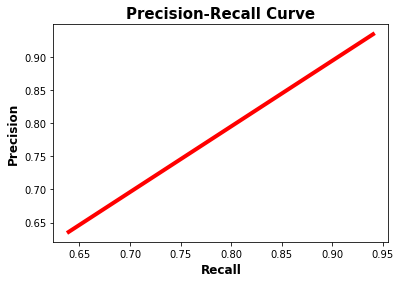

train loss epoch 6/500:   0%|          | 0/86940 [00:00<?, ?img/s]

0.6543622422979


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.55img/s, loss=0.01092]


Validation epoch loss: 0.012879183087251242


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.37img/s, loss=0.00912]


Validation epoch loss: 0.012903434542063254


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.97img/s, loss=0.01832]


Validation epoch loss: 0.016553050304904875


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.06img/s, loss=0.02608]


Validation epoch loss: 0.020322650418129584


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.47img/s, loss=0.01801]


Validation epoch loss: 0.01553899258535528


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(30, 11

Validation round:  11%|█         | 32/302 [00:19<02:45,  1.63samples/s]

truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:

Validation round:  21%|██        | 64/302 [00:36<02:20,  1.69samples/s]

truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 

Validation round:  32%|███▏      | 96/302 [00:55<02:01,  1.69samples/s]

truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(142, 126, 92, 76)]
tr

Validation round:  42%|████▏     | 128/302 [01:13<01:41,  1.72samples/s]

truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102,

Validation round:  53%|█████▎    | 160/302 [01:29<01:19,  1.79samples/s]

truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_b

Validation round:  64%|██████▎   | 192/302 [01:46<00:59,  1.84samples/s]

truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(59, 

Validation round:  74%|███████▍  | 224/302 [02:04<00:43,  1.81samples/s]

truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(1

Validation round:  85%|████████▍ | 256/302 [02:19<00:24,  1.89samples/s]

truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23),

Validation round:  95%|█████████▌| 288/302 [02:42<00:08,  1.70samples/s]

truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(71, 61, 6

Validation round: 320samples [03:01,  1.72samples/s]                    

truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
tru

Validation round: 352samples [03:15,  1.85samples/s]

truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  

Validation round: 384samples [03:32,  1.85samples/s]

truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(96, 104, 55, 5

Validation round: 416samples [03:56,  1.67samples/s]

truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(114, 141, 34, 58)

Validation round: 448samples [04:10,  1.80samples/s]

truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_

Validation round: 480samples [04:30,  1.74samples/s]

truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(184, 5, 33, 52)]
tr

Validation round: 512samples [04:47,  1.79samples/s]

truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(90, 0, 86, 25

Validation round: 544samples [05:03,  1.83samples/s]

truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17),

Validation round: 576samples [05:24,  1.73samples/s]

truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxe

Validation round: 608samples [05:38,  1.86samples/s]

truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(60, 4, 106

Validation round: 640samples [05:52,  1.98samples/s]

truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 1

Validation round: 672samples [07:20,  1.18s/samples]

truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(115, 11, 37, 

Validation round: 704samples [07:42,  1.03s/samples]

truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(71, 152, 94, 59

Validation round: 736samples [08:10,  1.02samples/s]

truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [

Validation round: 768samples [08:26,  1.20samples/s]

truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(31, 88, 98, 101)]
tr

Validation round: 800samples [08:40,  1.38samples/s]

truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:

Validation round: 832samples [08:55,  1.55samples/s]

truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(171, 81, 26, 31)]
tru

Validation round: 864samples [09:08,  1.74samples/s]

truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(124, 134, 77, 108)]
trut

Validation round: 896samples [09:23,  1.85samples/s]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(23, 12, 84, 131)]


Validation round: 928samples [09:39,  1.89samples/s]

truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 

Validation round: 960samples [10:08,  1.56samples/s]

truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(111, 32, 89,

Validation round: 992samples [10:25,  1.65samples/s]

truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(90

Validation round: 1024samples [10:38,  1.83samples/s]

truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(133, 55, 67, 18)]
tr

Validation round: 1056samples [10:55,  1.84samples/s]

truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15)

Validation round: 1088samples [11:15,  1.75samples/s]

truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(123

Validation round: 1120samples [11:30,  1.87samples/s]

truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_

Validation round: 1152samples [12:02,  1.47samples/s]

truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(26, 2, 129, 249)]
tru

Validation round: 1184samples [12:17,  1.63samples/s]

truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(14

Validation round: 1216samples [12:33,  1.73samples/s]

truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29)

Validation round: 1248samples [12:56,  1.60samples/s]

truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(81, 36, 95, 50)]


Validation round: 1280samples [13:20,  1.51samples/s]

truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(0, 67, 98, 155), (1

Validation round: 1312samples [13:45,  1.44samples/s]

truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes

Validation round: 1344samples [14:09,  1.40samples/s]

truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bb

Validation round: 1376samples [14:27,  1.49samples/s]

truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth

Validation round: 1408samples [14:46,  1.55samples/s]

truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(0, 63, 49,

Validation round: 1440samples [15:02,  1.67samples/s]

truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(34, 70, 189

Validation round: 1472samples [15:16,  1.80samples/s]

truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15),

Validation round: 1504samples [15:31,  1.91samples/s]

truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(114, 103

Validation round: 1536samples [16:00,  1.57samples/s]

truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(43, 144, 168, 24)]
t

Validation round: 1568samples [16:16,  1.66samples/s]

truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(27, 70, 202, 86)]
tru

Validation round: 1600samples [16:33,  1.75samples/s]

truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(37, 76

Validation round: 1632samples [16:47,  1.86samples/s]

truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(

Validation round: 1664samples [17:06,  1.81samples/s]

truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(10, 57, 

Validation round: 1696samples [17:22,  1.85samples/s]

truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(39, 61, 7

Validation round: 1728samples [17:45,  1.69samples/s]

truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bbo

Validation round: 1760samples [18:01,  1.78samples/s]

truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes: 

Validation round: 1792samples [18:17,  1.82samples/s]

truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_

Validation round: 1824samples [18:35,  1.83samples/s]

truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(51, 121, 112, 65)]
truth

Validation round: 1856samples [18:55,  1.75samples/s]

truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bbox

Validation round: 1888samples [19:09,  1.88samples/s]

truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(22, 

Validation round: 1920samples [19:25,  1.90samples/s]

truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 3

Validation round: 1952samples [19:49,  1.68samples/s]

truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(46, 92, 9, 20), (65

Validation round: 1984samples [20:11,  1.62samples/s]

truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(34, 20, 195, 8

Validation round: 2016samples [20:36,  1.50samples/s]

truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 3

Validation round: 2048samples [20:49,  1.69samples/s]

truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(40, 91, 132, 93)]
tr

Validation round: 2080samples [21:04,  1.82samples/s]

truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(77, 69, 119, 57)]
t

Validation round: 2112samples [21:17,  1.97samples/s]

truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:

Validation round: 2144samples [21:34,  1.95samples/s]

truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16

Validation round: 2176samples [23:09,  1.25s/samples]

truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(69, 28, 141, 199)]
truth

Validation round: 2208samples [23:27,  1.05s/samples]

truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(55, 163, 52, 53), (155,

Validation round: 2240samples [23:43,  1.13samples/s]

truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
tru

Validation round: 2272samples [24:01,  1.28samples/s]

truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bbox

Validation round: 2304samples [24:16,  1.45samples/s]

truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(25, 44, 152, 166)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxe

Validation round: 2336samples [24:32,  1.56samples/s]

truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(68, 177, 34, 30), (1

Validation round: 2368samples [25:00,  1.42samples/s]

truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(8

Validation round: 2400samples [25:13,  1.62samples/s]

truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(63, 100, 70, 34)]
tr

Validation round: 2432samples [25:31,  1.66samples/s]

truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(45,

Validation round: 2464samples [25:53,  1.61samples/s]

truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 

Validation round: 2496samples [26:11,  1.66samples/s]

truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(85, 83, 123, 25), (12

Validation round: 2528samples [26:32,  1.60samples/s]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_

Validation round: 2560samples [26:49,  1.68samples/s]

truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_b

Validation round: 2592samples [27:05,  1.77samples/s]

truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(59, 119, 149, 114)

Validation round: 2624samples [27:21,  1.82samples/s]

truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(34, 101, 84

Validation round: 2656samples [27:36,  1.92samples/s]

truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 

Validation round: 2688samples [28:13,  1.41samples/s]

truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(45, 37, 4

Validation round: 2720samples [28:35,  1.41samples/s]

truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 1

Validation round: 2752samples [28:53,  1.51samples/s]

truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(62, 156, 74

Validation round: 2784samples [29:09,  1.63samples/s]

truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(67, 2, 107, 240)]
t

Validation round: 2816samples [29:23,  1.78samples/s]

truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(44, 11

Validation round: 2848samples [29:38,  1.88samples/s]

truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
t

Validation round: 2880samples [29:55,  1.88samples/s]

truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bbo

Validation round: 2912samples [30:09,  1.99samples/s]

truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(142, 130, 

Validation round: 2944samples [30:23,  2.07samples/s]

truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(74, 98, 85, 37

Validation round: 2976samples [30:35,  2.22samples/s]

truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(8, 17, 232, 22

Validation round: 3008samples [30:52,  2.11samples/s]

truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(73,

Validation round: 3040samples [31:10,  2.01samples/s]

truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(94, 69,

Validation round: 3072samples [31:23,  2.11samples/s]

truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40,

Validation round: 3104samples [31:48,  1.77samples/s]

truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(103, 96

Validation round: 3136samples [32:04,  1.84samples/s]

truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(26, 12

Validation round: 3168samples [32:16,  2.00samples/s]

truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(71, 6

Validation round: 3200samples [32:30,  2.08samples/s]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes: 

Validation round: 3232samples [34:00,  1.18s/samples]

truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(40, 69, 183, 

Validation round: 3264samples [34:17,  1.02samples/s]

truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(10, 73, 232, 80)]
t

Validation round: 3296samples [34:41,  1.10samples/s]

truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(19, 71, 93, 34), (

Validation round: 3328samples [34:56,  1.28samples/s]

truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(85, 83, 123

Validation round: 3360samples [35:12,  1.43samples/s]

truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_

Validation round: 3392samples [35:28,  1.57samples/s]

truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(10, 63, 234, 99)]
trut

Validation round: 3424samples [35:44,  1.67samples/s]

truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(35, 3

Validation round: 3456samples [35:58,  1.84samples/s]

truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_

Validation round: 3488samples [36:13,  1.92samples/s]

truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(27,

Validation round: 3520samples [36:28,  1.95samples/s]

truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(47,

Validation round: 3552samples [36:45,  1.96samples/s]

truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(99, 129, 57, 1

Validation round: 3584samples [36:58,  2.08samples/s]

truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(187, 151, 27, 52

Validation round: 3616samples [37:20,  1.83samples/s]

truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [

Validation round: 3648samples [37:37,  1.84samples/s]

truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(74, 2

Validation round: 3680samples [37:56,  1.79samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207,

Validation round: 3712samples [38:23,  1.55samples/s]

truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(90, 38, 63, 98)]
tru

Validation round: 3744samples [38:41,  1.63samples/s]

truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143,

Validation round: 3776samples [39:02,  1.58samples/s]

truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(

Validation round: 3808samples [39:22,  1.60samples/s]

truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bbox

Validation round: 3840samples [39:52,  1.40samples/s]

truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(48, 111, 33, 39), (99,

Validation round: 3872samples [40:05,  1.60samples/s]

truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(0, 88, 49

Validation round: 3904samples [40:19,  1.74samples/s]

truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(160, 103, 33, 93)]
t

Validation round: 3936samples [40:34,  1.87samples/s]

truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(137,

Validation round: 3968samples [40:50,  1.88samples/s]

truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [

Validation round: 4000samples [41:06,  1.93samples/s]

truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(99, 4, 96, 186)

Validation round: 4032samples [41:24,  1.87samples/s]

truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (

Validation round: 4064samples [41:43,  1.82samples/s]

truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(

Validation round: 4096samples [41:59,  1.87samples/s]

truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(27, 1

Validation round: 4128samples [42:14,  1.95samples/s]

truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_

Validation round: 4160samples [42:26,  2.11samples/s]

truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(93, 89, 73, 9

Validation round: 4192samples [42:40,  2.17samples/s]

truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175

Validation round: 4224samples [43:01,  1.92samples/s]

truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(170, 1

Validation round: 4256samples [43:15,  2.02samples/s]

truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(137, 76

Validation round: 4288samples [43:31,  2.02samples/s]

truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(0, 45, 41, 39), (7, 16

Validation round: 4320samples [43:51,  1.87samples/s]

truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(49, 95, 60, 100)]
truth

Validation round: 4352samples [44:08,  1.87samples/s]

truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(0, 2, 38, 19), (0

Validation round: 4384samples [45:39,  1.23s/samples]

truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75,

Validation round: 4416samples [45:57,  1.03s/samples]

truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bbox

Validation round: 4448samples [46:11,  1.17samples/s]

truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(37, 76, 175, 48)]
truth

Validation round: 4480samples [46:24,  1.38samples/s]

truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(187, 151, 27, 52)]
truth

Validation round: 4512samples [46:40,  1.54samples/s]

truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
trut

Validation round: 4544samples [46:58,  1.59samples/s]

truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(45, 29, 97, 

Validation round: 4576samples [47:13,  1.72samples/s]

truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(74, 81

Validation round: 4608samples [47:32,  1.71samples/s]

truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(120, 17, 130, 212

Validation round: 4640samples [47:53,  1.67samples/s]

truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_

Validation round: 4672samples [48:07,  1.81samples/s]

truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bbo

Validation round: 4704samples [48:25,  1.80samples/s]

truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(76

Validation round: 4736samples [48:38,  1.95samples/s]

truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(80, 53, 95, 155)]

Validation round: 4768samples [49:01,  1.74samples/s]

truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth

Validation round: 4800samples [49:18,  1.78samples/s]

truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(133, 83, 

Validation round: 4832samples [49:34,  1.85samples/s]

truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(83, 130,

Validation round: 4864samples [49:48,  1.95samples/s]

truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(11, 80, 

Validation round: 4896samples [50:06,  1.90samples/s]

truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(107, 62, 

Validation round: 4928samples [50:25,  1.82samples/s]

truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bbo

Validation round: 4960samples [50:50,  1.63samples/s]

truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19),

Validation round: 4992samples [52:27,  1.34s/samples]

truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bbo

Validation round: 5024samples [52:41,  1.07s/samples]

truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:

Validation round: 5056samples [52:56,  1.12samples/s]

truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(89, 0, 167, 191)]
trut

Validation round: 5088samples [53:12,  1.29samples/s]

truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(96, 104, 5

Validation round: 5120samples [53:25,  1.52samples/s]

truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(

Validation round: 5152samples [53:44,  1.55samples/s]

truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(23, 75,

Validation round: 5184samples [54:02,  1.62samples/s]

truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(91, 38, 38, 38)]
tr

Validation round: 5216samples [54:15,  1.79samples/s]

truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(147, 143, 33, 65)]
truth

Validation round: 5248samples [54:31,  1.86samples/s]

truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(103, 169, 21, 32), 

Validation round: 5280samples [54:55,  1.67samples/s]

truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(165, 7

Validation round: 5312samples [55:08,  1.85samples/s]

truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_b

Validation round: 5344samples [55:21,  1.99samples/s]

truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(3, 69, 248, 100)]

Validation round: 5376samples [55:40,  1.87samples/s]

truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(103, 22, 55, 45)]
tr

Validation round: 5408samples [55:58,  1.85samples/s]

truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136

Validation round: 5440samples [56:16,  1.84samples/s]

truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  

Validation round: 5472samples [56:30,  1.96samples/s]

truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57

Validation round: 5504samples [56:43,  2.05samples/s]

truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136,

Validation round: 5536samples [58:17,  1.22s/samples]

truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxe

Validation round: 5568samples [58:30,  1.03samples/s]

truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [

Validation round: 5600samples [58:45,  1.21samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_b

Validation round: 5632samples [59:12,  1.21samples/s]

truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(93, 100, 69,

Validation round: 5664samples [59:27,  1.39samples/s]

truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bbo

Validation round: 5696samples [59:46,  1.47samples/s]

truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bbo

Validation round: 5728samples [1:00:06,  1.50samples/s]

truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 

Validation round: 5760samples [1:00:22,  1.64samples/s]

truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(157, 128, 20,

Validation round: 5792samples [1:00:40,  1.65samples/s]

truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bbox

Validation round: 5824samples [1:00:55,  1.78samples/s]

truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(14, 161, 15

Validation round: 5856samples [1:01:14,  1.75samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(113, 74, 60, 15)]
truth

Validation round: 5888samples [1:01:27,  1.92samples/s]

truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 

Validation round: 5920samples [1:01:54,  1.63samples/s]

truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(98, 49, 101

Validation round: 5952samples [1:02:10,  1.73samples/s]

truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxe

Validation round: 5984samples [1:02:23,  1.90samples/s]

truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxe

Validation round: 6016samples [1:02:36,  2.02samples/s]

truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(150, 26

Validation round: 6048samples [1:02:50,  2.08samples/s]

truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(57, 97, 28, 2

Validation round: 6080samples [1:03:05,  2.10samples/s]

truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth

Validation round: 6112samples [1:03:20,  2.10samples/s]

truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes

Validation round: 6144samples [1:03:43,  1.85samples/s]

truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(82, 75, 44, 38)]
truth

Validation round: 6176samples [1:03:59,  1.88samples/s]

truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(109, 103, 41, 37)]
tru

Validation round: 6208samples [1:04:15,  1.92samples/s]

truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(3, 83

Validation round: 6240samples [1:04:34,  1.84samples/s]

truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(

Validation round: 6272samples [1:04:57,  1.67samples/s]

truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101,

Validation round: 6304samples [1:05:12,  1.78samples/s]

truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(72, 26, 48, 26)

Validation round: 6336samples [1:05:32,  1.72samples/s]

truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121

Validation round: 6368samples [1:05:51,  1.72samples/s]

truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(150,

Validation round: 6400samples [1:06:05,  1.87samples/s]

truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23

Validation round: 6432samples [1:06:23,  1.85samples/s]

truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bb

Validation round: 6464samples [1:06:43,  1.76samples/s]

truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(108, 34, 6

Validation round: 6496samples [1:06:56,  1.93samples/s]

truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(109, 152,

Validation round: 6528samples [1:07:10,  2.00samples/s]

truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140

Validation round: 6560samples [1:08:48,  1.26s/samples]

truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (13

Validation round: 6592samples [1:09:04,  1.04s/samples]

truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131

Validation round: 6624samples [1:09:28,  1.05samples/s]

truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  

Validation round: 6656samples [1:09:44,  1.23samples/s]

truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(97, 192, 61, 45)]

Validation round: 6688samples [1:10:00,  1.38samples/s]

truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(6

Validation round: 6720samples [1:10:16,  1.53samples/s]

truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(126, 129, 38, 9

Validation round: 6752samples [1:10:44,  1.39samples/s]

truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bbo

Validation round: 6784samples [1:10:58,  1.56samples/s]

truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth

Validation round: 6816samples [1:11:17,  1.60samples/s]

truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(97, 8, 33, 55),

Validation round: 6848samples [1:11:32,  1.74samples/s]

truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bbox

Validation round: 6880samples [1:11:46,  1.86samples/s]

truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(46, 72, 38, 57), (

Validation round: 6912samples [1:11:59,  2.00samples/s]

truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(79, 

Validation round: 6944samples [1:12:13,  2.09samples/s]

truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(64, 99, 142, 115)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(68, 119, 32, 56), (74

Validation round: 6976samples [1:12:39,  1.73samples/s]

truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:

Validation round: 7008samples [1:12:59,  1.68samples/s]

truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(54, 109, 38,

Validation round: 7040samples [1:13:12,  1.88samples/s]

truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(68, 68, 121, 80)

Validation round: 7072samples [1:13:25,  2.00samples/s]

truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 1

Validation round: 7104samples [1:13:40,  2.07samples/s]

truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(65, 52, 133, 89)]

Validation round: 7136samples [1:13:58,  1.96samples/s]

truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(137, 59, 65, 53)]
tr

Validation round: 7168samples [1:14:15,  1.95samples/s]

truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(14,

Validation round: 7200samples [1:14:33,  1.87samples/s]

truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(

Validation round: 7232samples [1:14:47,  1.98samples/s]

truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bbox

Validation round: 7264samples [1:15:00,  2.12samples/s]

truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [

Validation round: 7296samples [1:15:26,  1.73samples/s]

truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(54, 109, 38, 85

Validation round: 7328samples [1:15:45,  1.74samples/s]

truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(60, 31, 116,

Validation round: 7360samples [1:16:01,  1.80samples/s]

truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(80, 56, 96, 82)]
tr

Validation round: 7392samples [1:16:15,  1.92samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47

Validation round: 7424samples [1:16:32,  1.92samples/s]

truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(0, 30, 8

Validation round: 7456samples [1:16:46,  2.01samples/s]

truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  

Validation round: 7488samples [1:17:00,  2.09samples/s]

truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(39, 

Validation round: 7520samples [1:17:14,  2.12samples/s]

truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  

Validation round: 7552samples [1:17:35,  1.90samples/s]

truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83,

Validation round: 7584samples [1:17:52,  1.89samples/s]

truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 5

Validation round: 7616samples [1:18:12,  1.82samples/s]

truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(89, 1

Validation round: 7648samples [1:18:25,  1.96samples/s]

truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxe

Validation round: 7680samples [1:18:47,  1.78samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153,

Validation round: 7712samples [1:19:05,  1.76samples/s]

truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181

Validation round: 7744samples [1:19:27,  1.67samples/s]

truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(

Validation round: 7776samples [1:19:41,  1.82samples/s]

truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(45, 28, 168, 10

Validation round: 7808samples [1:19:59,  1.82samples/s]

truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19

Validation round: 7840samples [1:21:35,  1.29s/samples]

truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_

Validation round: 7872samples [1:21:51,  1.06s/samples]

truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(73, 62, 70, 25), (143,

Validation round: 7904samples [1:22:09,  1.11samples/s]

truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 

Validation round: 7936samples [1:22:25,  1.28samples/s]

truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(67, 1

Validation round: 7968samples [1:22:41,  1.43samples/s]

truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(57, 203, 30,

Validation round: 8000samples [1:22:55,  1.62samples/s]

truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(67, 10

Validation round: 8032samples [1:23:09,  1.76samples/s]

truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_

Validation round: 8064samples [1:23:24,  1.88samples/s]

truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(67, 89, 12

Validation round: 8096samples [1:23:40,  1.91samples/s]

truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(106, 133,

Validation round: 8128samples [1:23:51,  2.10samples/s]

truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3,

Validation round: 8160samples [1:24:29,  1.45samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(50, 155,

Validation round: 8192samples [1:24:43,  1.63samples/s]

truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
t

Validation round: 8224samples [1:25:00,  1.70samples/s]

truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(85,

Validation round: 8256samples [1:25:16,  1.79samples/s]

truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(31, 82, 7

Validation round: 8288samples [1:25:34,  1.79samples/s]

truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(61, 66, 118, 

Validation round: 8320samples [1:25:46,  1.97samples/s]

truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (10

Validation round: 8352samples [1:27:16,  1.19s/samples]

truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(74, 112, 1

Validation round: 8384samples [1:27:31,  1.02samples/s]

truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(109, 152,

Validation round: 8416samples [1:27:48,  1.18samples/s]

truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
tru

Validation round: 8448samples [1:28:06,  1.31samples/s]

truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(69, 28, 1

Validation round: 8480samples [1:28:26,  1.39samples/s]

truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(58, 70, 84, 52), (

Validation round: 8512samples [1:28:44,  1.50samples/s]

truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(47, 13, 21, 20), (53, 

Validation round: 8544samples [1:29:02,  1.56samples/s]

truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
tr

Validation round: 8576samples [1:29:16,  1.72samples/s]

truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(54, 10

Validation round: 8608samples [1:29:32,  1.79samples/s]

truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
trut

Validation round: 8640samples [1:29:49,  1.83samples/s]

truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [

Validation round: 8672samples [1:30:06,  1.84samples/s]

truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20),

Validation round: 8704samples [1:31:43,  1.29s/samples]

truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(33, 74, 180, 

Validation round: 8736samples [1:32:00,  1.06s/samples]

truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxe

Validation round: 8768samples [1:32:15,  1.13samples/s]

truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:

Validation round: 8800samples [1:32:30,  1.31samples/s]

truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_

Validation round: 8832samples [1:32:44,  1.51samples/s]

truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
tru

Validation round: 8864samples [1:32:59,  1.66samples/s]

truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(87, 47, 84, 139)]


Validation round: 8896samples [1:33:13,  1.80samples/s]

truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(175, 103, 

Validation round: 8928samples [1:33:27,  1.94samples/s]

truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(0, 144, 8, 13)

Validation round: 8960samples [1:33:41,  2.02samples/s]

truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(100, 1

Validation round: 8992samples [1:33:57,  2.00samples/s]

truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(72, 146, 41, 90)]


Validation round: 9024samples [1:34:21,  1.76samples/s]

truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(63, 132, 

Validation round: 9056samples [1:34:36,  1.85samples/s]

truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(0, 19, 250, 214)]
truth

Validation round: 9088samples [1:34:51,  1.93samples/s]

truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 12

Validation round: 9120samples [1:35:12,  1.77samples/s]

truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(0, 0, 159, 

Validation round: 9152samples [1:35:28,  1.84samples/s]

truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(19, 102, 129, 45)

Validation round: 9184samples [1:35:56,  1.56samples/s]

truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_

Validation round: 9216samples [1:36:11,  1.69samples/s]

truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:

Validation round: 9248samples [1:36:28,  1.75samples/s]

truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72)

Validation round: 9280samples [1:36:44,  1.82samples/s]

truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(8

Validation round: 9312samples [1:37:04,  1.74samples/s]

truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(

Validation round: 9344samples [1:37:21,  1.77samples/s]

truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(27, 20, 217, 219)]


Validation round: 9376samples [1:37:45,  1.61samples/s]

truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(114, 84, 34, 64)]

Validation round: 9408samples [1:38:13,  1.44samples/s]

truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(83, 134

Validation round: 9440samples [1:38:27,  1.61samples/s]

truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162,

Validation round: 9472samples [1:38:41,  1.78samples/s]

truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 2

Validation round: 9504samples [1:38:56,  1.88samples/s]

truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
tru

Validation round: 9536samples [1:39:10,  1.98samples/s]

truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(19, 62, 208, 121

Validation round: 9568samples [1:39:25,  2.01samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(83, 65, 108, 83)

Validation round: 9600samples [1:39:48,  1.77samples/s]

truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(22, 20, 110, 131)

Validation round: 9632samples [1:40:07,  1.76samples/s]

truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(178, 157, 31, 32)]
truth

Validation round: 9660samples [1:40:22,  1.78samples/s]

truth_bboxes:  [(116, 29, 54, 92)]


Validation round: 9660samples [1:40:22,  1.60samples/s]


Precisions: [0.9011050890406138, 0.8925177729288379, 0.8831561906102625, 0.8709790948124164, 0.8561272612092631, 0.8363482790173858, 0.7929893714366157, 0.7329485464911664, 0.6198352924614626]    Recalls: [0.9254680835682787, 0.9166485939420227, 0.9070339044314321, 0.8945275789778067, 0.8792741993782983, 0.858960456878479, 0.8144292633557435, 0.752765126870527, 0.6365936528591051]    Accuracies: [0.8401365008531303, 0.8255208333333334, 0.809849609501065, 0.7898633984424869, 0.7660767147445992, 0.7353632875355861, 0.671634672707762, 0.590741476144551, 0.4578350837059374]


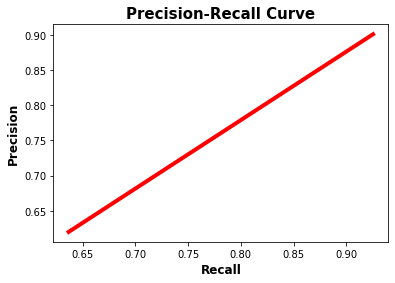

  0%|          | 0/86940 [00:00<?, ?img/s]

0.6241236484045669


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 101.88img/s, loss=0.01403]


Validation epoch loss: 0.01356952739509427


  0%|          | 0/86940 [00:00<?, ?img/s]

Validation epoch loss: 0.015300775144175188


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.33img/s, loss=0.02798]


Validation epoch loss: 0.021485259805787478


validation loss: 100%|██████████| 9660/9660 [01:31<00:00, 105.33img/s, loss=0.02089]


Validation epoch loss: 0.022370151043653686


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.38img/s, loss=0.01252]


Validation epoch loss: 0.012638553394165062


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes: 

Validation round:  11%|█         | 32/302 [00:15<02:07,  2.12samples/s]

truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(39, 105, 21, 32), (136, 

Validation round:  21%|██        | 64/302 [00:29<01:50,  2.16samples/s]

truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20

Validation round:  32%|███▏      | 96/302 [02:08<04:18,  1.25s/samples]

truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(45, 43, 149, 75)]
tr

Validation round:  42%|████▏     | 128/302 [02:26<03:01,  1.04s/samples]

truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 

Validation round:  53%|█████▎    | 160/302 [02:41<02:04,  1.14samples/s]

truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(88, 117, 

Validation round:  64%|██████▎   | 192/302 [02:55<01:21,  1.35samples/s]

truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188,

Validation round:  74%|███████▍  | 224/302 [03:10<00:51,  1.52samples/s]

truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(18, 8, 146, 165)]
tr

Validation round:  85%|████████▍ | 256/302 [03:27<00:28,  1.61samples/s]

truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(67, 139, 118, 88)

Validation round:  95%|█████████▌| 288/302 [03:43<00:08,  1.69samples/s]

truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(134, 108, 113

Validation round: 320samples [04:00,  1.75samples/s]                    

truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(1, 84, 7

Validation round: 352samples [04:13,  1.94samples/s]

truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bbo

Validation round: 384samples [04:27,  2.03samples/s]

truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_

Validation round: 416samples [04:47,  1.86samples/s]

truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29)

Validation round: 448samples [05:05,  1.86samples/s]

truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  

Validation round: 480samples [05:30,  1.64samples/s]

truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_b

Validation round: 512samples [05:48,  1.66samples/s]

truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(33, 74, 1

Validation round: 544samples [06:02,  1.82samples/s]

truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes

Validation round: 576samples [06:15,  1.96samples/s]

truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxe

Validation round: 608samples [06:29,  2.07samples/s]

truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes

Validation round: 640samples [06:43,  2.12samples/s]

truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bbo

Validation round: 672samples [08:23,  1.27s/samples]

truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxe

Validation round: 704samples [08:37,  1.02s/samples]

truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(130, 88, 112, 6

Validation round: 736samples [08:57,  1.11samples/s]

truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(1

Validation round: 768samples [09:24,  1.14samples/s]

truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bbo

Validation round: 800samples [09:42,  1.27samples/s]

truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(110, 25, 45, 59)]
truth

Validation round: 832samples [09:54,  1.50samples/s]

truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:

Validation round: 864samples [10:10,  1.62samples/s]

truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(88, 96, 90, 73)]
trut

Validation round: 896samples [10:24,  1.80samples/s]

truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxe

Validation round: 928samples [10:38,  1.91samples/s]

truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(74,

Validation round: 960samples [10:55,  1.91samples/s]

truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_b

Validation round: 992samples [11:12,  1.90samples/s]

truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(63, 122, 23, 5

Validation round: 1024samples [11:32,  1.80samples/s]

truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26,

Validation round: 1056samples [11:47,  1.89samples/s]

truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(59, 55, 33, 6

Validation round: 1088samples [12:01,  1.99samples/s]

truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 

Validation round: 1120samples [12:16,  2.01samples/s]

truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(97, 192, 61, 45)

Validation round: 1152samples [12:38,  1.81samples/s]

truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_b

Validation round: 1184samples [12:52,  1.94samples/s]

truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_

Validation round: 1216samples [13:11,  1.86samples/s]

truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes: 

Validation round: 1248samples [13:30,  1.79samples/s]

truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(70, 

Validation round: 1280samples [13:47,  1.82samples/s]

truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes

Validation round: 1312samples [14:03,  1.86samples/s]

truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(141, 151

Validation round: 1344samples [14:18,  1.94samples/s]

truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217,

Validation round: 1376samples [15:59,  1.30s/samples]

truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102,

Validation round: 1408samples [16:27,  1.17s/samples]

truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(44, 39, 171, 154)]
t

Validation round: 1440samples [16:51,  1.05s/samples]

truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bbox

Validation round: 1472samples [17:09,  1.11samples/s]

truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(55, 163, 

Validation round: 1504samples [17:26,  1.26samples/s]

truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(1

Validation round: 1536samples [17:45,  1.37samples/s]

truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 

Validation round: 1568samples [18:00,  1.53samples/s]

truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(48, 30, 15

Validation round: 1600samples [18:14,  1.70samples/s]

truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(123, 89, 18, 29)

Validation round: 1632samples [18:31,  1.73samples/s]

truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_

Validation round: 1664samples [18:48,  1.79samples/s]

truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(78

Validation round: 1696samples [19:06,  1.79samples/s]

truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxe

Validation round: 1728samples [19:19,  1.95samples/s]

truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_b

Validation round: 1760samples [19:33,  2.03samples/s]

truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(92, 21,

Validation round: 1792samples [19:48,  2.06samples/s]

truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(82, 29, 79, 193)]


Validation round: 1824samples [20:03,  2.08samples/s]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxe

Validation round: 1856samples [20:16,  2.17samples/s]

truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101,

Validation round: 1888samples [20:34,  2.03samples/s]

truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 

Validation round: 1920samples [20:49,  2.09samples/s]

truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (15

Validation round: 1952samples [21:10,  1.88samples/s]

truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 

Validation round: 1984samples [21:28,  1.85samples/s]

truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bb

Validation round: 2016samples [21:49,  1.73samples/s]

truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bb

Validation round: 2048samples [22:02,  1.90samples/s]

truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(18, 76, 237, 109)]
truth

Validation round: 2080samples [22:17,  1.95samples/s]

truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bbox

Validation round: 2112samples [22:33,  2.00samples/s]

truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(37, 76,

Validation round: 2144samples [22:47,  2.06samples/s]

truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 3

Validation round: 2176samples [23:11,  1.78samples/s]

truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_

Validation round: 2208samples [23:24,  1.92samples/s]

truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  

Validation round: 2240samples [23:41,  1.90samples/s]

truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(56, 142, 69, 48), (

Validation round: 2272samples [23:56,  1.98samples/s]

truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
tr

Validation round: 2304samples [24:12,  2.00samples/s]

truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(71, 55, 119, 181)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth

Validation round: 2336samples [24:28,  1.98samples/s]

truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(25, 0, 55, 23), (207, 

Validation round: 2368samples [24:43,  2.03samples/s]

truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bbox

Validation round: 2400samples [24:56,  2.13samples/s]

truth_bboxes:  [(161, 149, 84, 92)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(51, 172

Validation round: 2432samples [25:11,  2.14samples/s]

truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [

Validation round: 2464samples [25:36,  1.79samples/s]

truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 

Validation round: 2496samples [25:53,  1.81samples/s]

truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bbox

Validation round: 2528samples [26:07,  1.95samples/s]

truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(39, 

Validation round: 2560samples [26:22,  1.99samples/s]

truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]

Validation round: 2592samples [26:43,  1.82samples/s]

truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  

Validation round: 2624samples [26:59,  1.87samples/s]

truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(72, 26, 48, 26), (230,

Validation round: 2656samples [27:15,  1.90samples/s]

truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(57, 146, 18

Validation round: 2688samples [27:40,  1.65samples/s]

truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(99, 38,

Validation round: 2720samples [27:55,  1.78samples/s]

truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(55,

Validation round: 2752samples [28:11,  1.86samples/s]

truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(184, 99, 60, 1

Validation round: 2784samples [28:24,  1.98samples/s]

truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
t

Validation round: 2816samples [28:37,  2.11samples/s]

truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 

Validation round: 2848samples [30:25,  1.34s/samples]

truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70,

Validation round: 2880samples [30:41,  1.09s/samples]

truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(55, 62, 176, 13

Validation round: 2912samples [30:59,  1.07samples/s]

truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  

Validation round: 2944samples [31:19,  1.19samples/s]

truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (18

Validation round: 2976samples [31:38,  1.31samples/s]

truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(

Validation round: 3008samples [31:50,  1.53samples/s]

truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(86, 94, 78, 106)]
tr

Validation round: 3040samples [32:10,  1.55samples/s]

truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]


Validation round: 3072samples [32:29,  1.60samples/s]

truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
t

Validation round: 3104samples [32:48,  1.63samples/s]

truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 1

Validation round: 3136samples [34:27,  1.36s/samples]

truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(0, 29, 114, 157)]


Validation round: 3168samples [34:40,  1.07s/samples]

truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72,

Validation round: 3200samples [34:54,  1.13samples/s]

truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(66, 160, 

Validation round: 3232samples [35:09,  1.32samples/s]

truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(151,

Validation round: 3264samples [35:22,  1.53samples/s]

truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxe

Validation round: 3296samples [35:35,  1.72samples/s]

truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(92, 23, 36, 71

Validation round: 3328samples [35:52,  1.79samples/s]

truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(29, 166, 

Validation round: 3360samples [36:13,  1.68samples/s]

truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(17, 202, 50,

Validation round: 3392samples [36:31,  1.72samples/s]

truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(87

Validation round: 3424samples [36:44,  1.89samples/s]

truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(101, 59

Validation round: 3456samples [37:08,  1.67samples/s]

truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes: 

Validation round: 3488samples [37:24,  1.76samples/s]

truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bb

Validation round: 3520samples [37:50,  1.55samples/s]

truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(68

Validation round: 3552samples [38:06,  1.68samples/s]

truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_b

Validation round: 3584samples [38:23,  1.74samples/s]

truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(27, 6

Validation round: 3616samples [38:40,  1.77samples/s]

truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(65, 52, 13

Validation round: 3648samples [38:53,  1.92samples/s]

truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60

Validation round: 3680samples [39:11,  1.87samples/s]

truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bbox

Validation round: 3712samples [39:25,  2.01samples/s]

truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(113, 84

Validation round: 3744samples [39:41,  1.99samples/s]

truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(160, 1

Validation round: 3776samples [39:55,  2.06samples/s]

truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(45, 149, 18, 22

Validation round: 3808samples [40:11,  2.06samples/s]

truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(31, 

Validation round: 3840samples [40:28,  1.99samples/s]

truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118

Validation round: 3872samples [40:49,  1.84samples/s]

truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(48, 3

Validation round: 3904samples [41:03,  1.95samples/s]

truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(96, 117, 75,

Validation round: 3936samples [41:18,  1.98samples/s]

truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(65, 90, 94, 3

Validation round: 3968samples [41:34,  2.02samples/s]

truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(82, 87, 96, 126

Validation round: 4000samples [41:53,  1.89samples/s]

truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(53, 43

Validation round: 4032samples [42:10,  1.87samples/s]

truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_

Validation round: 4064samples [42:25,  1.95samples/s]

truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(103

Validation round: 4096samples [42:41,  1.98samples/s]

truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bbo

Validation round: 4128samples [42:55,  2.04samples/s]

truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(19, 71, 93, 34

Validation round: 4160samples [43:09,  2.12samples/s]

truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(124, 3

Validation round: 4192samples [43:24,  2.15samples/s]

truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(136, 22, 119, 68

Validation round: 4224samples [43:38,  2.16samples/s]

truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth

Validation round: 4256samples [43:55,  2.07samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_

Validation round: 4288samples [44:09,  2.12samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(64, 99, 142, 115)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 2

Validation round: 4320samples [44:24,  2.13samples/s]

truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 13

Validation round: 4352samples [44:39,  2.13samples/s]

truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(100

Validation round: 4384samples [44:53,  2.17samples/s]

truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(0, 15, 

Validation round: 4416samples [45:13,  1.97samples/s]

truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(26, 121, 70,

Validation round: 4448samples [45:28,  2.02samples/s]

truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bbox

Validation round: 4480samples [45:46,  1.95samples/s]

truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
t

Validation round: 4512samples [46:01,  1.98samples/s]

truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bb

Validation round: 4544samples [46:18,  1.95samples/s]

truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(73, 53

Validation round: 4576samples [46:33,  2.01samples/s]

truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]


Validation round: 4608samples [46:48,  2.05samples/s]

truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(89, 110, 2

Validation round: 4640samples [47:01,  2.14samples/s]

truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(40, 91, 182, 108)]
tr

Validation round: 4672samples [47:17,  2.11samples/s]

truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 

Validation round: 4704samples [47:34,  2.04samples/s]

truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(92, 11

Validation round: 4736samples [47:52,  1.97samples/s]

truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bbo

Validation round: 4768samples [48:12,  1.82samples/s]

truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes: 

Validation round: 4800samples [48:30,  1.81samples/s]

truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bb

Validation round: 4832samples [48:44,  1.95samples/s]

truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bbox

Validation round: 4864samples [48:58,  2.04samples/s]

truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(62, 4, 132, 204)]
tru

Validation round: 4896samples [49:13,  2.05samples/s]

truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(26, 83, 15, 21), 

Validation round: 4928samples [49:29,  2.02samples/s]

truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(100, 101, 

Validation round: 4960samples [49:44,  2.09samples/s]

truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(8, 46, 135, 33)

Validation round: 4992samples [49:59,  2.07samples/s]

truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth

Validation round: 5024samples [50:20,  1.90samples/s]

truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(73, 62,

Validation round: 5056samples [52:03,  1.34s/samples]

truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(0, 110, 38, 43), (60, 

Validation round: 5088samples [53:48,  1.92s/samples]

truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxe

Validation round: 5120samples [54:00,  1.46s/samples]

truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  

Validation round: 5152samples [54:15,  1.16s/samples]

truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(16, 129, 110, 104), (145,

Validation round: 5184samples [54:30,  1.05samples/s]

truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(41, 109, 161, 81)]
trut

Validation round: 5216samples [54:43,  1.26samples/s]

truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(20, 52, 3

Validation round: 5248samples [54:57,  1.45samples/s]

truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(28, 37, 

Validation round: 5280samples [55:12,  1.63samples/s]

truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_

Validation round: 5312samples [55:26,  1.77samples/s]

truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(133

Validation round: 5344samples [55:42,  1.82samples/s]

truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(104,

Validation round: 5376samples [56:00,  1.82samples/s]

truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(177, 116

Validation round: 5408samples [56:20,  1.75samples/s]

truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(63, 

Validation round: 5440samples [56:36,  1.82samples/s]

truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(107, 62, 4

Validation round: 5472samples [56:48,  2.00samples/s]

truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxe

Validation round: 5504samples [58:31,  1.31s/samples]

truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 

Validation round: 5536samples [58:46,  1.06s/samples]

truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bbox

Validation round: 5568samples [59:00,  1.14samples/s]

truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  

Validation round: 5600samples [59:16,  1.31samples/s]

truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:

Validation round: 5632samples [59:30,  1.50samples/s]

truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(126, 139, 26, 30)]

Validation round: 5664samples [59:47,  1.60samples/s]

truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(0,

Validation round: 5696samples [1:00:09,  1.55samples/s]

truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [

Validation round: 5728samples [1:00:26,  1.64samples/s]

truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(66, 27, 

Validation round: 5760samples [1:00:42,  1.74samples/s]

truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(187, 151, 2

Validation round: 5792samples [1:00:55,  1.90samples/s]

truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bb

Validation round: 5824samples [1:01:13,  1.86samples/s]

truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64,

Validation round: 5856samples [1:01:28,  1.93samples/s]

truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_b

Validation round: 5888samples [1:01:44,  1.95samples/s]

truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:

Validation round: 5920samples [1:01:59,  2.00samples/s]

truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(17,

Validation round: 5952samples [1:02:15,  2.02samples/s]

truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204,

Validation round: 5984samples [1:02:33,  1.93samples/s]

truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes

Validation round: 6016samples [1:02:56,  1.72samples/s]

truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxe

Validation round: 6048samples [1:03:11,  1.85samples/s]

truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)

Validation round: 6080samples [1:03:26,  1.93samples/s]

truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(26, 4

Validation round: 6112samples [1:03:41,  1.98samples/s]

truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(50, 25, 169, 146)]
truth

Validation round: 6144samples [1:03:55,  2.04samples/s]

truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:

Validation round: 6176samples [1:04:11,  2.05samples/s]

truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83,

Validation round: 6208samples [1:04:27,  2.05samples/s]

truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(118, 16, 36, 58)]
tr

Validation round: 6240samples [1:04:53,  1.69samples/s]

truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(135, 5

Validation round: 6272samples [1:05:09,  1.77samples/s]

truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(48, 30,

Validation round: 6304samples [1:05:25,  1.83samples/s]

truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 

Validation round: 6336samples [1:07:12,  1.38s/samples]

truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(

Validation round: 6368samples [1:07:29,  1.13s/samples]

truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(141, 148,

Validation round: 6400samples [1:07:41,  1.10samples/s]

truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  

Validation round: 6432samples [1:07:56,  1.30samples/s]

truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]


Validation round: 6464samples [1:08:13,  1.43samples/s]

truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(25, 44, 152, 166)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123,

Validation round: 6496samples [1:08:32,  1.49samples/s]

truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(

Validation round: 6528samples [1:08:58,  1.41samples/s]

truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33

Validation round: 6560samples [1:09:16,  1.51samples/s]

truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(137, 76, 117, 155)]


Validation round: 6592samples [1:09:43,  1.39samples/s]

truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]


Validation round: 6624samples [1:10:04,  1.42samples/s]

truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(18

Validation round: 6656samples [1:10:21,  1.55samples/s]

truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(61, 40, 130, 193

Validation round: 6688samples [1:10:38,  1.64samples/s]

truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  

Validation round: 6720samples [1:10:57,  1.63samples/s]

truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(60, 116, 15

Validation round: 6752samples [1:11:13,  1.74samples/s]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  

Validation round: 6784samples [1:11:32,  1.71samples/s]

truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxe

Validation round: 6816samples [1:11:54,  1.64samples/s]

truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 1

Validation round: 6848samples [1:12:18,  1.52samples/s]

truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxe

Validation round: 6880samples [1:12:42,  1.46samples/s]

truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(61, 29, 63,

Validation round: 6912samples [1:13:06,  1.43samples/s]

truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(73, 49, 115, 

Validation round: 6944samples [1:13:30,  1.40samples/s]

truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bbox

Validation round: 6976samples [1:13:43,  1.61samples/s]

truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bbox

Validation round: 7008samples [1:13:58,  1.73samples/s]

truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(27, 83, 120, 139)]
t

Validation round: 7040samples [1:14:18,  1.69samples/s]

truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(23, 134, 3

Validation round: 7072samples [1:14:34,  1.77samples/s]

truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(106, 

Validation round: 7104samples [1:14:50,  1.82samples/s]

truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(0,

Validation round: 7136samples [1:15:06,  1.88samples/s]

truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164,

Validation round: 7168samples [1:15:36,  1.53samples/s]

truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(28, 92, 121,

Validation round: 7200samples [1:15:49,  1.72samples/s]

truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(100, 114, 52, 49)]
t

Validation round: 7232samples [1:16:04,  1.85samples/s]

truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bbox

Validation round: 7264samples [1:16:19,  1.92samples/s]

truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(114, 31, 

Validation round: 7296samples [1:16:32,  2.04samples/s]

truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(20, 77, 56, 31)]
trut

Validation round: 7328samples [1:16:48,  2.05samples/s]

truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 

Validation round: 7360samples [1:17:09,  1.85samples/s]

truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(49, 81, 126, 93)]


Validation round: 7392samples [1:17:23,  1.96samples/s]

truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(106,

Validation round: 7424samples [1:17:36,  2.10samples/s]

truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
tru

Validation round: 7456samples [1:18:02,  1.73samples/s]

truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 

Validation round: 7488samples [1:18:21,  1.70samples/s]

truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(0, 

Validation round: 7520samples [1:18:42,  1.64samples/s]

truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bbo

Validation round: 7552samples [1:19:10,  1.46samples/s]

truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
tru

Validation round: 7584samples [1:19:25,  1.60samples/s]

truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 6

Validation round: 7616samples [1:19:55,  1.40samples/s]

truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(33, 12

Validation round: 7648samples [1:20:09,  1.59samples/s]

truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(87, 1

Validation round: 7680samples [1:20:25,  1.67samples/s]

truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120,

Validation round: 7712samples [1:20:45,  1.65samples/s]

truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(34, 29, 204, 204)]


Validation round: 7744samples [1:21:07,  1.59samples/s]

truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(44, 89, 10, 30), (1

Validation round: 7776samples [1:21:31,  1.52samples/s]

truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(

Validation round: 7808samples [1:21:55,  1.46samples/s]

truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(99, 135, 45, 3

Validation round: 7840samples [1:22:09,  1.62samples/s]

truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(107, 196, 61, 31)]
t

Validation round: 7872samples [1:22:23,  1.79samples/s]

truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(28,

Validation round: 7904samples [1:22:42,  1.75samples/s]

truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(14, 161

Validation round: 7936samples [1:22:56,  1.89samples/s]

truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (20

Validation round: 7968samples [1:23:14,  1.85samples/s]

truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(8

Validation round: 8000samples [1:23:35,  1.74samples/s]

truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(93, 1

Validation round: 8032samples [1:23:48,  1.90samples/s]

truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(107, 19

Validation round: 8064samples [1:24:01,  2.03samples/s]

truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(37, 21, 177, 215)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(32, 66, 79, 1

Validation round: 8096samples [1:24:15,  2.09samples/s]

truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(81, 139

Validation round: 8128samples [1:24:33,  1.99samples/s]

truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 

Validation round: 8160samples [1:24:49,  2.01samples/s]

truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(85, 135,

Validation round: 8192samples [1:25:06,  1.95samples/s]

truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(131, 13

Validation round: 8224samples [1:25:20,  2.04samples/s]

truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(109

Validation round: 8256samples [1:25:35,  2.09samples/s]

truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(57, 57, 141, 106)]
truth

Validation round: 8288samples [1:25:54,  1.95samples/s]

truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bb

Validation round: 8320samples [1:26:07,  2.06samples/s]

truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (12

Validation round: 8352samples [1:26:23,  2.04samples/s]

truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth

Validation round: 8384samples [1:26:48,  1.74samples/s]

truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(8, 34, 246,

Validation round: 8416samples [1:27:01,  1.91samples/s]

truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(68, 54, 105

Validation round: 8448samples [1:27:16,  1.99samples/s]

truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:

Validation round: 8480samples [1:27:38,  1.78samples/s]

truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(9

Validation round: 8512samples [1:28:00,  1.68samples/s]

truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bb

Validation round: 8544samples [1:28:14,  1.82samples/s]

truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(29, 37, 52, 48)

Validation round: 8576samples [1:28:33,  1.76samples/s]

truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [

Validation round: 8608samples [1:28:50,  1.82samples/s]

truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(53

Validation round: 8640samples [1:29:03,  1.95samples/s]

truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(38, 144,

Validation round: 8672samples [1:29:27,  1.72samples/s]

truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(124, 37, 54,

Validation round: 8704samples [1:29:41,  1.85samples/s]

truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bbo

Validation round: 8736samples [1:29:56,  1.94samples/s]

truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(67, 1

Validation round: 8768samples [1:30:10,  2.03samples/s]

truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(68, 109, 103, 78)]
trut

Validation round: 8800samples [1:30:24,  2.11samples/s]

truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes

Validation round: 8832samples [1:30:38,  2.16samples/s]

truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 1

Validation round: 8864samples [1:31:06,  1.70samples/s]

truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(101, 59, 51, 123)]

Validation round: 8896samples [1:31:21,  1.80samples/s]

truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(20, 96, 38, 41), (

Validation round: 8928samples [1:31:36,  1.89samples/s]

truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 

Validation round: 8960samples [1:32:03,  1.62samples/s]

truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(22, 54, 24, 33), 

Validation round: 8992samples [1:32:17,  1.77samples/s]

truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_

Validation round: 9024samples [1:32:32,  1.85samples/s]

truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(84, 

Validation round: 9056samples [1:32:46,  1.96samples/s]

truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bb

Validation round: 9088samples [1:33:00,  2.04samples/s]

truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(9

Validation round: 9120samples [1:33:17,  2.01samples/s]

truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_

Validation round: 9152samples [1:35:01,  1.32s/samples]

truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bb

Validation round: 9184samples [1:35:15,  1.05s/samples]

truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  

Validation round: 9216samples [1:35:44,  1.01s/samples]

truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(0, 70, 190, 95)]
trut

Validation round: 9248samples [1:35:59,  1.17samples/s]

truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(62, 42, 137, 136)]


Validation round: 9280samples [1:36:12,  1.39samples/s]

truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(101, 

Validation round: 9312samples [1:36:29,  1.52samples/s]

truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 

Validation round: 9344samples [1:36:44,  1.67samples/s]

truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxe

Validation round: 9376samples [1:36:58,  1.80samples/s]

truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:

Validation round: 9408samples [1:37:13,  1.88samples/s]

truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(22, 32,

Validation round: 9440samples [1:37:29,  1.92samples/s]

truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bbox

Validation round: 9472samples [1:37:42,  2.04samples/s]

truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(97, 115, 97

Validation round: 9504samples [1:37:56,  2.13samples/s]

truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
tru

Validation round: 9536samples [1:38:13,  2.03samples/s]

truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(89, 119, 11

Validation round: 9568samples [1:38:31,  1.97samples/s]

truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153

Validation round: 9600samples [1:38:58,  1.64samples/s]

truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxe

Validation round: 9632samples [1:39:12,  1.80samples/s]

truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(100, 7

Validation round: 9660samples [1:39:23,  1.62samples/s]

truth_bboxes:  [(3, 91, 29, 50)]
Precisions: [0.9619537275064267, 0.9553433712816746, 0.9447668013220712, 0.9352919573999265, 0.9206757253029747, 0.8994491369812706, 0.8634594197576203, 0.7996327579875138, 0.68879911861917]    Recalls: [0.9467938986481602, 0.9402877177763319, 0.9298778283814068, 0.9205523024651197, 0.9061664136485217, 0.8852743439600954, 0.8498518036579195, 0.787031012795489, 0.6779440468445023]    Accuracies: [0.9126193296634381, 0.9006993975486463, 0.8819334933150497, 0.865434280277287, 0.8405418091597935, 0.8055519010656492, 0.7491715523833801, 0.6573878388986172, 0.5189817376867737]


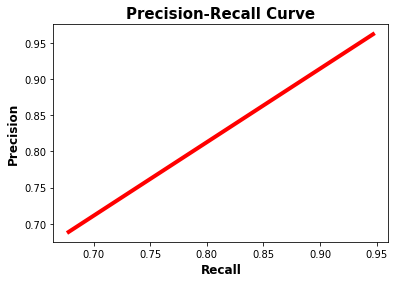

train loss epoch 16/500:   0%|          | 0/86940 [00:00<?, ?img/s]

0.6980046888997153


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.67img/s, loss=0.03172]


Validation epoch loss: 0.03234941284141398


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.11img/s, loss=0.01088]


Validation epoch loss: 0.01126006934082518


validation loss: 100%|██████████| 9660/9660 [01:35<00:00, 101.61img/s, loss=0.00906]


Validation epoch loss: 0.00997236112922134


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 102.80img/s, loss=0.01208]


Validation epoch loss: 0.010923440858030951


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.45img/s, loss=0.01087]


Validation epoch loss: 0.011792164169473957


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(76,

Validation round:  11%|█         | 32/302 [00:16<02:22,  1.90samples/s]

truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes

Validation round:  21%|██        | 64/302 [00:46<02:33,  1.55samples/s]

truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:

Validation round:  32%|███▏      | 96/302 [01:02<02:04,  1.66samples/s]

truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(34, 70, 189, 112)]
tru

Validation round:  42%|████▏     | 128/302 [01:19<01:40,  1.73samples/s]

truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(

Validation round:  53%|█████▎    | 160/302 [01:36<01:20,  1.76samples/s]

truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(13, 89, 103, 80), (

Validation round:  64%|██████▎   | 192/302 [01:51<00:59,  1.85samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(0, 29

Validation round:  74%|███████▍  | 224/302 [02:07<00:40,  1.91samples/s]

truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bb

Validation round:  85%|████████▍ | 256/302 [02:26<00:25,  1.84samples/s]

truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_

Validation round:  95%|█████████▌| 288/302 [02:46<00:07,  1.76samples/s]

truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27,

Validation round: 320samples [03:04,  1.75samples/s]                    

truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(109, 135, 57, 41)

Validation round: 352samples [03:21,  1.80samples/s]

truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 6

Validation round: 384samples [03:37,  1.84samples/s]

truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(42, 56, 171, 

Validation round: 416samples [03:51,  1.98samples/s]

truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_b

Validation round: 448samples [04:07,  1.97samples/s]

truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_b

Validation round: 480samples [04:26,  1.87samples/s]

truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bb

Validation round: 512samples [04:39,  2.01samples/s]

truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30

Validation round: 544samples [04:55,  2.01samples/s]

truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(98, 1

Validation round: 576samples [05:10,  2.05samples/s]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 4

Validation round: 608samples [05:29,  1.94samples/s]

truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(14, 86, 16

Validation round: 640samples [05:52,  1.72samples/s]

truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(35, 125, 55, 

Validation round: 672samples [06:07,  1.84samples/s]

truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:

Validation round: 704samples [06:22,  1.93samples/s]

truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(48, 6

Validation round: 736samples [06:36,  1.99samples/s]

truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_

Validation round: 768samples [07:07,  1.57samples/s]

truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(163, 151, 8

Validation round: 800samples [08:47,  1.38s/samples]

truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(33, 27, 182, 124)]
tru

Validation round: 832samples [09:03,  1.12s/samples]

truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(53, 107

Validation round: 864samples [09:20,  1.06samples/s]

truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(23, 42, 

Validation round: 896samples [09:50,  1.06samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(39, 61, 74, 

Validation round: 928samples [10:16,  1.11samples/s]

truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxe

Validation round: 960samples [10:36,  1.22samples/s]

truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(54, 107, 

Validation round: 992samples [11:01,  1.24samples/s]

truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(125, 30, 

Validation round: 1024samples [11:15,  1.43samples/s]

truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  

Validation round: 1056samples [11:35,  1.48samples/s]

truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:

Validation round: 1088samples [11:59,  1.44samples/s]

truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(109, 93, 23, 

Validation round: 1120samples [12:14,  1.59samples/s]

truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0,

Validation round: 1152samples [12:31,  1.66samples/s]

truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(15, 56, 224, 138)]
tru

Validation round: 1184samples [13:00,  1.45samples/s]

truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(147, 81,

Validation round: 1216samples [13:14,  1.62samples/s]

truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(79, 80, 44, 41),

Validation round: 1248samples [13:32,  1.66samples/s]

truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bbo

Validation round: 1280samples [13:46,  1.81samples/s]

truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(123,

Validation round: 1312samples [14:11,  1.62samples/s]

truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(110, 5

Validation round: 1344samples [14:26,  1.73samples/s]

truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(113, 74, 60, 15)]


Validation round: 1376samples [14:44,  1.74samples/s]

truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(114

Validation round: 1408samples [14:59,  1.86samples/s]

truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(7

Validation round: 1440samples [15:17,  1.83samples/s]

truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes

Validation round: 1472samples [15:36,  1.79samples/s]

truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(83, 134, 94,

Validation round: 1504samples [15:53,  1.82samples/s]

truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(161, 149, 84, 92)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(85, 83

Validation round: 1536samples [16:06,  1.95samples/s]

truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bbo

Validation round: 1568samples [16:18,  2.12samples/s]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(62, 87, 45, 30),

Validation round: 1600samples [16:35,  2.05samples/s]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(88, 6

Validation round: 1632samples [16:49,  2.15samples/s]

truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes

Validation round: 1664samples [17:02,  2.21samples/s]

truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(66, 160, 132,

Validation round: 1696samples [17:16,  2.22samples/s]

truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes: 

Validation round: 1728samples [17:30,  2.24samples/s]

truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(58, 126, 7

Validation round: 1760samples [17:46,  2.20samples/s]

truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  

Validation round: 1792samples [18:01,  2.14samples/s]

truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(80, 56, 96, 82)]


Validation round: 1824samples [18:21,  1.96samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bbo

Validation round: 1856samples [18:34,  2.08samples/s]

truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(37, 14, 1

Validation round: 1888samples [18:49,  2.09samples/s]

truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(0, 3, 256, 2

Validation round: 1920samples [19:10,  1.90samples/s]

truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111,

Validation round: 1952samples [19:25,  1.95samples/s]

truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes

Validation round: 1984samples [19:46,  1.81samples/s]

truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:

Validation round: 2016samples [19:59,  1.94samples/s]

truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(14,

Validation round: 2048samples [20:15,  1.98samples/s]

truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(19, 62, 208,

Validation round: 2080samples [20:29,  2.04samples/s]

truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(79, 62, 98,

Validation round: 2112samples [20:44,  2.06samples/s]

truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100

Validation round: 2144samples [21:02,  1.98samples/s]

truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_

Validation round: 2176samples [21:21,  1.87samples/s]

truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bb

Validation round: 2208samples [21:36,  1.97samples/s]

truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(50, 0, 154, 104)]
tr

Validation round: 2240samples [21:50,  2.03samples/s]

truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(23, 42, 199,

Validation round: 2272samples [22:05,  2.06samples/s]

truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
tru

Validation round: 2304samples [22:26,  1.89samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41,

Validation round: 2336samples [25:33,  2.13s/samples]

truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(121, 128, 38, 45)]


Validation round: 2368samples [25:47,  1.62s/samples]

truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(0, 0

Validation round: 2400samples [26:08,  1.34s/samples]

truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(89, 54, 29, 35)]

Validation round: 2432samples [26:23,  1.07s/samples]

truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(103, 96, 

Validation round: 2464samples [26:36,  1.15samples/s]

truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_

Validation round: 2496samples [26:50,  1.34samples/s]

truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(81, 84, 100, 79)]
tr

Validation round: 2528samples [27:10,  1.41samples/s]

truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_

Validation round: 2560samples [27:26,  1.55samples/s]

truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(58, 99, 135, 

Validation round: 2592samples [29:05,  1.38s/samples]

truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(138, 18, 57, 168)]
tr

Validation round: 2624samples [29:25,  1.15s/samples]

truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(76, 5

Validation round: 2656samples [29:45,  1.00samples/s]

truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(44, 173,

Validation round: 2688samples [29:58,  1.22samples/s]

truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(47, 35, 15

Validation round: 2720samples [30:13,  1.41samples/s]

truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(6

Validation round: 2752samples [30:33,  1.46samples/s]

truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96,

Validation round: 2784samples [30:48,  1.62samples/s]

truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(104, 5

Validation round: 2816samples [31:01,  1.79samples/s]

truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(13, 1

Validation round: 2848samples [31:26,  1.60samples/s]

truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(91, 38, 38

Validation round: 2880samples [31:44,  1.66samples/s]

truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(72, 26, 

Validation round: 2912samples [31:57,  1.81samples/s]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes: 

Validation round: 2944samples [33:39,  1.34s/samples]

truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_b

Validation round: 2976samples [33:58,  1.11s/samples]

truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  

Validation round: 3008samples [34:14,  1.07samples/s]

truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(121, 128, 3

Validation round: 3040samples [34:28,  1.28samples/s]

truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(12

Validation round: 3072samples [34:42,  1.48samples/s]

truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(79, 129, 

Validation round: 3104samples [34:57,  1.62samples/s]

truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(175,

Validation round: 3136samples [35:11,  1.78samples/s]

truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(29, 109

Validation round: 3168samples [35:25,  1.89samples/s]

truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(99, 135, 72

Validation round: 3200samples [35:49,  1.68samples/s]

truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(35, 

Validation round: 3232samples [36:05,  1.79samples/s]

truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(19, 

Validation round: 3264samples [36:21,  1.83samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(0, 140, 18

Validation round: 3296samples [36:35,  1.95samples/s]

truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]

Validation round: 3328samples [36:54,  1.87samples/s]

truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bb

Validation round: 3360samples [37:12,  1.85samples/s]

truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(76, 70, 78, 97)]
trut

Validation round: 3392samples [37:36,  1.65samples/s]

truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(7, 67, 244, 1

Validation round: 3424samples [37:59,  1.55samples/s]

truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(12

Validation round: 3456samples [38:15,  1.68samples/s]

truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), 

Validation round: 3488samples [39:53,  1.34s/samples]

truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(79,

Validation round: 3520samples [40:07,  1.07s/samples]

truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(44, 89, 10, 30), (196, 

Validation round: 3552samples [40:22,  1.12samples/s]

truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(107, 143

Validation round: 3584samples [40:41,  1.24samples/s]

truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]

Validation round: 3616samples [40:55,  1.45samples/s]

truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxe

Validation round: 3648samples [41:09,  1.62samples/s]

truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes

Validation round: 3680samples [41:26,  1.70samples/s]

truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(54, 26, 1

Validation round: 3712samples [41:44,  1.73samples/s]

truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(40, 49,

Validation round: 3744samples [41:59,  1.83samples/s]

truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bbo

Validation round: 3776samples [42:13,  1.95samples/s]

truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(62, 67, 129, 30), (

Validation round: 3808samples [42:27,  2.02samples/s]

truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(165, 78, 

Validation round: 3840samples [42:47,  1.87samples/s]

truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxe

Validation round: 3872samples [43:05,  1.84samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(41, 64, 157, 16

Validation round: 3904samples [43:21,  1.88samples/s]

truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(24, 109, 27, 12), (

Validation round: 3936samples [43:40,  1.84samples/s]

truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(0, 

Validation round: 3968samples [43:55,  1.90samples/s]

truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10

Validation round: 4000samples [44:09,  2.02samples/s]

truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(114, 10

Validation round: 4032samples [44:23,  2.08samples/s]

truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(61,

Validation round: 4064samples [44:36,  2.16samples/s]

truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(0, 142, 17

Validation round: 4096samples [44:58,  1.91samples/s]

truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes: 

Validation round: 4128samples [45:11,  2.02samples/s]

truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(11

Validation round: 4160samples [45:26,  2.08samples/s]

truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(104, 58

Validation round: 4192samples [45:39,  2.17samples/s]

truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(120, 17, 130, 2

Validation round: 4224samples [46:04,  1.81samples/s]

truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(95, 10

Validation round: 4256samples [46:29,  1.61samples/s]

truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bb

Validation round: 4288samples [46:54,  1.49samples/s]

truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(9, 100, 97,

Validation round: 4320samples [47:13,  1.53samples/s]

truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth

Validation round: 4352samples [47:28,  1.69samples/s]

truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(55, 1

Validation round: 4384samples [47:43,  1.79samples/s]

truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(41, 54,

Validation round: 4416samples [47:58,  1.87samples/s]

truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(105, 144, 112

Validation round: 4448samples [48:16,  1.87samples/s]

truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(94, 69, 65, 117)]
tr

Validation round: 4480samples [49:57,  1.32s/samples]

truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes

Validation round: 4512samples [50:08,  1.03s/samples]

truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(214, 120, 30, 54)]


Validation round: 4544samples [50:23,  1.16samples/s]

truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(85, 54, 16, 2

Validation round: 4576samples [50:39,  1.33samples/s]

truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157

Validation round: 4608samples [50:55,  1.48samples/s]

truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(79, 76, 107, 53)]
trut

Validation round: 4640samples [51:12,  1.58samples/s]

truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(37, 21, 177, 215)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(86, 1

Validation round: 4672samples [51:27,  1.72samples/s]

truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(25, 44, 152, 166)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 

Validation round: 4704samples [53:09,  1.36s/samples]

truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(50, 142, 42, 22)]


Validation round: 4736samples [53:24,  1.10s/samples]

truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  

Validation round: 4768samples [53:40,  1.09samples/s]

truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(88, 96, 90, 73)]
trut

Validation round: 4800samples [53:59,  1.21samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(2, 35

Validation round: 4832samples [54:16,  1.37samples/s]

truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes: 

Validation round: 4864samples [54:30,  1.54samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(133, 55, 6

Validation round: 4896samples [54:44,  1.71samples/s]

truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 

Validation round: 4928samples [55:04,  1.69samples/s]

truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(86,

Validation round: 4960samples [55:18,  1.83samples/s]

truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 

Validation round: 4992samples [57:00,  1.34s/samples]

truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_

Validation round: 5024samples [57:18,  1.10s/samples]

truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(103, 86, 66, 62)]
t

Validation round: 5056samples [57:38,  1.04samples/s]

truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(85, 83, 123

Validation round: 5088samples [57:52,  1.24samples/s]

truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth

Validation round: 5120samples [58:13,  1.32samples/s]

truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(11, 39,

Validation round: 5152samples [58:27,  1.51samples/s]

truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 4

Validation round: 5184samples [58:42,  1.64samples/s]

truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bbox

Validation round: 5216samples [58:59,  1.72samples/s]

truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(124, 131, 21

Validation round: 5248samples [59:12,  1.90samples/s]

truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(22, 175, 47, 42)]

Validation round: 5280samples [59:34,  1.73samples/s]

truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(89, 69, 

Validation round: 5312samples [59:47,  1.91samples/s]

truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(17, 202, 50, 41)]
trut

Validation round: 5344samples [1:00:10,  1.72samples/s]

truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(67, 13

Validation round: 5376samples [1:00:29,  1.71samples/s]

truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(63, 12

Validation round: 5408samples [1:00:43,  1.83samples/s]

truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(89, 136, 75, 79)]
truth

Validation round: 5440samples [1:01:07,  1.66samples/s]

truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_

Validation round: 5472samples [1:01:25,  1.67samples/s]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(103, 22, 55, 45)]
tr

Validation round: 5504samples [1:01:44,  1.69samples/s]

truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(88, 

Validation round: 5536samples [1:01:56,  1.88samples/s]

truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(138, 51, 40, 43)

Validation round: 5568samples [1:02:11,  1.96samples/s]

truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162,

Validation round: 5600samples [1:02:25,  2.06samples/s]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(72, 180

Validation round: 5632samples [1:02:42,  2.01samples/s]

truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(

Validation round: 5664samples [1:03:03,  1.84samples/s]

truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(81, 81, 2

Validation round: 5696samples [1:03:17,  1.95samples/s]

truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(77,

Validation round: 5728samples [1:03:32,  1.98samples/s]

truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(42, 0, 116, 238)]


Validation round: 5760samples [1:03:45,  2.09samples/s]

truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  

Validation round: 5792samples [1:04:04,  1.96samples/s]

truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(58, 22, 92, 210)]

Validation round: 5824samples [1:04:23,  1.86samples/s]

truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (19

Validation round: 5856samples [1:04:38,  1.93samples/s]

truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(38, 24, 88,

Validation round: 5888samples [1:04:53,  1.99samples/s]

truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(42, 12, 172, 70), (142

Validation round: 5920samples [1:05:09,  1.99samples/s]

truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(50

Validation round: 5952samples [1:05:25,  2.00samples/s]

truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(91, 51, 29, 

Validation round: 5984samples [1:05:40,  2.06samples/s]

truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(140, 134, 71, 40)]
truth

Validation round: 6016samples [1:05:53,  2.16samples/s]

truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bb

Validation round: 6048samples [1:06:11,  2.03samples/s]

truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(42

Validation round: 6080samples [1:06:29,  1.93samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(110, 58, 

Validation round: 6112samples [1:06:57,  1.62samples/s]

truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39

Validation round: 6144samples [1:08:38,  1.38s/samples]

truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(37, 47, 41, 64), (188, 71, 55, 93)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152,

Validation round: 6176samples [1:08:55,  1.13s/samples]

truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes

Validation round: 6208samples [1:09:09,  1.08samples/s]

truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_

Validation round: 6240samples [1:09:24,  1.28samples/s]

truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bb

Validation round: 6272samples [1:09:37,  1.49samples/s]

truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(73, 49, 1

Validation round: 6304samples [1:10:04,  1.39samples/s]

truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  

Validation round: 6336samples [1:10:24,  1.44samples/s]

truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(165, 94, 49, 60)

Validation round: 6368samples [1:10:40,  1.57samples/s]

truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(41, 166,

Validation round: 6400samples [1:10:53,  1.75samples/s]

truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(68, 105, 113, 24), (11

Validation round: 6432samples [1:11:13,  1.71samples/s]

truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(4

Validation round: 6464samples [1:11:43,  1.45samples/s]

truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
tru

Validation round: 6496samples [1:11:59,  1.57samples/s]

truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  

Validation round: 6528samples [1:12:14,  1.71samples/s]

truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes

Validation round: 6560samples [1:12:34,  1.67samples/s]

truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [

Validation round: 6592samples [1:12:53,  1.69samples/s]

truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 1

Validation round: 6624samples [1:13:09,  1.77samples/s]

truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(67, 

Validation round: 6656samples [1:13:26,  1.79samples/s]

truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
trut

Validation round: 6688samples [1:13:43,  1.83samples/s]

truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(166,

Validation round: 6720samples [1:14:02,  1.79samples/s]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes

Validation round: 6752samples [1:14:27,  1.58samples/s]

truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 

Validation round: 6784samples [1:14:49,  1.55samples/s]

truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(90, 142, 76, 73), (95, 6

Validation round: 6816samples [1:15:11,  1.52samples/s]

truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(76, 45, 

Validation round: 6848samples [1:15:27,  1.65samples/s]

truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(41, 152, 37, 76)

Validation round: 6880samples [1:15:45,  1.68samples/s]

truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 8

Validation round: 6912samples [1:16:09,  1.56samples/s]

truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(149, 167, 22, 12),

Validation round: 6944samples [1:16:24,  1.68samples/s]

truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(45, 29, 97, 189)]


Validation round: 6976samples [1:16:49,  1.55samples/s]

truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), 

Validation round: 7008samples [1:17:11,  1.52samples/s]

truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(61, 66, 

Validation round: 7040samples [1:17:30,  1.56samples/s]

truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_

Validation round: 7072samples [1:17:43,  1.75samples/s]

truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37

Validation round: 7104samples [1:18:09,  1.56samples/s]

truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes: 

Validation round: 7136samples [1:18:22,  1.75samples/s]

truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(108, 131, 1

Validation round: 7168samples [1:18:45,  1.61samples/s]

truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(3, 91, 29, 

Validation round: 7200samples [1:18:58,  1.80samples/s]

truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
tru

Validation round: 7232samples [1:19:15,  1.84samples/s]

truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(73, 53, 38, 49), (1

Validation round: 7264samples [1:19:32,  1.85samples/s]

truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24)

Validation round: 7296samples [1:19:49,  1.87samples/s]

truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(96, 53,

Validation round: 7328samples [1:20:02,  1.98samples/s]

truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bb

Validation round: 7360samples [1:20:19,  1.94samples/s]

truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_b

Validation round: 7392samples [1:20:38,  1.87samples/s]

truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (16

Validation round: 7424samples [1:20:56,  1.85samples/s]

truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes: 

Validation round: 7456samples [1:21:08,  2.01samples/s]

truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13

Validation round: 7488samples [1:21:32,  1.77samples/s]

truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bbox

Validation round: 7520samples [1:21:46,  1.90samples/s]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 9

Validation round: 7552samples [1:22:05,  1.81samples/s]

truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(73, 64, 106, 75)]

Validation round: 7584samples [1:22:19,  1.94samples/s]

truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 1

Validation round: 7616samples [1:22:35,  1.97samples/s]

truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(50, 0, 154, 104)]
tr

Validation round: 7648samples [1:22:53,  1.88samples/s]

truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  

Validation round: 7680samples [1:23:07,  2.01samples/s]

truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:

Validation round: 7712samples [1:23:24,  1.96samples/s]

truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bb

Validation round: 7744samples [1:23:43,  1.87samples/s]

truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(20, 107, 226, 126)

Validation round: 7776samples [1:24:00,  1.89samples/s]

truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(15, 68, 228, 99)]
tr

Validation round: 7808samples [1:24:19,  1.80samples/s]

truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(84, 

Validation round: 7840samples [1:24:39,  1.73samples/s]

truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (

Validation round: 7872samples [1:24:54,  1.84samples/s]

truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(85

Validation round: 7904samples [1:25:11,  1.85samples/s]

truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(28, 153, 46

Validation round: 7936samples [1:25:38,  1.59samples/s]

truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(10, 99, 66, 38)]

Validation round: 7968samples [1:25:54,  1.69samples/s]

truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(31, 75, 10

Validation round: 8000samples [1:26:11,  1.75samples/s]

truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(73, 53, 38, 49), (155, 5

Validation round: 8032samples [1:26:26,  1.85samples/s]

truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(80, 56, 96, 82

Validation round: 8064samples [1:26:44,  1.85samples/s]

truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes

Validation round: 8096samples [1:26:55,  2.04samples/s]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(

Validation round: 8128samples [1:27:11,  2.03samples/s]

truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
tru

Validation round: 8160samples [1:27:28,  2.00samples/s]

truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100,

Validation round: 8192samples [1:27:52,  1.72samples/s]

truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  

Validation round: 8224samples [1:28:17,  1.58samples/s]

truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(79, 1

Validation round: 8256samples [1:28:31,  1.72samples/s]

truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(142, 126, 9

Validation round: 8288samples [1:28:46,  1.82samples/s]

truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(0, 77, 236, 84)]

Validation round: 8320samples [1:29:04,  1.83samples/s]

truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bb

Validation round: 8352samples [1:29:18,  1.93samples/s]

truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(

Validation round: 8384samples [1:29:34,  1.95samples/s]

truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(38, 97, 2

Validation round: 8416samples [1:29:49,  2.01samples/s]

truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(87, 136, 1

Validation round: 8448samples [1:30:03,  2.10samples/s]

truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(52, 116, 43,

Validation round: 8480samples [1:30:17,  2.12samples/s]

truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes: 

Validation round: 8512samples [1:30:33,  2.12samples/s]

truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(77, 76, 106, 102)]


Validation round: 8544samples [1:30:48,  2.13samples/s]

truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes

Validation round: 8576samples [1:31:03,  2.10samples/s]

truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(67, 41, 128, 111)]
tr

Validation round: 8608samples [1:31:17,  2.16samples/s]

truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(31, 76, 163,

Validation round: 8640samples [1:31:31,  2.18samples/s]

truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bb

Validation round: 8672samples [1:31:45,  2.21samples/s]

truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bbox

Validation round: 8704samples [1:31:59,  2.27samples/s]

truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(82, 129, 73, 89)]
tr

Validation round: 8736samples [1:32:14,  2.23samples/s]

truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(158, 38

Validation round: 8768samples [1:32:29,  2.18samples/s]

truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(13, 0, 2

Validation round: 8800samples [1:32:44,  2.19samples/s]

truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(73, 186, 59, 55), (

Validation round: 8832samples [1:33:01,  2.06samples/s]

truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]

Validation round: 8864samples [1:33:22,  1.86samples/s]

truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(7

Validation round: 8896samples [1:33:42,  1.78samples/s]

truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bbo

Validation round: 8928samples [1:33:59,  1.83samples/s]

truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(65, 156, 112, 70)]


Validation round: 8960samples [1:34:14,  1.91samples/s]

truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bbo

Validation round: 8992samples [1:34:27,  2.03samples/s]

truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(102, 70, 47, 78)]
tru

Validation round: 9024samples [1:34:42,  2.08samples/s]

truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_

Validation round: 9056samples [1:34:57,  2.06samples/s]

truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(88

Validation round: 9088samples [1:35:12,  2.09samples/s]

truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(49, 146, 205, 110)]
tr

Validation round: 9120samples [1:35:29,  2.04samples/s]

truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bb

Validation round: 9152samples [1:35:45,  2.04samples/s]

truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(63, 122, 23,

Validation round: 9184samples [1:36:07,  1.79samples/s]

truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(101, 61, 74, 50)]
t

Validation round: 9216samples [1:36:24,  1.82samples/s]

truth_bboxes:  [(64, 99, 142, 115)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(181, 

Validation round: 9248samples [1:36:37,  1.97samples/s]

truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 

Validation round: 9280samples [1:36:57,  1.86samples/s]

truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), 

Validation round: 9312samples [1:37:15,  1.84samples/s]

truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(181, 31, 75,

Validation round: 9344samples [1:37:29,  1.95samples/s]

truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(203, 108, 18, 19

Validation round: 9376samples [1:37:54,  1.68samples/s]

truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 2

Validation round: 9408samples [1:38:23,  1.44samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bbox

Validation round: 9440samples [1:38:38,  1.60samples/s]

truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes: 

Validation round: 9472samples [1:39:13,  1.32samples/s]

truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(

Validation round: 9504samples [1:39:31,  1.42samples/s]

truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(11

Validation round: 9536samples [1:39:50,  1.49samples/s]

truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxe

Validation round: 9568samples [1:40:05,  1.64samples/s]

truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bb

Validation round: 9600samples [1:40:19,  1.78samples/s]

truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(10, 47, 19, 32)]


Validation round: 9632samples [1:40:36,  1.83samples/s]

truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157

Validation round: 9660samples [1:40:57,  1.59samples/s]

truth_bboxes:  [(93, 139, 61, 57)]


Precisions: [0.9480919309801675, 0.940359418629627, 0.9317677382401375, 0.9224600844848572, 0.9102885372664137, 0.8878069735805828, 0.8578792868905277, 0.7939428653254099, 0.6831817856375743]    Recalls: [0.9572760789416612, 0.9494686618954674, 0.940793754066363, 0.9313959372515, 0.9191064844936022, 0.8964071423407793, 0.866189546736066, 0.8016337743078147, 0.6897997542109449]    Accuracies: [0.9096029674405824, 0.8955407063957452, 0.8801569051805762, 0.8637704478412443, 0.8427681293914888, 0.8051948051948052, 0.7574914654191427, 0.6635748907904973, 0.5226202212728667]


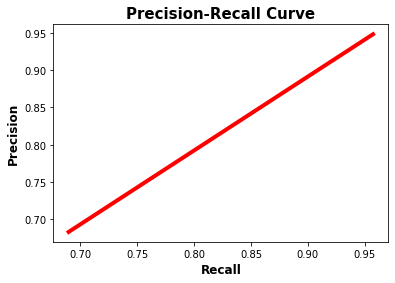

train loss epoch 21/500:   0%|          | 0/86940 [00:00<?, ?img/s]

0.698572645787521


validation loss: 100%|██████████| 9660/9660 [01:30<00:00, 106.67img/s, loss=0.01406]


Validation epoch loss: 0.011911216885813617


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.79img/s, loss=0.01241]


Validation epoch loss: 0.01480660903027022


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.55img/s, loss=0.01388]


Validation epoch loss: 0.01247760999812097


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.19img/s, loss=0.01697]


Validation epoch loss: 0.015705876234326732


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.68img/s, loss=0.00956]


Validation epoch loss: 0.01211945739704252


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(26

Validation round:  11%|█         | 32/302 [00:20<02:50,  1.58samples/s]

truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(23, 75, 203, 1

Validation round:  21%|██        | 64/302 [00:38<02:25,  1.64samples/s]

truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(51, 126, 76, 7

Validation round:  32%|███▏      | 96/302 [00:54<01:59,  1.73samples/s]

truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(20, 52, 3

Validation round:  42%|████▏     | 128/302 [01:10<01:36,  1.80samples/s]

truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bbox

Validation round:  53%|█████▎    | 160/302 [01:25<01:15,  1.87samples/s]

truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(54, 67, 55, 37), (189, 

Validation round:  64%|██████▎   | 192/302 [01:41<00:57,  1.93samples/s]

truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_b

Validation round:  74%|███████▍  | 224/302 [01:58<00:41,  1.90samples/s]

truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(21, 92, 44

Validation round:  85%|████████▍ | 256/302 [03:41<01:01,  1.33s/samples]

truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(89, 119, 80, 26)]
tr

Validation round:  95%|█████████▌| 288/302 [04:01<00:15,  1.12s/samples]

truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 

Validation round: 320samples [05:42,  1.73s/samples]                    

truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [

Validation round: 352samples [06:07,  1.45s/samples]

truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(40, 49, 6, 10

Validation round: 384samples [06:21,  1.14s/samples]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(80, 73, 75, 148)]
tr

Validation round: 416samples [06:40,  1.02samples/s]

truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(25, 44, 152, 166)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(79, 130, 55, 

Validation round: 448samples [06:54,  1.22samples/s]

truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(149, 87, 70, 39)]

Validation round: 480samples [07:12,  1.35samples/s]

truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(7, 85, 230, 99)]


Validation round: 512samples [07:28,  1.51samples/s]

truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(126

Validation round: 544samples [07:45,  1.59samples/s]

truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(14

Validation round: 576samples [08:02,  1.67samples/s]

truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  

Validation round: 608samples [08:16,  1.83samples/s]

truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bbo

Validation round: 640samples [08:36,  1.76samples/s]

truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
tr

Validation round: 672samples [09:00,  1.59samples/s]

truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(79, 129, 82, 88)]
trut

Validation round: 704samples [09:28,  1.43samples/s]

truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bbox

Validation round: 736samples [09:50,  1.43samples/s]

truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(121, 150, 39, 25)]
trut

Validation round: 768samples [10:07,  1.54samples/s]

truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)

Validation round: 800samples [10:24,  1.64samples/s]

truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(1

Validation round: 832samples [10:39,  1.76samples/s]

truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 

Validation round: 864samples [10:53,  1.89samples/s]

truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(94, 69, 65, 117)]
tru

Validation round: 896samples [11:07,  1.99samples/s]

truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81,

Validation round: 928samples [11:21,  2.08samples/s]

truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(1

Validation round: 960samples [11:32,  2.26samples/s]

truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(92, 111, 70

Validation round: 992samples [11:46,  2.27samples/s]

truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66,

Validation round: 1024samples [12:01,  2.24samples/s]

truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(144, 49,

Validation round: 1056samples [12:18,  2.10samples/s]

truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(96, 10

Validation round: 1088samples [12:38,  1.91samples/s]

truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(59, 118, 72, 56)]

Validation round: 1120samples [12:58,  1.82samples/s]

truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes: 

Validation round: 1152samples [13:10,  2.00samples/s]

truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(39, 155, 70, 72)]
truth

Validation round: 1184samples [13:27,  1.97samples/s]

truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(57, 106, 70, 1

Validation round: 1216samples [13:52,  1.70samples/s]

truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(100, 114, 52, 49)

Validation round: 1248samples [14:05,  1.88samples/s]

truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
trut

Validation round: 1280samples [14:22,  1.88samples/s]

truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_

Validation round: 1312samples [14:36,  1.98samples/s]

truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 

Validation round: 1344samples [14:51,  2.02samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [

Validation round: 1376samples [15:04,  2.13samples/s]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(214, 120, 30, 54)]
truth

Validation round: 1408samples [15:23,  1.97samples/s]

truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(76

Validation round: 1440samples [15:38,  2.02samples/s]

truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bbo

Validation round: 1472samples [15:51,  2.12samples/s]

truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(51, 5

Validation round: 1504samples [16:08,  2.05samples/s]

truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bbo

Validation round: 1536samples [16:23,  2.07samples/s]

truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102,

Validation round: 1568samples [16:44,  1.87samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(98, 80, 99, 85

Validation round: 1600samples [17:03,  1.83samples/s]

truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 2

Validation round: 1632samples [17:16,  1.97samples/s]

truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(13, 52, 2

Validation round: 1664samples [17:39,  1.76samples/s]

truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(20, 55, 28, 52)

Validation round: 1696samples [17:59,  1.71samples/s]

truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(131, 57, 22, 37)]

Validation round: 1728samples [18:19,  1.66samples/s]

truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(9, 62, 123, 68)]
tru

Validation round: 1760samples [18:34,  1.80samples/s]

truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26

Validation round: 1792samples [18:54,  1.72samples/s]

truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(38, 20, 178, 21

Validation round: 1824samples [19:13,  1.72samples/s]

truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(31, 151, 7, 6

Validation round: 1856samples [19:28,  1.82samples/s]

truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bbo

Validation round: 1888samples [19:41,  1.96samples/s]

truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(60, 116, 150, 118)]
tru

Validation round: 1920samples [19:57,  1.98samples/s]

truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
t

Validation round: 1952samples [20:14,  1.94samples/s]

truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(2, 35,

Validation round: 1984samples [20:29,  2.00samples/s]

truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:

Validation round: 2016samples [20:46,  1.98samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(49, 34, 

Validation round: 2048samples [21:02,  1.99samples/s]

truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101

Validation round: 2080samples [21:30,  1.61samples/s]

truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_b

Validation round: 2112samples [21:44,  1.78samples/s]

truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(20, 55, 28,

Validation round: 2144samples [21:58,  1.90samples/s]

truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(99, 16, 14

Validation round: 2176samples [22:15,  1.89samples/s]

truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(52, 116

Validation round: 2208samples [22:29,  1.99samples/s]

truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89),

Validation round: 2240samples [22:51,  1.81samples/s]

truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(53, 109, 30, 25), (

Validation round: 2272samples [23:10,  1.76samples/s]

truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(106, 136, 52, 104)]
t

Validation round: 2304samples [23:24,  1.91samples/s]

truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(191, 111, 64, 1

Validation round: 2336samples [23:43,  1.83samples/s]

truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_b

Validation round: 2368samples [23:59,  1.87samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(96, 117, 7

Validation round: 2400samples [24:12,  2.00samples/s]

truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(110, 111

Validation round: 2432samples [24:27,  2.05samples/s]

truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(3,

Validation round: 2464samples [24:44,  1.99samples/s]

truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes: 

Validation round: 2496samples [24:56,  2.18samples/s]

truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8),

Validation round: 2528samples [25:20,  1.81samples/s]

truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33),

Validation round: 2560samples [25:46,  1.59samples/s]

truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bb

Validation round: 2592samples [26:01,  1.73samples/s]

truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(91, 36, 

Validation round: 2624samples [26:14,  1.88samples/s]

truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
tr

Validation round: 2656samples [26:30,  1.94samples/s]

truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(4

Validation round: 2688samples [26:46,  1.95samples/s]

truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(104, 31, 82, 53)]


Validation round: 2720samples [26:58,  2.11samples/s]

truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(80, 74, 95,

Validation round: 2752samples [27:13,  2.13samples/s]

truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), 

Validation round: 2784samples [28:54,  1.27s/samples]

truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxe

Validation round: 2816samples [29:08,  1.02s/samples]

truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bb

Validation round: 2848samples [29:24,  1.15samples/s]

truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(

Validation round: 2880samples [29:40,  1.31samples/s]

truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(109,

Validation round: 2912samples [29:58,  1.44samples/s]

truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bbox

Validation round: 2944samples [30:12,  1.62samples/s]

truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(132, 82, 22, 49)]
truth

Validation round: 2976samples [30:30,  1.66samples/s]

truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(21

Validation round: 3008samples [30:45,  1.78samples/s]

truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(35, 76, 116, 24), (118, 15

Validation round: 3040samples [30:58,  1.93samples/s]

truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(30, 122, 179, 89)

Validation round: 3072samples [31:15,  1.93samples/s]

truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(65, 52, 133, 89)]
tr

Validation round: 3104samples [31:33,  1.88samples/s]

truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(144, 84, 46, 30), (214,

Validation round: 3136samples [31:47,  1.96samples/s]

truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(106, 57, 1

Validation round: 3168samples [32:01,  2.07samples/s]

truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(102, 157, 90, 53)]


Validation round: 3200samples [32:27,  1.72samples/s]

truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 1

Validation round: 3232samples [34:13,  1.40s/samples]

truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(138, 92,

Validation round: 3264samples [34:27,  1.11s/samples]

truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 

Validation round: 3296samples [34:46,  1.05samples/s]

truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(81, 81, 

Validation round: 3328samples [34:59,  1.26samples/s]

truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(12, 12

Validation round: 3360samples [35:19,  1.36samples/s]

truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(96, 77, 57, 1

Validation round: 3392samples [35:36,  1.47samples/s]

truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [

Validation round: 3424samples [35:50,  1.65samples/s]

truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40,

Validation round: 3456samples [37:31,  1.37s/samples]

truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bbo

Validation round: 3488samples [37:45,  1.09s/samples]

truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(79, 85, 97, 46)]
tr

Validation round: 3520samples [38:02,  1.08samples/s]

truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
tru

Validation round: 3552samples [38:18,  1.26samples/s]

truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(53,

Validation round: 3584samples [38:32,  1.45samples/s]

truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxe

Validation round: 3616samples [38:50,  1.53samples/s]

truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165

Validation round: 3648samples [39:05,  1.67samples/s]

truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxe

Validation round: 3680samples [39:17,  1.89samples/s]

truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxe

Validation round: 3712samples [39:32,  1.97samples/s]

truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [

Validation round: 3744samples [39:48,  1.97samples/s]

truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(1

Validation round: 3776samples [40:11,  1.75samples/s]

truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
trut

Validation round: 3808samples [40:30,  1.74samples/s]

truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(44, 58, 161,

Validation round: 3840samples [42:10,  1.35s/samples]

truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxe

Validation round: 3872samples [42:23,  1.06s/samples]

truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(23, 

Validation round: 3904samples [42:44,  1.07samples/s]

truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(

Validation round: 3936samples [43:07,  1.14samples/s]

truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(35, 45, 141, 

Validation round: 3968samples [43:24,  1.29samples/s]

truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bbo

Validation round: 4000samples [43:40,  1.45samples/s]

truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(16, 23, 194, 96)]

Validation round: 4032samples [43:55,  1.59samples/s]

truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(91, 36, 30

Validation round: 4064samples [44:09,  1.76samples/s]

truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [

Validation round: 4096samples [44:23,  1.89samples/s]

truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(30

Validation round: 4128samples [44:53,  1.54samples/s]

truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 13

Validation round: 4160samples [45:11,  1.59samples/s]

truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(10

Validation round: 4192samples [45:26,  1.73samples/s]

truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (1

Validation round: 4224samples [47:08,  1.36s/samples]

truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(78, 96, 101, 4

Validation round: 4256samples [47:22,  1.08s/samples]

truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(141, 151, 

Validation round: 4288samples [47:37,  1.12samples/s]

truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(111, 78, 3

Validation round: 4320samples [47:52,  1.30samples/s]

truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(87, 104, 85, 57)]
truth

Validation round: 4352samples [48:13,  1.37samples/s]

truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes: 

Validation round: 4384samples [48:28,  1.51samples/s]

truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(38, 9

Validation round: 4416samples [48:43,  1.68samples/s]

truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
tru

Validation round: 4448samples [48:58,  1.77samples/s]

truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes

Validation round: 4480samples [49:12,  1.92samples/s]

truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(149,

Validation round: 4512samples [49:25,  2.04samples/s]

truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 

Validation round: 4544samples [49:45,  1.88samples/s]

truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(23, 7, 29

Validation round: 4576samples [50:04,  1.84samples/s]

truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(64, 99, 142, 115)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51

Validation round: 4608samples [50:22,  1.82samples/s]

truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(97, 47, 5

Validation round: 4640samples [50:35,  1.94samples/s]

truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(74, 122, 17, 12), (142, 

Validation round: 4672samples [51:00,  1.70samples/s]

truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(56, 142

Validation round: 4704samples [51:16,  1.76samples/s]

truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(112, 1

Validation round: 4736samples [51:32,  1.85samples/s]

truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(

Validation round: 4768samples [51:47,  1.91samples/s]

truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14

Validation round: 4800samples [52:03,  1.95samples/s]

truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(107

Validation round: 4832samples [52:19,  1.97samples/s]

truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(83

Validation round: 4864samples [52:33,  2.04samples/s]

truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(39, 105, 21, 32), (136,

Validation round: 4896samples [52:59,  1.69samples/s]

truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127

Validation round: 4928samples [53:14,  1.81samples/s]

truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(48, 60, 1

Validation round: 4960samples [53:34,  1.73samples/s]

truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(64, 116

Validation round: 4992samples [53:48,  1.89samples/s]

truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(70,

Validation round: 5024samples [54:02,  2.00samples/s]

truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_

Validation round: 5056samples [54:14,  2.14samples/s]

truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (12

Validation round: 5088samples [54:37,  1.84samples/s]

truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 

Validation round: 5120samples [54:51,  1.96samples/s]

truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33

Validation round: 5152samples [55:05,  2.06samples/s]

truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(61, 66, 85, 23

Validation round: 5184samples [55:17,  2.19samples/s]

truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(53, 43, 

Validation round: 5216samples [55:30,  2.29samples/s]

truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(4

Validation round: 5248samples [55:53,  1.92samples/s]

truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bbo

Validation round: 5280samples [56:08,  1.96samples/s]

truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47,

Validation round: 5312samples [56:24,  1.97samples/s]

truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes

Validation round: 5344samples [56:41,  1.96samples/s]

truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(136, 120, 120, 

Validation round: 5376samples [57:10,  1.58samples/s]

truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes

Validation round: 5408samples [57:24,  1.75samples/s]

truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 2

Validation round: 5440samples [57:38,  1.89samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(110, 98, 40, 36

Validation round: 5472samples [57:55,  1.90samples/s]

truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes: 

Validation round: 5504samples [58:15,  1.78samples/s]

truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bb

Validation round: 5536samples [58:29,  1.90samples/s]

truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(210, 46

Validation round: 5568samples [58:45,  1.94samples/s]

truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(0, 3, 256

Validation round: 5600samples [59:03,  1.90samples/s]

truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(20, 50, 210, 125

Validation round: 5632samples [59:18,  1.97samples/s]

truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bbo

Validation round: 5664samples [59:42,  1.71samples/s]

truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(121, 128, 38, 45)]
trut

Validation round: 5696samples [59:58,  1.78samples/s]

truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(70, 88, 118, 

Validation round: 5728samples [1:00:17,  1.75samples/s]

truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes: 

Validation round: 5760samples [1:00:31,  1.90samples/s]

truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(172, 64

Validation round: 5792samples [1:00:46,  1.96samples/s]

truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bbox

Validation round: 5824samples [1:01:12,  1.66samples/s]

truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes

Validation round: 5856samples [1:01:35,  1.58samples/s]

truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(14,

Validation round: 5888samples [1:01:50,  1.69samples/s]

truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(10

Validation round: 5920samples [1:02:06,  1.79samples/s]

truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(103, 

Validation round: 5952samples [1:02:20,  1.90samples/s]

truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(31,

Validation round: 5984samples [1:02:36,  1.95samples/s]

truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bbo

Validation round: 6016samples [1:02:52,  1.95samples/s]

truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(65, 92

Validation round: 6048samples [1:03:05,  2.07samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(11

Validation round: 6080samples [1:03:21,  2.05samples/s]

truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(96, 124

Validation round: 6112samples [1:03:36,  2.08samples/s]

truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), 

Validation round: 6144samples [1:03:50,  2.16samples/s]

truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(63, 40, 126, 163)]
truth

Validation round: 6176samples [1:04:05,  2.12samples/s]

truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(92, 88, 78, 38)

Validation round: 6208samples [1:04:21,  2.11samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0,

Validation round: 6240samples [1:06:02,  1.28s/samples]

truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49

Validation round: 6272samples [1:06:22,  1.08s/samples]

truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes: 

Validation round: 6304samples [1:08:06,  1.74s/samples]

truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_

Validation round: 6336samples [1:08:24,  1.39s/samples]

truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth

Validation round: 6368samples [1:08:39,  1.11s/samples]

truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  

Validation round: 6400samples [1:08:52,  1.11samples/s]

truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(10, 57

Validation round: 6432samples [1:09:10,  1.25samples/s]

truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(76, 7

Validation round: 6464samples [1:09:29,  1.37samples/s]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bb

Validation round: 6496samples [1:09:46,  1.48samples/s]

truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [

Validation round: 6528samples [1:10:11,  1.42samples/s]

truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(153, 123, 9, 10), (154, 6

Validation round: 6560samples [1:10:26,  1.57samples/s]

truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(103, 96, 64

Validation round: 6592samples [1:10:39,  1.75samples/s]

truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(50, 0, 154,

Validation round: 6624samples [1:10:57,  1.76samples/s]

truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_b

Validation round: 6656samples [1:11:14,  1.81samples/s]

truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(160

Validation round: 6688samples [1:11:30,  1.85samples/s]

truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 1

Validation round: 6720samples [1:11:44,  1.96samples/s]

truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(32, 6

Validation round: 6752samples [1:12:00,  1.97samples/s]

truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(108, 105, 

Validation round: 6784samples [1:12:22,  1.81samples/s]

truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(74, 28, 173, 142)]
t

Validation round: 6816samples [1:12:36,  1.91samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(138,

Validation round: 6848samples [1:12:54,  1.88samples/s]

truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:

Validation round: 6880samples [1:13:07,  2.00samples/s]

truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(71, 55, 119, 181)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(87, 130

Validation round: 6912samples [1:13:23,  2.03samples/s]

truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(149, 11

Validation round: 6944samples [1:13:36,  2.13samples/s]

truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74,

Validation round: 6976samples [1:13:56,  1.94samples/s]

truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128

Validation round: 7008samples [1:14:25,  1.57samples/s]

truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209,

Validation round: 7040samples [1:14:41,  1.68samples/s]

truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:

Validation round: 7072samples [1:14:56,  1.80samples/s]

truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(147, 143, 3

Validation round: 7104samples [1:15:13,  1.82samples/s]

truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 

Validation round: 7136samples [1:15:32,  1.77samples/s]

truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes

Validation round: 7168samples [1:15:46,  1.93samples/s]

truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(103, 3

Validation round: 7200samples [1:16:01,  1.95samples/s]

truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(28, 153

Validation round: 7232samples [1:16:19,  1.91samples/s]

truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(32, 9

Validation round: 7264samples [1:16:34,  1.99samples/s]

truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
tru

Validation round: 7296samples [1:16:47,  2.10samples/s]

truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes: 

Validation round: 7328samples [1:17:02,  2.08samples/s]

truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bb

Validation round: 7360samples [1:17:16,  2.17samples/s]

truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22

Validation round: 7392samples [1:17:39,  1.85samples/s]

truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bbo

Validation round: 7424samples [1:18:12,  1.46samples/s]

truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(41, 45, 192, 102)]
tr

Validation round: 7456samples [1:18:27,  1.60samples/s]

truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_b

Validation round: 7488samples [1:18:42,  1.73samples/s]

truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxe

Validation round: 7520samples [1:19:08,  1.54samples/s]

truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(70, 25, 94, 116)]
t

Validation round: 7552samples [1:19:32,  1.47samples/s]

truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
tr

Validation round: 7584samples [1:19:47,  1.63samples/s]

truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bb

Validation round: 7616samples [1:20:02,  1.77samples/s]

truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(51, 126, 76, 

Validation round: 7648samples [1:20:15,  1.91samples/s]

truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(37, 47, 41, 64), (188, 71, 55, 93)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [

Validation round: 7680samples [1:20:33,  1.86samples/s]

truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(1, 63, 86, 74), (149, 6

Validation round: 7712samples [1:20:58,  1.65samples/s]

truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(98

Validation round: 7744samples [1:21:16,  1.68samples/s]

truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes

Validation round: 7776samples [1:21:36,  1.65samples/s]

truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 

Validation round: 7808samples [1:21:51,  1.79samples/s]

truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(14, 161, 34, 45)]
truth

Validation round: 7840samples [1:22:05,  1.92samples/s]

truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
trut

Validation round: 7872samples [1:22:19,  1.99samples/s]

truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (1

Validation round: 7904samples [1:22:35,  1.99samples/s]

truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105,

Validation round: 7936samples [1:22:51,  2.00samples/s]

truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(62, 4

Validation round: 7968samples [1:23:06,  2.07samples/s]

truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(74, 100,

Validation round: 8000samples [1:23:21,  2.07samples/s]

truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(151, 41, 59, 45)]
tr

Validation round: 8032samples [1:23:34,  2.18samples/s]

truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(162, 58, 31

Validation round: 8064samples [1:24:00,  1.75samples/s]

truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 

Validation round: 8096samples [1:24:15,  1.87samples/s]

truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(70, 88, 118, 67)]
truth

Validation round: 8128samples [1:24:34,  1.82samples/s]

truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(126, 99, 43, 39)]
tr

Validation round: 8160samples [1:24:59,  1.61samples/s]

truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bbox

Validation round: 8192samples [1:26:41,  1.40s/samples]

truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(87, 104, 85, 57

Validation round: 8224samples [1:27:08,  1.23s/samples]

truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21)

Validation round: 8256samples [1:27:29,  1.06s/samples]

truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(10, 1

Validation round: 8288samples [1:27:47,  1.10samples/s]

truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(107, 55,

Validation round: 8320samples [1:28:01,  1.31samples/s]

truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(85, 83, 30, 1

Validation round: 8352samples [1:28:20,  1.39samples/s]

truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57,

Validation round: 8384samples [1:28:38,  1.49samples/s]

truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [

Validation round: 8416samples [1:28:54,  1.62samples/s]

truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(26

Validation round: 8448samples [1:29:11,  1.69samples/s]

truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(6, 72, 237, 92), (217

Validation round: 8480samples [1:29:27,  1.76samples/s]

truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxe

Validation round: 8512samples [1:29:44,  1.82samples/s]

truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(16

Validation round: 8544samples [1:30:01,  1.84samples/s]

truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(212, 128, 35, 43)]
t

Validation round: 8576samples [1:30:17,  1.88samples/s]

truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(86

Validation round: 8608samples [1:30:35,  1.83samples/s]

truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(92, 111, 70, 83), (

Validation round: 8640samples [1:30:56,  1.73samples/s]

truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(8

Validation round: 8672samples [1:31:11,  1.84samples/s]

truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxe

Validation round: 8704samples [1:31:28,  1.84samples/s]

truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_b

Validation round: 8736samples [1:31:44,  1.90samples/s]

truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes: 

Validation round: 8768samples [1:31:56,  2.07samples/s]

truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(10, 13, 230, 

Validation round: 8800samples [1:32:13,  2.00samples/s]

truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(81, 84, 100, 79)]
t

Validation round: 8832samples [1:32:27,  2.10samples/s]

truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(122, 10

Validation round: 8864samples [1:32:42,  2.10samples/s]

truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(128, 0, 104, 73)]

Validation round: 8896samples [1:32:58,  2.07samples/s]

truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(79, 28, 108, 228)]


Validation round: 8928samples [1:33:15,  2.04samples/s]

truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(102, 111, 2

Validation round: 8960samples [1:33:29,  2.09samples/s]

truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(40, 79, 96, 74)]
tru

Validation round: 8992samples [1:33:44,  2.11samples/s]

truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(96, 124, 61,

Validation round: 9024samples [1:34:01,  2.04samples/s]

truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(0, 28, 256, 168)]
tr

Validation round: 9056samples [1:34:15,  2.09samples/s]

truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]


Validation round: 9088samples [1:34:32,  2.02samples/s]

truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_b

Validation round: 9120samples [1:34:48,  2.01samples/s]

truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxe

Validation round: 9152samples [1:35:04,  2.01samples/s]

truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(73, 49, 11

Validation round: 9184samples [1:35:29,  1.71samples/s]

truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(26, 163, 55, 53)]
tr

Validation round: 9216samples [1:35:47,  1.75samples/s]

truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(82, 52, 119, 149)]


Validation round: 9248samples [1:36:08,  1.66samples/s]

truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(109, 89, 100, 1

Validation round: 9280samples [1:36:24,  1.76samples/s]

truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 5

Validation round: 9312samples [1:36:42,  1.75samples/s]

truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(13, 1

Validation round: 9344samples [1:36:58,  1.82samples/s]

truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(33, 

Validation round: 9376samples [1:37:19,  1.74samples/s]

truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(

Validation round: 9408samples [1:37:39,  1.70samples/s]

truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 10

Validation round: 9440samples [1:38:00,  1.64samples/s]

truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(94, 5

Validation round: 9472samples [1:38:13,  1.82samples/s]

truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(144

Validation round: 9504samples [1:38:31,  1.81samples/s]

truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(37, 21, 177, 215)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(135, 163, 28, 33), (1

Validation round: 9536samples [1:38:48,  1.81samples/s]

truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(129, 1

Validation round: 9568samples [1:39:02,  1.94samples/s]

truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92,

Validation round: 9600samples [1:39:19,  1.92samples/s]

truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
tr

Validation round: 9632samples [1:39:38,  1.84samples/s]

truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(61

Validation round: 9660samples [1:39:52,  1.61samples/s]

truth_bboxes:  [(88, 113, 36, 33)]
Precisions: [0.9594525360462564, 0.9531581643855669, 0.9474493156700579, 0.9370562833931054, 0.9246871111761692, 0.9066090902437239, 0.8667935299714558, 0.8061919051452828, 0.6972846373417259]    Recalls: [0.9476613894310706, 0.9414443721535458, 0.9358056820646281, 0.9255403744668547, 0.9133232126075327, 0.895467360659293, 0.8561411118340201, 0.7962842478132003, 0.6887153907323068]    Accuracies: [0.9111698060749287, 0.8998134457265252, 0.8896295787231118, 0.8713673177703668, 0.8500874714035797, 0.819842477993249, 0.7565961796460743, 0.6683453673927553, 0.5301908843007401]

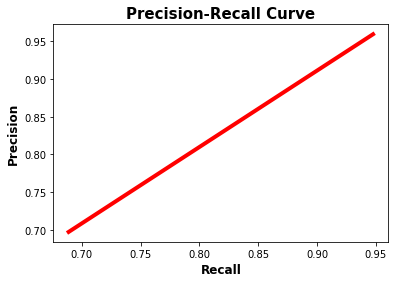

train loss epoch 26/500:   0%|          | 0/86940 [00:00<?, ?img/s]

0.7035134799986195


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.27img/s, loss=0.02418]


Validation epoch loss: 0.020801150884528625


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.52img/s, loss=0.01565]


Validation epoch loss: 0.010501956940314035


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.17img/s, loss=0.00920]


Validation epoch loss: 0.009852924903805385


validation loss: 100%|██████████| 9660/9660 [01:31<00:00, 105.35img/s, loss=0.00889]


Validation epoch loss: 0.010717576332637016


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 103.99img/s, loss=0.01664]


Validation epoch loss: 0.016152060417988837


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]


Validation round:  11%|█         | 32/302 [00:21<03:04,  1.46samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxe

Validation round:  21%|██        | 64/302 [00:36<02:25,  1.63samples/s]

truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [

Validation round:  32%|███▏      | 96/302 [00:55<02:05,  1.64samples/s]

truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(184, 1

Validation round:  42%|████▏     | 128/302 [01:13<01:44,  1.67samples/s]

truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(108,

Validation round:  53%|█████▎    | 160/302 [01:29<01:19,  1.78samples/s]

truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(59, 70, 19, 12), (1

Validation round:  64%|██████▎   | 192/302 [01:43<00:57,  1.90samples/s]

truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bb

Validation round:  74%|███████▍  | 224/302 [03:21<01:40,  1.29s/samples]

truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(0, 3,

Validation round:  85%|████████▍ | 256/302 [03:46<00:52,  1.13s/samples]

truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(6

Validation round:  95%|█████████▌| 288/302 [03:59<00:12,  1.09samples/s]

truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(57, 45, 41, 76)]
truth

Validation round: 320samples [04:14,  1.28samples/s]                    

truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105,

Validation round: 352samples [05:57,  1.52s/samples]

truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(104, 

Validation round: 384samples [06:13,  1.21s/samples]

truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(6, 88, 250, 

Validation round: 416samples [06:30,  1.00s/samples]

truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (

Validation round: 448samples [06:48,  1.14samples/s]

truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
trut

Validation round: 480samples [07:03,  1.34samples/s]

truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18,

Validation round: 512samples [07:19,  1.47samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(98, 49, 101, 129)]
t

Validation round: 544samples [07:35,  1.60samples/s]

truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(125, 45, 131, 1

Validation round: 576samples [07:49,  1.78samples/s]

truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(21, 

Validation round: 608samples [08:05,  1.81samples/s]

truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 2

Validation round: 640samples [08:21,  1.86samples/s]

truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(114, 7

Validation round: 672samples [08:35,  1.99samples/s]

truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:

Validation round: 704samples [08:49,  2.07samples/s]

truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes

Validation round: 736samples [09:02,  2.18samples/s]

truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(85,

Validation round: 768samples [09:17,  2.15samples/s]

truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(64, 99, 142, 115)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(31, 92,

Validation round: 800samples [09:34,  2.06samples/s]

truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  

Validation round: 832samples [09:47,  2.18samples/s]

truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(111, 32, 89, 189)]
tr

Validation round: 864samples [10:08,  1.92samples/s]

truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_

Validation round: 896samples [10:29,  1.78samples/s]

truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
t

Validation round: 928samples [10:47,  1.78samples/s]

truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  

Validation round: 960samples [11:04,  1.82samples/s]

truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(25, 0, 

Validation round: 992samples [11:22,  1.79samples/s]

truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(108, 105,

Validation round: 1024samples [13:07,  1.37s/samples]

truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(7

Validation round: 1056samples [13:24,  1.12s/samples]

truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(112, 69, 49, 119)]
tr

Validation round: 1088samples [13:43,  1.04samples/s]

truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(124, 59, 

Validation round: 1120samples [14:00,  1.20samples/s]

truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(14

Validation round: 1152samples [14:16,  1.36samples/s]

truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(115, 124, 115, 88)]
tr

Validation round: 1184samples [14:30,  1.56samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(66, 12

Validation round: 1216samples [14:46,  1.67samples/s]

truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(82, 129, 

Validation round: 1248samples [15:10,  1.56samples/s]

truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(105, 191, 30

Validation round: 1280samples [15:30,  1.56samples/s]

truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(

Validation round: 1312samples [15:46,  1.68samples/s]

truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(22, 32, 208, 157)]
tr

Validation round: 1344samples [16:04,  1.69samples/s]

truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(65, 92, 

Validation round: 1376samples [16:17,  1.89samples/s]

truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(56, 132, 74, 7

Validation round: 1408samples [16:40,  1.69samples/s]

truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(74

Validation round: 1440samples [16:55,  1.82samples/s]

truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(

Validation round: 1472samples [17:08,  1.96samples/s]

truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes

Validation round: 1504samples [17:25,  1.93samples/s]

truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(100, 141, 57, 61)]
truth

Validation round: 1536samples [17:42,  1.93samples/s]

truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(184, 177, 61, 49)]
tr

Validation round: 1568samples [17:59,  1.90samples/s]

truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(5

Validation round: 1600samples [18:13,  2.01samples/s]

truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(78, 3

Validation round: 1632samples [18:33,  1.85samples/s]

truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(184, 177, 61, 49)]
tr

Validation round: 1664samples [18:50,  1.86samples/s]

truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(149, 114, 97, 98)]

Validation round: 1696samples [19:09,  1.82samples/s]

truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(20, 55, 

Validation round: 1728samples [19:25,  1.86samples/s]

truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)

Validation round: 1760samples [19:51,  1.63samples/s]

truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(108, 34, 67, 22

Validation round: 1792samples [20:08,  1.70samples/s]

truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118,

Validation round: 1824samples [20:24,  1.77samples/s]

truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(5

Validation round: 1856samples [20:43,  1.73samples/s]

truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(56, 10, 152, 236)]
trut

Validation round: 1888samples [21:01,  1.75samples/s]

truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156

Validation round: 1920samples [21:20,  1.74samples/s]

truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73

Validation round: 1952samples [21:34,  1.86samples/s]

truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bb

Validation round: 1984samples [21:53,  1.80samples/s]

truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(8, 39, 65, 46),

Validation round: 2016samples [22:13,  1.76samples/s]

truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(83, 65, 108, 

Validation round: 2048samples [22:28,  1.84samples/s]

truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(85, 135, 78, 

Validation round: 2080samples [22:50,  1.71samples/s]

truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(46, 34, 162, 158)]
truth

Validation round: 2112samples [23:07,  1.76samples/s]

truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxe

Validation round: 2144samples [23:24,  1.81samples/s]

truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bbo

Validation round: 2176samples [23:35,  2.01samples/s]

truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bb

Validation round: 2208samples [23:52,  1.99samples/s]

truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_

Validation round: 2240samples [24:06,  2.06samples/s]

truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(78, 0, 121, 

Validation round: 2272samples [24:20,  2.12samples/s]

truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes

Validation round: 2304samples [24:41,  1.88samples/s]

truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(37, 76, 1

Validation round: 2336samples [24:53,  2.09samples/s]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(37, 10

Validation round: 2368samples [25:08,  2.10samples/s]

truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(7, 0, 70, 68), (5

Validation round: 2400samples [25:27,  1.94samples/s]

truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
trut

Validation round: 2432samples [25:44,  1.93samples/s]

truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(114, 103, 23, 35)]
tr

Validation round: 2464samples [26:02,  1.88samples/s]

truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_b

Validation round: 2496samples [26:26,  1.69samples/s]

truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(84, 61

Validation round: 2528samples [26:44,  1.70samples/s]

truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxe

Validation round: 2560samples [27:01,  1.77samples/s]

truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bbo

Validation round: 2592samples [27:14,  1.90samples/s]

truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(99, 128, 33, 16), (136, 1

Validation round: 2624samples [27:30,  1.95samples/s]

truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112

Validation round: 2656samples [27:45,  1.98samples/s]

truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), 

Validation round: 2688samples [28:31,  1.29samples/s]

truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (21

Validation round: 2720samples [28:45,  1.47samples/s]

truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes

Validation round: 2752samples [29:00,  1.64samples/s]

truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(133, 142, 53

Validation round: 2784samples [29:18,  1.68samples/s]

truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bb

Validation round: 2816samples [29:33,  1.79samples/s]

truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), 

Validation round: 2848samples [31:08,  1.28s/samples]

truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(89, 119, 

Validation round: 2880samples [31:23,  1.04s/samples]

truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(42, 12, 172, 70), (1

Validation round: 2912samples [31:43,  1.09samples/s]

truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(103, 51, 43, 25)]


Validation round: 2944samples [31:58,  1.27samples/s]

truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(75

Validation round: 2976samples [32:17,  1.38samples/s]

truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_

Validation round: 3008samples [32:33,  1.52samples/s]

truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [

Validation round: 3040samples [32:49,  1.65samples/s]

truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [

Validation round: 3072samples [33:05,  1.74samples/s]

truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  

Validation round: 3104samples [33:18,  1.88samples/s]

truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(

Validation round: 3136samples [33:41,  1.71samples/s]

truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bb

Validation round: 3168samples [34:08,  1.51samples/s]

truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 8

Validation round: 3200samples [34:31,  1.48samples/s]

truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:

Validation round: 3232samples [34:50,  1.53samples/s]

truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(172, 64

Validation round: 3264samples [35:04,  1.70samples/s]

truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(104, 58, 3

Validation round: 3296samples [35:21,  1.74samples/s]

truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(28, 13, 190, 

Validation round: 3328samples [35:40,  1.72samples/s]

truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(104, 

Validation round: 3360samples [35:56,  1.80samples/s]

truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]

Validation round: 3392samples [36:16,  1.73samples/s]

truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(185, 92, 18, 41)]
t

Validation round: 3424samples [36:37,  1.68samples/s]

truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(0, 0, 159

Validation round: 3456samples [36:51,  1.80samples/s]

truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(27, 68, 127, 131), (

Validation round: 3488samples [37:11,  1.75samples/s]

truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)

Validation round: 3520samples [37:30,  1.72samples/s]

truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(113, 74,

Validation round: 3552samples [37:46,  1.81samples/s]

truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(76, 36, 96, 160)]


Validation round: 3584samples [38:02,  1.87samples/s]

truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(177, 116, 34, 6

Validation round: 3616samples [38:17,  1.94samples/s]

truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(0, 82, 77, 42), (84, 11

Validation round: 3648samples [38:30,  2.05samples/s]

truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(60, 149, 13

Validation round: 3680samples [38:45,  2.08samples/s]

truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(182, 50, 42, 41)]
tr

Validation round: 3712samples [39:03,  1.98samples/s]

truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(110, 11

Validation round: 3744samples [39:17,  2.07samples/s]

truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes: 

Validation round: 3776samples [39:32,  2.08samples/s]

truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(18,

Validation round: 3808samples [39:46,  2.16samples/s]

truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  

Validation round: 3840samples [40:02,  2.09samples/s]

truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(52, 44, 149, 130)]

Validation round: 3872samples [40:20,  2.01samples/s]

truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 

Validation round: 3904samples [40:41,  1.83samples/s]

truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(

Validation round: 3936samples [40:55,  1.94samples/s]

truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(23, 161, 

Validation round: 3968samples [41:13,  1.89samples/s]

truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(45, 139, 1

Validation round: 4000samples [41:27,  1.97samples/s]

truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(103, 31, 65, 5

Validation round: 4032samples [41:41,  2.06samples/s]

truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(103

Validation round: 4064samples [41:58,  2.02samples/s]

truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_b

Validation round: 4096samples [42:15,  1.98samples/s]

truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(79, 28, 108,

Validation round: 4128samples [42:29,  2.05samples/s]

truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(88, 11

Validation round: 4160samples [42:46,  2.01samples/s]

truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(110, 1

Validation round: 4192samples [43:00,  2.07samples/s]

truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(76, 62, 111

Validation round: 4224samples [43:15,  2.09samples/s]

truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 

Validation round: 4256samples [43:36,  1.89samples/s]

truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(103, 91, 5

Validation round: 4288samples [45:17,  1.32s/samples]

truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:

Validation round: 4320samples [45:33,  1.07s/samples]

truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(79, 1

Validation round: 4352samples [45:48,  1.12samples/s]

truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bb

Validation round: 4384samples [46:14,  1.16samples/s]

truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bbo

Validation round: 4416samples [46:29,  1.33samples/s]

truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_

Validation round: 4448samples [46:45,  1.49samples/s]

truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139

Validation round: 4480samples [48:29,  1.45s/samples]

truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes: 

Validation round: 4512samples [48:47,  1.18s/samples]

truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(24, 109, 27, 12), (

Validation round: 4544samples [49:04,  1.01samples/s]

truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(23, 134, 39,

Validation round: 4576samples [49:27,  1.10samples/s]

truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxe

Validation round: 4608samples [49:44,  1.26samples/s]

truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)

Validation round: 4640samples [50:01,  1.39samples/s]

truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(

Validation round: 4672samples [50:16,  1.57samples/s]

truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
trut

Validation round: 4704samples [50:34,  1.62samples/s]

truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(44, 33, 25, 17),

Validation round: 4736samples [50:52,  1.66samples/s]

truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_

Validation round: 4768samples [51:08,  1.74samples/s]

truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 

Validation round: 4800samples [51:23,  1.85samples/s]

truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(42, 56,

Validation round: 4832samples [51:38,  1.94samples/s]

truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(90, 43, 55, 

Validation round: 4864samples [53:21,  1.33s/samples]

truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bb

Validation round: 4896samples [53:37,  1.08s/samples]

truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(87, 136, 109, 81), (19

Validation round: 4928samples [53:51,  1.12samples/s]

truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(84, 6

Validation round: 4960samples [54:05,  1.33samples/s]

truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(109, 135, 57, 41)]
tru

Validation round: 4992samples [54:20,  1.50samples/s]

truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(30, 83, 5

Validation round: 5024samples [54:34,  1.66samples/s]

truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_

Validation round: 5056samples [54:49,  1.80samples/s]

truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (

Validation round: 5088samples [55:13,  1.61samples/s]

truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(0, 110, 18, 23), (21,

Validation round: 5120samples [55:44,  1.38samples/s]

truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(120, 17, 130, 212)]
truth

Validation round: 5152samples [56:04,  1.45samples/s]

truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(

Validation round: 5184samples [56:23,  1.51samples/s]

truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(93, 90, 92, 19), (12

Validation round: 5216samples [56:44,  1.51samples/s]

truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(54, 107, 

Validation round: 5248samples [56:57,  1.72samples/s]

truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(104, 62, 90

Validation round: 5280samples [57:10,  1.89samples/s]

truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(0, 67

Validation round: 5312samples [57:28,  1.83samples/s]

truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(33, 38, 170, 

Validation round: 5344samples [57:42,  1.97samples/s]

truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96,

Validation round: 5376samples [57:56,  2.06samples/s]

truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes: 

Validation round: 5408samples [58:17,  1.85samples/s]

truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes: 

Validation round: 5440samples [58:31,  1.98samples/s]

truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 

Validation round: 5472samples [58:46,  2.02samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(154

Validation round: 5504samples [58:59,  2.14samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [

Validation round: 5536samples [59:13,  2.17samples/s]

truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bb

Validation round: 5568samples [59:31,  2.05samples/s]

truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(40, 176,

Validation round: 5600samples [59:46,  2.06samples/s]

truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(26, 83, 15, 21),

Validation round: 5632samples [1:00:07,  1.86samples/s]

truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 

Validation round: 5664samples [1:00:23,  1.89samples/s]

truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 

Validation round: 5696samples [1:00:38,  1.97samples/s]

truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(8, 34, 246, 47)]
t

Validation round: 5728samples [1:00:54,  1.97samples/s]

truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(74, 112, 118, 63)]
tr

Validation round: 5760samples [1:01:20,  1.69samples/s]

truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 2

Validation round: 5792samples [1:01:42,  1.61samples/s]

truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(91, 99

Validation round: 5824samples [1:01:56,  1.77samples/s]

truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(20, 119, 101, 83)]
trut

Validation round: 5856samples [1:02:13,  1.79samples/s]

truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(10

Validation round: 5888samples [1:02:29,  1.85samples/s]

truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [

Validation round: 5920samples [1:02:46,  1.85samples/s]

truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bbox

Validation round: 5952samples [1:03:12,  1.62samples/s]

truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(72, 26, 48, 26), (230, 2

Validation round: 5984samples [1:03:36,  1.51samples/s]

truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(7, 57

Validation round: 6016samples [1:03:54,  1.60samples/s]

truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(10

Validation round: 6048samples [1:04:12,  1.64samples/s]

truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [

Validation round: 6080samples [1:04:30,  1.67samples/s]

truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(85, 119, 102, 72)]
truth

Validation round: 6112samples [1:04:57,  1.48samples/s]

truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(149, 167, 22, 12), 

Validation round: 6144samples [1:05:14,  1.59samples/s]

truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(55, 70, 61

Validation round: 6176samples [1:05:28,  1.75samples/s]

truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 

Validation round: 6208samples [1:05:42,  1.90samples/s]

truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236

Validation round: 6240samples [1:06:02,  1.79samples/s]

truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(17, 24, 95

Validation round: 6272samples [1:06:15,  1.96samples/s]

truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(61, 1

Validation round: 6304samples [1:06:33,  1.90samples/s]

truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(56, 93, 150, 35), (111, 6

Validation round: 6336samples [1:06:49,  1.93samples/s]

truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(184, 99, 60, 10

Validation round: 6368samples [1:07:09,  1.80samples/s]

truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160

Validation round: 6400samples [1:07:28,  1.78samples/s]

truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(64, 99

Validation round: 6432samples [1:07:43,  1.86samples/s]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(172, 84, 45, 

Validation round: 6464samples [1:08:00,  1.86samples/s]

truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_

Validation round: 6496samples [1:08:21,  1.75samples/s]

truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(103, 60

Validation round: 6528samples [1:08:34,  1.93samples/s]

truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72

Validation round: 6560samples [1:08:51,  1.91samples/s]

truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(65, 156, 112, 

Validation round: 6592samples [1:09:08,  1.89samples/s]

truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(37,

Validation round: 6624samples [1:09:33,  1.66samples/s]

truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(69,

Validation round: 6656samples [1:09:54,  1.63samples/s]

truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bb

Validation round: 6688samples [1:10:08,  1.77samples/s]

truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(19, 51, 47, 

Validation round: 6720samples [1:10:21,  1.93samples/s]

truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36,

Validation round: 6752samples [1:10:46,  1.69samples/s]

truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bbo

Validation round: 6784samples [1:10:58,  1.87samples/s]

truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(91, 160, 114, 50)]
tr

Validation round: 6816samples [1:11:15,  1.90samples/s]

truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:

Validation round: 6848samples [1:11:31,  1.93samples/s]

truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(79, 88, 99, 93)]
trut

Validation round: 6880samples [1:11:45,  2.00samples/s]

truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(10, 183, 31, 10

Validation round: 6912samples [1:12:00,  2.04samples/s]

truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 

Validation round: 6944samples [1:12:16,  2.04samples/s]

truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69,

Validation round: 6976samples [1:13:52,  1.25s/samples]

truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(79, 80, 44, 41)

Validation round: 7008samples [1:14:08,  1.02s/samples]

truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes: 

Validation round: 7040samples [1:14:28,  1.11samples/s]

truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes: 

Validation round: 7072samples [1:14:44,  1.27samples/s]

truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(37, 47, 41, 64), (188, 71, 55, 93)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(60, 86, 116, 26), (9

Validation round: 7104samples [1:15:02,  1.39samples/s]

truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(1

Validation round: 7136samples [1:15:19,  1.52samples/s]

truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(32, 5, 

Validation round: 7168samples [1:15:35,  1.62samples/s]

truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(50, 83, 165, 116)]
tr

Validation round: 7200samples [1:15:53,  1.69samples/s]

truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_

Validation round: 7232samples [1:16:10,  1.73samples/s]

truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(99, 128, 33, 16

Validation round: 7264samples [1:16:35,  1.57samples/s]

truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes

Validation round: 7296samples [1:16:54,  1.60samples/s]

truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(26, 163, 5

Validation round: 7328samples [1:17:09,  1.72samples/s]

truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(43, 144, 168, 24

Validation round: 7360samples [1:17:22,  1.89samples/s]

truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(0, 104, 211, 58)]
trut

Validation round: 7392samples [1:17:42,  1.80samples/s]

truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(55, 97, 152, 37)]

Validation round: 7424samples [1:18:02,  1.75samples/s]

truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65)

Validation round: 7456samples [1:18:24,  1.64samples/s]

truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(22, 68

Validation round: 7488samples [1:18:50,  1.49samples/s]

truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(2

Validation round: 7520samples [1:19:06,  1.60samples/s]

truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxe

Validation round: 7552samples [1:19:21,  1.73samples/s]

truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(0, 20, 256, 54)]
t

Validation round: 7584samples [1:19:37,  1.82samples/s]

truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxe

Validation round: 7616samples [1:19:52,  1.91samples/s]

truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bb

Validation round: 7648samples [1:20:06,  2.00samples/s]

truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(120, 17, 130, 21

Validation round: 7680samples [1:20:19,  2.11samples/s]

truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  

Validation round: 7712samples [1:20:37,  2.03samples/s]

truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(5, 118, 102, 73)]
t

Validation round: 7744samples [1:20:52,  2.03samples/s]

truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131

Validation round: 7776samples [1:21:18,  1.70samples/s]

truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(86, 90, 42, 100), (132, 10

Validation round: 7808samples [1:21:32,  1.83samples/s]

truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(4, 57, 2

Validation round: 7840samples [1:21:45,  2.01samples/s]

truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:

Validation round: 7872samples [1:22:13,  1.64samples/s]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(62, 87, 45, 30

Validation round: 7904samples [1:22:31,  1.68samples/s]

truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(126, 139,

Validation round: 7936samples [1:22:46,  1.80samples/s]

truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57,

Validation round: 7968samples [1:23:04,  1.78samples/s]

truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(124, 134, 77, 108)]
trut

Validation round: 8000samples [1:23:19,  1.87samples/s]

truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(60

Validation round: 8032samples [1:23:44,  1.64samples/s]

truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(129, 164, 62, 57)]
truth

Validation round: 8064samples [1:24:01,  1.71samples/s]

truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(179, 137, 13,

Validation round: 8096samples [1:24:23,  1.64samples/s]

truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(63, 122, 

Validation round: 8128samples [1:24:38,  1.73samples/s]

truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_

Validation round: 8160samples [1:24:53,  1.83samples/s]

truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (1

Validation round: 8192samples [1:25:23,  1.53samples/s]

truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]


Validation round: 8224samples [1:25:46,  1.48samples/s]

truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_b

Validation round: 8256samples [1:25:59,  1.66samples/s]

truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:

Validation round: 8288samples [1:26:14,  1.79samples/s]

truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:

Validation round: 8320samples [1:26:30,  1.87samples/s]

truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(0, 19, 2

Validation round: 8352samples [1:26:47,  1.86samples/s]

truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bb

Validation round: 8384samples [1:27:06,  1.81samples/s]

truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes: 

Validation round: 8416samples [1:27:20,  1.93samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 1

Validation round: 8448samples [1:27:39,  1.84samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(38, 144, 75, 88)

Validation round: 8480samples [1:27:55,  1.89samples/s]

truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(37, 105, 11, 19)]


Validation round: 8512samples [1:28:12,  1.89samples/s]

truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  

Validation round: 8544samples [1:28:26,  1.97samples/s]

truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(47, 9

Validation round: 8576samples [1:28:39,  2.13samples/s]

truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_b

Validation round: 8608samples [1:28:56,  2.05samples/s]

truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(57, 5, 12

Validation round: 8640samples [1:29:12,  2.02samples/s]

truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]


Validation round: 8672samples [1:29:24,  2.16samples/s]

truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(70, 136, 1

Validation round: 8704samples [1:29:39,  2.18samples/s]

truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(

Validation round: 8736samples [1:29:54,  2.14samples/s]

truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(67, 13, 14, 19), (

Validation round: 8768samples [1:30:19,  1.78samples/s]

truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(161, 149, 84, 92)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(47, 12, 

Validation round: 8800samples [1:30:34,  1.89samples/s]

truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18),

Validation round: 8832samples [1:32:38,  1.54s/samples]

truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(80,

Validation round: 8864samples [1:32:55,  1.23s/samples]

truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(10

Validation round: 8896samples [1:33:18,  1.08s/samples]

truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
trut

Validation round: 8928samples [1:33:33,  1.11samples/s]

truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 

Validation round: 8960samples [1:33:58,  1.16samples/s]

truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:

Validation round: 8992samples [1:34:11,  1.38samples/s]

truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(67, 2, 107, 240)]
truth

Validation round: 9024samples [1:34:31,  1.43samples/s]

truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(82, 103, 70, 40)]
t

Validation round: 9056samples [1:34:47,  1.56samples/s]

truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(0, 

Validation round: 9088samples [1:35:02,  1.70samples/s]

truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(210, 46, 32, 2

Validation round: 9120samples [1:35:18,  1.80samples/s]

truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(175,

Validation round: 9152samples [1:35:33,  1.89samples/s]

truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25),

Validation round: 9184samples [1:35:48,  1.96samples/s]

truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(58, 70, 140

Validation round: 9216samples [1:36:04,  1.95samples/s]

truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(3, 15, 246,

Validation round: 9248samples [1:36:23,  1.88samples/s]

truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(49, 

Validation round: 9280samples [1:36:45,  1.72samples/s]

truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43,

Validation round: 9312samples [1:38:36,  1.45s/samples]

truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [

Validation round: 9344samples [1:39:03,  1.26s/samples]

truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(25, 44, 152, 166)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(24

Validation round: 9376samples [1:39:18,  1.03s/samples]

truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(68, 119, 

Validation round: 9408samples [1:39:33,  1.17samples/s]

truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162,

Validation round: 9440samples [1:39:50,  1.30samples/s]

truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_

Validation round: 9472samples [1:40:07,  1.44samples/s]

truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
tr

Validation round: 9504samples [1:40:24,  1.56samples/s]

truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes

Validation round: 9536samples [1:40:45,  1.54samples/s]

truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(40, 49, 130, 160)]
trut

Validation round: 9568samples [1:40:57,  1.77samples/s]

truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]

Validation round: 9600samples [1:41:11,  1.90samples/s]

truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(88, 

Validation round: 9632samples [1:41:25,  2.00samples/s]

truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156,

Validation round: 9660samples [1:41:47,  1.58samples/s]


Precisions: [0.9050548835908551, 0.8951268964552891, 0.8849891631126338, 0.8700971824092848, 0.8535272320492204, 0.826959379151227, 0.7854296301475215, 0.7078235335244354, 0.566874082360344]    Recalls: [0.9358056820646281, 0.9255403744668547, 0.9150581941733535, 0.8996602327766934, 0.8825272898142124, 0.855056748355382, 0.8121159546013157, 0.7318730571821008, 0.5861346056531482]    Accuracies: [0.8521492989269962, 0.8349964129654992, 0.817805918077271, 0.7931298196418329, 0.766449020592667, 0.7252882021093942, 0.6646550704058691, 0.562069731290251, 0.4048332334731376]


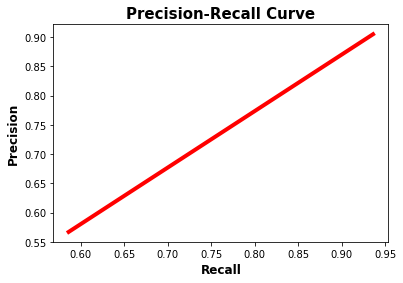

train loss epoch 31/500:   0%|          | 0/86940 [00:00<?, ?img/s]

0.6046118217054235


validation loss: 100%|██████████| 9660/9660 [01:31<00:00, 105.05img/s, loss=0.01097]


Validation epoch loss: 0.010489980007108572


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 101.89img/s, loss=0.01217]


Validation epoch loss: 0.01097028897705161


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.17img/s, loss=0.01300]


Validation epoch loss: 0.011504047766130492


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 102.86img/s, loss=0.01797]


Validation epoch loss: 0.014977893761254303


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.19img/s, loss=0.01810]


Validation epoch loss: 0.01133216301053269


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_

Validation round:  11%|█         | 32/302 [00:14<02:04,  2.18samples/s]

truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(14, 0, 

Validation round:  21%|██        | 64/302 [00:38<02:10,  1.83samples/s]

truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(37, 21, 177, 215)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(103, 85, 98, 49)]


Validation round:  32%|███▏      | 96/302 [00:55<01:52,  1.84samples/s]

truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_

Validation round:  42%|████▏     | 128/302 [01:09<01:27,  1.99samples/s]

truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(105, 161, 37, 22)]
t

Validation round:  53%|█████▎    | 160/302 [01:23<01:09,  2.04samples/s]

truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bb

Validation round:  64%|██████▎   | 192/302 [01:38<00:52,  2.08samples/s]

truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(81

Validation round:  74%|███████▍  | 224/302 [01:51<00:35,  2.19samples/s]

truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)

Validation round:  85%|████████▍ | 256/302 [02:11<00:23,  1.97samples/s]

truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth

Validation round:  95%|█████████▌| 288/302 [02:27<00:07,  1.99samples/s]

truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(82, 83, 97, 121)

Validation round: 320samples [02:46,  1.88samples/s]                    

truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(74, 81, 46, 74)]


Validation round: 352samples [03:04,  1.85samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(8, 34

Validation round: 384samples [03:22,  1.81samples/s]

truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [

Validation round: 416samples [03:37,  1.92samples/s]

truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bb

Validation round: 448samples [03:51,  1.99samples/s]

truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes: 

Validation round: 480samples [04:09,  1.92samples/s]

truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(48, 109, 2

Validation round: 512samples [04:24,  1.98samples/s]

truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:

Validation round: 544samples [04:40,  1.99samples/s]

truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(62, 42, 137, 136)]

Validation round: 576samples [05:06,  1.68samples/s]

truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(

Validation round: 608samples [05:24,  1.70samples/s]

truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(74, 128, 72, 34), (86

Validation round: 640samples [05:46,  1.63samples/s]

truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(98, 49, 

Validation round: 672samples [06:04,  1.66samples/s]

truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(89, 172, 64, 43)]
t

Validation round: 704samples [06:17,  1.85samples/s]

truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11),

Validation round: 736samples [06:41,  1.67samples/s]

truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_

Validation round: 768samples [06:58,  1.73samples/s]

truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
tr

Validation round: 800samples [08:42,  1.38s/samples]

truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17

Validation round: 832samples [09:02,  1.15s/samples]

truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(0, 0

Validation round: 864samples [09:19,  1.03samples/s]

truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(18, 8, 146

Validation round: 896samples [09:34,  1.22samples/s]

truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(0, 144, 8, 1

Validation round: 928samples [09:52,  1.35samples/s]

truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 

Validation round: 960samples [10:12,  1.42samples/s]

truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(104, 62, 90

Validation round: 992samples [10:28,  1.55samples/s]

truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes: 

Validation round: 1024samples [10:47,  1.57samples/s]

truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(100, 141, 57, 61)]

Validation round: 1056samples [11:01,  1.74samples/s]

truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(80, 57, 109, 145)]
trut

Validation round: 1088samples [11:15,  1.88samples/s]

truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(141, 15, 26,

Validation round: 1120samples [11:30,  1.94samples/s]

truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 

Validation round: 1152samples [11:43,  2.08samples/s]

truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 

Validation round: 1184samples [12:03,  1.93samples/s]

truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(1

Validation round: 1216samples [12:25,  1.74samples/s]

truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(21, 181, 59, 15), (4

Validation round: 1248samples [12:42,  1.78samples/s]

truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17),

Validation round: 1280samples [13:00,  1.78samples/s]

truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_b

Validation round: 1312samples [13:19,  1.75samples/s]

truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes

Validation round: 1344samples [13:33,  1.90samples/s]

truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bbo

Validation round: 1376samples [13:45,  2.07samples/s]

truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(137, 138, 70, 89)]
trut

Validation round: 1408samples [13:59,  2.14samples/s]

truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 2

Validation round: 1440samples [14:18,  1.99samples/s]

truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bb

Validation round: 1472samples [14:33,  2.01samples/s]

truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_b

Validation round: 1504samples [14:50,  1.98samples/s]

truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(54,

Validation round: 1536samples [15:09,  1.88samples/s]

truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(111, 103, 32, 42)]
tru

Validation round: 1568samples [15:32,  1.69samples/s]

truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(87, 10, 8

Validation round: 1600samples [15:48,  1.79samples/s]

truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [

Validation round: 1632samples [16:12,  1.62samples/s]

truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(52

Validation round: 1664samples [16:28,  1.71samples/s]

truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes: 

Validation round: 1696samples [16:40,  1.90samples/s]

truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(123, 100,

Validation round: 1728samples [16:54,  2.01samples/s]

truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [

Validation round: 1760samples [17:07,  2.12samples/s]

truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(81, 139,

Validation round: 1792samples [17:20,  2.24samples/s]

truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(145

Validation round: 1824samples [17:34,  2.23samples/s]

truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 2

Validation round: 1856samples [17:49,  2.23samples/s]

truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  

Validation round: 1888samples [18:08,  2.01samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(57, 57, 141, 106)]

Validation round: 1920samples [18:24,  2.03samples/s]

truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(47, 45,

Validation round: 1952samples [18:40,  2.01samples/s]

truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(20

Validation round: 1984samples [18:54,  2.06samples/s]

truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(163, 49, 85, 54)]
trut

Validation round: 2016samples [19:08,  2.13samples/s]

truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(116, 155, 21

Validation round: 2048samples [19:27,  2.00samples/s]

truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(29, 166, 83, 86), (119,

Validation round: 2080samples [19:46,  1.88samples/s]

truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [

Validation round: 2112samples [20:02,  1.92samples/s]

truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(179, 

Validation round: 2144samples [20:17,  1.99samples/s]

truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(53, 84, 16

Validation round: 2176samples [20:30,  2.09samples/s]

truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(78, 35, 

Validation round: 2208samples [20:46,  2.06samples/s]

truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(44, 81, 89, 1

Validation round: 2240samples [21:03,  2.03samples/s]

truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(125

Validation round: 2272samples [21:21,  1.93samples/s]

truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(41, 154, 107

Validation round: 2304samples [21:46,  1.66samples/s]

truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(97, 115,

Validation round: 2336samples [22:00,  1.83samples/s]

truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:

Validation round: 2368samples [22:12,  2.01samples/s]

truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(109, 89,

Validation round: 2400samples [22:25,  2.15samples/s]

truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (1

Validation round: 2432samples [24:04,  1.25s/samples]

truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(47, 27, 145, 76

Validation round: 2464samples [24:22,  1.05s/samples]

truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(45, 28, 168, 109)]
trut

Validation round: 2496samples [24:38,  1.13samples/s]

truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(95, 61, 62, 114)]
tr

Validation round: 2528samples [24:54,  1.30samples/s]

truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(42,

Validation round: 2560samples [25:09,  1.48samples/s]

truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bb

Validation round: 2592samples [25:24,  1.63samples/s]

truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bbox

Validation round: 2624samples [25:38,  1.78samples/s]

truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
tru

Validation round: 2656samples [25:52,  1.89samples/s]

truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(189, 45,

Validation round: 2688samples [26:09,  1.91samples/s]

truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153

Validation round: 2720samples [26:28,  1.83samples/s]

truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44

Validation round: 2752samples [26:43,  1.91samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(0, 20

Validation round: 2784samples [27:00,  1.89samples/s]

truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(25, 44, 152, 166)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(1

Validation round: 2816samples [27:14,  2.00samples/s]

truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(38, 2

Validation round: 2848samples [27:28,  2.06samples/s]

truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(37, 47, 41, 64), (188, 71, 55, 93)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(21, 92, 44, 43), (7

Validation round: 2880samples [27:45,  2.01samples/s]

truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(11, 39, 241, 8

Validation round: 2912samples [28:01,  2.02samples/s]

truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(6, 34, 250, 162)]
truth

Validation round: 2944samples [28:21,  1.87samples/s]

truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(0, 12, 184, 8

Validation round: 2976samples [28:36,  1.94samples/s]

truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:

Validation round: 3008samples [28:49,  2.07samples/s]

truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bb

Validation round: 3040samples [29:02,  2.19samples/s]

truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 

Validation round: 3072samples [29:22,  1.96samples/s]

truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(88, 65, 85, 151)]
t

Validation round: 3104samples [29:36,  2.07samples/s]

truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(79,

Validation round: 3136samples [29:50,  2.10samples/s]

truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_

Validation round: 3168samples [30:14,  1.79samples/s]

truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(55,

Validation round: 3200samples [30:39,  1.62samples/s]

truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(4, 57, 246, 132)]
t

Validation round: 3232samples [30:58,  1.62samples/s]

truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(144, 49, 36, 67

Validation round: 3264samples [31:12,  1.79samples/s]

truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bbo

Validation round: 3296samples [31:32,  1.73samples/s]

truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
tr

Validation round: 3328samples [31:48,  1.78samples/s]

truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(50, 36, 137, 115

Validation round: 3360samples [32:04,  1.85samples/s]

truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(79, 6, 

Validation round: 3392samples [32:19,  1.93samples/s]

truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:

Validation round: 3424samples [34:01,  1.32s/samples]

truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 

Validation round: 3456samples [35:46,  1.91s/samples]

truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(140, 134, 71, 40)]
tr

Validation round: 3488samples [36:01,  1.47s/samples]

truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45),

Validation round: 3520samples [36:19,  1.20s/samples]

truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_b

Validation round: 3552samples [36:44,  1.08s/samples]

truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(10, 57, 40, 46), (126,

Validation round: 3584samples [37:00,  1.11samples/s]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(26, 163, 55, 53)]

Validation round: 3616samples [37:22,  1.20samples/s]

truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(75, 68,

Validation round: 3648samples [37:39,  1.34samples/s]

truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_b

Validation round: 3680samples [37:54,  1.51samples/s]

truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(88, 81, 51, 94)]
trut

Validation round: 3712samples [38:07,  1.71samples/s]

truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(161, 149, 84, 92)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (4

Validation round: 3744samples [39:45,  1.33s/samples]

truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(61, 143, 65, 72)]


Validation round: 3776samples [40:03,  1.09s/samples]

truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(7, 95, 68, 49), (10

Validation round: 3808samples [40:19,  1.09samples/s]

truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(31, 92, 2

Validation round: 3840samples [41:56,  1.56s/samples]

truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(64, 99, 142, 115)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(6, 88, 250, 61), (103,

Validation round: 3872samples [42:23,  1.34s/samples]

truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(26, 163,

Validation round: 3904samples [42:40,  1.10s/samples]

truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(98, 80, 99, 85)]
tru

Validation round: 3936samples [42:57,  1.08samples/s]

truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(78, 0, 121, 

Validation round: 3968samples [43:11,  1.29samples/s]

truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(104, 76,

Validation round: 4000samples [43:34,  1.31samples/s]

truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(0, 24, 248,

Validation round: 4032samples [43:59,  1.30samples/s]

truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(104, 62, 90, 134)]
tru

Validation round: 4064samples [44:14,  1.48samples/s]

truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(99

Validation round: 4096samples [44:28,  1.65samples/s]

truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  

Validation round: 4128samples [44:41,  1.84samples/s]

truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(87, 130, 79, 85)]


Validation round: 4160samples [45:01,  1.76samples/s]

truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(68, 10

Validation round: 4192samples [45:17,  1.81samples/s]

truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(141, 15, 26, 2

Validation round: 4224samples [45:41,  1.65samples/s]

truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(0

Validation round: 4256samples [45:59,  1.67samples/s]

truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(25,

Validation round: 4288samples [46:16,  1.73samples/s]

truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_

Validation round: 4320samples [46:31,  1.85samples/s]

truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(151, 160, 32, 69)]


Validation round: 4352samples [46:46,  1.93samples/s]

truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_

Validation round: 4384samples [47:11,  1.66samples/s]

truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_

Validation round: 4416samples [47:28,  1.72samples/s]

truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bb

Validation round: 4448samples [47:46,  1.74samples/s]

truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12

Validation round: 4480samples [48:09,  1.63samples/s]

truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(70

Validation round: 4512samples [48:26,  1.70samples/s]

truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(104, 98

Validation round: 4544samples [48:39,  1.85samples/s]

truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(85, 97, 5

Validation round: 4576samples [48:53,  1.99samples/s]

truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
tru

Validation round: 4608samples [49:08,  2.00samples/s]

truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(133, 142

Validation round: 4640samples [49:27,  1.92samples/s]

truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(8

Validation round: 4672samples [49:43,  1.93samples/s]

truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_

Validation round: 4704samples [50:03,  1.82samples/s]

truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(17, 27, 213, 1

Validation round: 4736samples [50:22,  1.79samples/s]

truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes

Validation round: 4768samples [50:35,  1.92samples/s]

truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_b

Validation round: 4800samples [50:50,  2.01samples/s]

truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(35,

Validation round: 4832samples [51:07,  1.98samples/s]

truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(94

Validation round: 4864samples [51:31,  1.71samples/s]

truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (

Validation round: 4896samples [52:03,  1.41samples/s]

truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(90, 

Validation round: 4928samples [52:19,  1.55samples/s]

truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(134,

Validation round: 4960samples [52:32,  1.74samples/s]

truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(87, 123, 63,

Validation round: 4992samples [52:47,  1.83samples/s]

truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(66, 27, 42, 22)]
tru

Validation round: 5024samples [53:07,  1.78samples/s]

truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(

Validation round: 5056samples [53:23,  1.83samples/s]

truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(150, 26, 54,

Validation round: 5088samples [53:39,  1.89samples/s]

truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(142, 1

Validation round: 5120samples [53:53,  1.97samples/s]

truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bbox

Validation round: 5152samples [54:11,  1.93samples/s]

truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(85, 135, 78, 95)

Validation round: 5184samples [54:24,  2.06samples/s]

truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]


Validation round: 5216samples [54:44,  1.87samples/s]

truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bb

Validation round: 5248samples [54:58,  1.99samples/s]

truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(12, 102, 20, 21), (

Validation round: 5280samples [55:16,  1.94samples/s]

truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bbox

Validation round: 5312samples [55:30,  2.03samples/s]

truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bbo

Validation round: 5344samples [55:50,  1.88samples/s]

truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(123, 68, 133, 161)]

Validation round: 5376samples [56:05,  1.94samples/s]

truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(0, 142, 17, 59), (7, 

Validation round: 5408samples [56:35,  1.56samples/s]

truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 

Validation round: 5440samples [56:52,  1.64samples/s]

truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
tr

Validation round: 5472samples [57:12,  1.63samples/s]

truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_

Validation round: 5504samples [57:29,  1.69samples/s]

truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes: 

Validation round: 5536samples [57:44,  1.82samples/s]

truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(71, 81, 84, 7

Validation round: 5568samples [58:00,  1.84samples/s]

truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(

Validation round: 5600samples [58:13,  2.00samples/s]

truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(29, 37, 52,

Validation round: 5632samples [58:27,  2.09samples/s]

truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(48, 60, 162, 1

Validation round: 5664samples [58:48,  1.87samples/s]

truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bbo

Validation round: 5696samples [59:02,  1.98samples/s]

truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(48, 25, 1

Validation round: 5728samples [59:17,  2.04samples/s]

truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bbo

Validation round: 5760samples [59:34,  1.97samples/s]

truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(61, 81

Validation round: 5792samples [59:59,  1.71samples/s]

truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(150, 18

Validation round: 5824samples [1:00:15,  1.79samples/s]

truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(53, 64, 105, 65), 

Validation round: 5856samples [1:00:33,  1.78samples/s]

truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(1

Validation round: 5888samples [1:00:50,  1.81samples/s]

truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(1

Validation round: 5920samples [1:01:04,  1.92samples/s]

truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes

Validation round: 5952samples [1:01:22,  1.89samples/s]

truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(103

Validation round: 5984samples [1:01:37,  1.96samples/s]

truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(51, 48, 146, 165)]
t

Validation round: 6016samples [1:01:58,  1.79samples/s]

truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bbo

Validation round: 6048samples [1:02:14,  1.86samples/s]

truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(

Validation round: 6080samples [1:02:33,  1.79samples/s]

truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes: 

Validation round: 6112samples [1:02:49,  1.84samples/s]

truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(48, 55, 103, 171)]

Validation round: 6144samples [1:03:04,  1.92samples/s]

truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes: 

Validation round: 6176samples [1:03:18,  2.03samples/s]

truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:

Validation round: 6208samples [1:03:31,  2.12samples/s]

truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bbo

Validation round: 6240samples [1:03:46,  2.13samples/s]

truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(85, 66, 91

Validation round: 6272samples [1:04:07,  1.92samples/s]

truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_b

Validation round: 6304samples [1:04:21,  1.99samples/s]

truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(23

Validation round: 6336samples [1:04:43,  1.80samples/s]

truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 

Validation round: 6368samples [1:04:58,  1.88samples/s]

truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(15, 158

Validation round: 6400samples [1:05:14,  1.93samples/s]

truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_b

Validation round: 6432samples [1:05:28,  2.01samples/s]

truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(

Validation round: 6464samples [1:05:47,  1.92samples/s]

truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
trut

Validation round: 6496samples [1:06:00,  2.03samples/s]

truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(112, 8, 117, 127

Validation round: 6528samples [1:06:15,  2.07samples/s]

truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(89, 136, 75, 79

Validation round: 6560samples [1:06:41,  1.73samples/s]

truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(104, 41, 100, 11

Validation round: 6592samples [1:06:54,  1.89samples/s]

truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(

Validation round: 6624samples [1:07:07,  2.03samples/s]

truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64

Validation round: 6656samples [1:07:30,  1.80samples/s]

truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(143, 106, 88, 89)]
tru

Validation round: 6688samples [1:07:45,  1.86samples/s]

truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(112, 79, 57, 122)]
tru

Validation round: 6720samples [1:08:01,  1.92samples/s]

truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(77, 75, 80, 6

Validation round: 6752samples [1:08:16,  1.99samples/s]

truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(68, 28, 

Validation round: 6784samples [1:08:30,  2.04samples/s]

truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(45, 139, 149, 88),

Validation round: 6816samples [1:08:43,  2.15samples/s]

truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(96, 22, 135, 90)]
tru

Validation round: 6848samples [1:09:07,  1.83samples/s]

truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes: 

Validation round: 6880samples [1:09:21,  1.94samples/s]

truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(21, 81, 63, 16

Validation round: 6912samples [1:09:36,  2.00samples/s]

truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(40, 91, 182, 108)]
tru

Validation round: 6944samples [1:10:11,  1.47samples/s]

truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(52, 17

Validation round: 6976samples [1:10:24,  1.66samples/s]

truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(42, 58, 172, 1

Validation round: 7008samples [1:10:40,  1.76samples/s]

truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes

Validation round: 7040samples [1:10:54,  1.91samples/s]

truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 11

Validation round: 7072samples [1:12:40,  1.37s/samples]

truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 6

Validation round: 7104samples [1:13:08,  1.22s/samples]

truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(111, 

Validation round: 7136samples [1:13:24,  1.00s/samples]

truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (16

Validation round: 7168samples [1:13:42,  1.15samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(79, 6

Validation round: 7200samples [1:13:57,  1.33samples/s]

truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 

Validation round: 7232samples [1:14:16,  1.42samples/s]

truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(0, 28, 2

Validation round: 7264samples [1:14:33,  1.53samples/s]

truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 

Validation round: 7296samples [1:16:19,  1.45s/samples]

truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bb

Validation round: 7328samples [1:16:37,  1.19s/samples]

truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(26, 

Validation round: 7360samples [1:16:51,  1.05samples/s]

truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(62, 67, 129, 30), 

Validation round: 7392samples [1:17:09,  1.19samples/s]

truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bbox

Validation round: 7424samples [1:17:22,  1.41samples/s]

truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bb

Validation round: 7456samples [1:17:37,  1.58samples/s]

truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(72, 180, 45, 

Validation round: 7488samples [1:18:07,  1.37samples/s]

truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(73, 91, 1

Validation round: 7520samples [1:18:20,  1.57samples/s]

truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(71, 55, 119, 181)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(

Validation round: 7552samples [1:18:38,  1.65samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 2

Validation round: 7584samples [1:20:22,  1.41s/samples]

truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(35, 98, 179, 

Validation round: 7616samples [1:20:39,  1.14s/samples]

truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(36

Validation round: 7648samples [1:20:55,  1.05samples/s]

truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(58, 59, 128, 137)

Validation round: 7680samples [1:21:11,  1.22samples/s]

truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]

Validation round: 7712samples [1:21:27,  1.39samples/s]

truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(124, 53, 

Validation round: 7744samples [1:21:51,  1.37samples/s]

truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes: 

Validation round: 7776samples [1:22:05,  1.57samples/s]

truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bbo

Validation round: 7808samples [1:22:19,  1.73samples/s]

truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(64, 148, 31, 50), (78,

Validation round: 7840samples [1:22:34,  1.82samples/s]

truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [

Validation round: 7872samples [1:22:48,  1.93samples/s]

truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(110, 58, 51, 

Validation round: 7904samples [1:23:03,  2.02samples/s]

truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(38, 159, 25

Validation round: 7936samples [1:23:27,  1.73samples/s]

truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes: 

Validation round: 7968samples [1:23:45,  1.76samples/s]

truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(53, 70, 43, 32), (182, 2

Validation round: 8000samples [1:24:00,  1.86samples/s]

truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]

Validation round: 8032samples [1:24:17,  1.85samples/s]

truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 2

Validation round: 8064samples [1:26:02,  1.36s/samples]

truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 

Validation round: 8096samples [1:26:18,  1.10s/samples]

truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(32, 8, 6

Validation round: 8128samples [1:26:42,  1.01samples/s]

truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(77,

Validation round: 8160samples [1:26:57,  1.19samples/s]

truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 1

Validation round: 8192samples [1:27:14,  1.33samples/s]

truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxe

Validation round: 8224samples [1:27:29,  1.51samples/s]

truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(81, 36

Validation round: 8256samples [1:27:42,  1.71samples/s]

truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 

Validation round: 8288samples [1:28:12,  1.44samples/s]

truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(

Validation round: 8320samples [1:28:42,  1.31samples/s]

truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]


Validation round: 8352samples [1:28:57,  1.49samples/s]

truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(96, 73

Validation round: 8384samples [1:29:10,  1.67samples/s]

truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bbox

Validation round: 8416samples [1:29:27,  1.74samples/s]

truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes: 

Validation round: 8448samples [1:29:45,  1.74samples/s]

truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bbox

Validation round: 8480samples [1:29:59,  1.88samples/s]

truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
t

Validation round: 8512samples [1:30:22,  1.71samples/s]

truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(70, 105, 105, 57)]

Validation round: 8544samples [1:30:38,  1.79samples/s]

truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bb

Validation round: 8576samples [1:30:51,  1.95samples/s]

truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(108, 71, 61, 73)]
t

Validation round: 8608samples [1:31:06,  2.00samples/s]

truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(80, 

Validation round: 8640samples [1:31:22,  2.00samples/s]

truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7)

Validation round: 8672samples [1:31:40,  1.91samples/s]

truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(10, 143, 11,

Validation round: 8704samples [1:31:56,  1.95samples/s]

truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(94, 54, 139, 164)]
truth

Validation round: 8736samples [1:32:15,  1.87samples/s]

truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [

Validation round: 8768samples [1:32:31,  1.90samples/s]

truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14),

Validation round: 8800samples [1:32:48,  1.89samples/s]

truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(44, 119, 13,

Validation round: 8832samples [1:33:05,  1.88samples/s]

truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(117, 72, 113, 116)]
tr

Validation round: 8864samples [1:33:21,  1.92samples/s]

truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97,

Validation round: 8896samples [1:33:42,  1.79samples/s]

truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [

Validation round: 8928samples [1:33:54,  1.96samples/s]

truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_

Validation round: 8960samples [1:34:15,  1.83samples/s]

truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(153, 21, 30, 59), (215

Validation round: 8992samples [1:34:42,  1.57samples/s]

truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(9

Validation round: 9024samples [1:34:58,  1.67samples/s]

truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(88, 55, 77, 120)]
tru

Validation round: 9056samples [1:35:18,  1.66samples/s]

truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 

Validation round: 9088samples [1:35:36,  1.68samples/s]

truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(10

Validation round: 9120samples [1:35:51,  1.80samples/s]

truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes: 

Validation round: 9152samples [1:36:11,  1.73samples/s]

truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_b

Validation round: 9184samples [1:36:25,  1.87samples/s]

truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(55, 14, 148, 201)]
tru

Validation round: 9216samples [1:36:40,  1.95samples/s]

truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(0, 96, 106, 6

Validation round: 9248samples [1:36:53,  2.05samples/s]

truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bb

Validation round: 9280samples [1:37:10,  2.02samples/s]

truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(95, 102

Validation round: 9312samples [1:37:26,  2.03samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(187, 151, 27

Validation round: 9344samples [1:37:40,  2.09samples/s]

truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(27, 83, 120, 

Validation round: 9376samples [1:38:03,  1.80samples/s]

truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(85, 108, 84, 105)

Validation round: 9408samples [1:38:21,  1.79samples/s]

truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 2

Validation round: 9440samples [1:38:51,  1.50samples/s]

truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(6, 0, 17

Validation round: 9472samples [1:39:06,  1.64samples/s]

truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(49, 29, 41, 1

Validation round: 9504samples [1:39:28,  1.58samples/s]

truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(169, 86, 18, 21

Validation round: 9536samples [1:39:47,  1.61samples/s]

truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [

Validation round: 9568samples [1:40:02,  1.73samples/s]

truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164,

Validation round: 9600samples [1:40:17,  1.85samples/s]

truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes: 

Validation round: 9632samples [1:40:31,  1.94samples/s]

truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
trut

Validation round: 9660samples [1:40:45,  1.60samples/s]


Precisions: [0.945988765663258, 0.9375630131067262, 0.929641365404004, 0.9193432233904653, 0.9063085121705314, 0.8850640933314129, 0.8543857122281434, 0.7880599164626242, 0.6775889384992079]    Recalls: [0.9496132436926191, 0.9411552085592424, 0.9332032097158968, 0.9228656112195475, 0.9097809585773151, 0.8884551434974337, 0.8576592207041134, 0.7910793031157377, 0.6801850647003542]    Accuracies: [0.9007748748542824, 0.8856462585034014, 0.8716407832545577, 0.8537417240687487, 0.83157129641866, 0.7965519476310843, 0.7482812992746768, 0.6523009060562709, 0.5138722009830694]


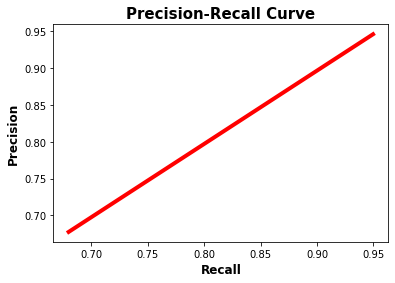

train loss epoch 36/500:   0%|          | 0/86940 [00:00<?, ?img/s]

0.6888424958949692


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.24img/s, loss=0.00921]


Validation epoch loss: 0.010485344304277605


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.30img/s, loss=0.00879]


Validation epoch loss: 0.011134939647544891


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.50img/s, loss=0.01381]


Validation epoch loss: 0.014692026341568357


validation loss: 100%|██████████| 9660/9660 [01:31<00:00, 105.56img/s, loss=0.01398]


Validation epoch loss: 0.01709464951325825


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.45img/s, loss=0.01114]


Validation epoch loss: 0.012586636604457501


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:

Validation round:  11%|█         | 32/302 [00:14<02:01,  2.23samples/s]

truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(133, 55, 67, 18)]
trut

Validation round:  21%|██        | 64/302 [00:35<02:01,  1.96samples/s]

truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(0, 0, 1

Validation round:  32%|███▏      | 96/302 [00:51<01:45,  1.95samples/s]

truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(48, 23, 1

Validation round:  42%|████▏     | 128/302 [01:08<01:29,  1.94samples/s]

truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(77, 46, 17, 29), (9

Validation round:  53%|█████▎    | 160/302 [01:25<01:13,  1.94samples/s]

truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(47, 126, 52

Validation round:  64%|██████▎   | 192/302 [01:50<01:05,  1.68samples/s]

truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(64, 148, 31, 

Validation round:  74%|███████▍  | 224/302 [02:05<00:43,  1.78samples/s]

truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(0, 25, 251, 182)]
tru

Validation round:  85%|████████▍ | 256/302 [02:21<00:24,  1.85samples/s]

truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(73

Validation round:  95%|█████████▌| 288/302 [02:39<00:07,  1.83samples/s]

truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(71, 55, 119, 181)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [

Validation round: 320samples [02:52,  1.98samples/s]                    

truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28)

Validation round: 352samples [03:09,  1.95samples/s]

truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(69, 44, 81, 122)]


Validation round: 384samples [03:22,  2.06samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(203, 108, 18, 19)]
trut

Validation round: 416samples [03:38,  2.05samples/s]

truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(170, 118, 69, 106)

Validation round: 448samples [04:05,  1.68samples/s]

truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(138, 92, 78, 

Validation round: 480samples [04:28,  1.59samples/s]

truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_

Validation round: 512samples [04:42,  1.74samples/s]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(37, 154, 

Validation round: 544samples [05:02,  1.70samples/s]

truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes

Validation round: 576samples [05:21,  1.70samples/s]

truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bbox

Validation round: 608samples [05:33,  1.89samples/s]

truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(0, 28, 25

Validation round: 640samples [05:47,  1.99samples/s]

truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bbox

Validation round: 672samples [06:02,  2.03samples/s]

truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(193,

Validation round: 704samples [06:36,  1.52samples/s]

truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_b

Validation round: 736samples [06:50,  1.68samples/s]

truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(24, 141, 94, 45)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [

Validation round: 768samples [07:18,  1.47samples/s]

truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(84, 45,

Validation round: 800samples [07:34,  1.61samples/s]

truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(154, 139, 78, 89)]


Validation round: 832samples [07:49,  1.74samples/s]

truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(73, 49, 115, 140)]
trut

Validation round: 864samples [08:04,  1.82samples/s]

truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(25, 89,

Validation round: 896samples [08:23,  1.77samples/s]

truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(79, 6, 146, 

Validation round: 928samples [08:38,  1.89samples/s]

truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(92, 111, 70, 

Validation round: 960samples [08:54,  1.93samples/s]

truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes

Validation round: 992samples [09:08,  2.01samples/s]

truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(135, 163, 28, 33), 

Validation round: 1024samples [09:24,  2.01samples/s]

truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(68, 47, 130, 166)]
t

Validation round: 1056samples [09:42,  1.91samples/s]

truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(30, 55, 1

Validation round: 1088samples [09:57,  2.00samples/s]

truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (21

Validation round: 1120samples [10:10,  2.10samples/s]

truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(61, 0, 98, 221)]


Validation round: 1152samples [10:26,  2.07samples/s]

truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(64, 

Validation round: 1184samples [10:48,  1.85samples/s]

truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(50

Validation round: 1216samples [11:03,  1.90samples/s]

truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes

Validation round: 1248samples [11:23,  1.81samples/s]

truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxe

Validation round: 1280samples [11:38,  1.90samples/s]

truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120,

Validation round: 1312samples [11:54,  1.93samples/s]

truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(70, 136, 125, 42)]
t

Validation round: 1344samples [12:09,  1.98samples/s]

truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
tr

Validation round: 1376samples [12:25,  2.00samples/s]

truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(54, 

Validation round: 1408samples [12:53,  1.64samples/s]

truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78,

Validation round: 1440samples [13:18,  1.50samples/s]

truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21

Validation round: 1472samples [13:35,  1.59samples/s]

truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(3, 91, 2

Validation round: 1504samples [13:48,  1.79samples/s]

truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(3, 91, 29

Validation round: 1536samples [14:03,  1.89samples/s]

truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(60, 86, 116, 26), (

Validation round: 1568samples [14:28,  1.65samples/s]

truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(15, 29, 220, 112

Validation round: 1600samples [14:42,  1.79samples/s]

truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bbo

Validation round: 1632samples [14:56,  1.92samples/s]

truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes: 

Validation round: 1664samples [15:21,  1.68samples/s]

truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(0, 20, 256,

Validation round: 1696samples [15:36,  1.79samples/s]

truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]

Validation round: 1728samples [15:51,  1.86samples/s]

truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(46, 29, 154, 134)]
truth

Validation round: 1760samples [16:10,  1.80samples/s]

truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(59, 11

Validation round: 1792samples [16:26,  1.87samples/s]

truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(87, 1

Validation round: 1824samples [16:44,  1.84samples/s]

truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(1

Validation round: 1856samples [16:58,  1.94samples/s]

truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(32, 140, 26, 25), (1

Validation round: 1888samples [17:14,  1.96samples/s]

truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bbo

Validation round: 1920samples [17:31,  1.95samples/s]

truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 14

Validation round: 1952samples [19:09,  1.28s/samples]

truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(85, 1

Validation round: 1984samples [19:24,  1.03s/samples]

truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(21, 15, 235, 226)]
tru

Validation round: 2016samples [19:45,  1.09samples/s]

truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (1

Validation round: 2048samples [20:00,  1.27samples/s]

truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(75, 87, 103

Validation round: 2080samples [20:22,  1.31samples/s]

truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(144, 

Validation round: 2112samples [20:37,  1.49samples/s]

truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:

Validation round: 2144samples [20:51,  1.67samples/s]

truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bbo

Validation round: 2176samples [21:08,  1.73samples/s]

truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(95, 61, 62, 114)]
trut

Validation round: 2208samples [21:24,  1.81samples/s]

truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 

Validation round: 2240samples [21:38,  1.93samples/s]

truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxe

Validation round: 2272samples [21:55,  1.92samples/s]

truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(148, 1

Validation round: 2304samples [22:12,  1.88samples/s]

truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(135, 120, 50, 30)]
tr

Validation round: 2336samples [22:28,  1.93samples/s]

truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxe

Validation round: 2368samples [22:41,  2.07samples/s]

truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(0, 1, 162

Validation round: 2400samples [22:56,  2.07samples/s]

truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bbo

Validation round: 2432samples [23:11,  2.09samples/s]

truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(111, 103, 32, 42

Validation round: 2464samples [23:25,  2.17samples/s]

truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 

Validation round: 2496samples [23:49,  1.82samples/s]

truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130,

Validation round: 2528samples [24:02,  1.96samples/s]

truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  

Validation round: 2560samples [24:21,  1.89samples/s]

truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(47, 64, 66, 52

Validation round: 2592samples [24:35,  1.99samples/s]

truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_

Validation round: 2624samples [26:15,  1.29s/samples]

truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(8, 34, 246

Validation round: 2656samples [26:29,  1.03s/samples]

truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(90, 142, 76, 73)

Validation round: 2688samples [26:44,  1.15samples/s]

truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(0, 45, 41, 39), (7, 

Validation round: 2720samples [27:05,  1.24samples/s]

truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxe

Validation round: 2752samples [27:25,  1.33samples/s]

truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_b

Validation round: 2784samples [27:40,  1.49samples/s]

truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(158, 113, 61, 126)]
t

Validation round: 2816samples [27:55,  1.65samples/s]

truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(

Validation round: 2848samples [28:11,  1.74samples/s]

truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(26, 75, 206, 33), (9

Validation round: 2880samples [28:39,  1.50samples/s]

truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(71, 155, 58, 43), (85, 

Validation round: 2912samples [29:02,  1.48samples/s]

truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bb

Validation round: 2944samples [30:43,  1.43s/samples]

truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(146

Validation round: 2976samples [31:02,  1.17s/samples]

truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  

Validation round: 3008samples [31:16,  1.05samples/s]

truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bbo

Validation round: 3040samples [31:34,  1.20samples/s]

truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(20, 3, 20

Validation round: 3072samples [33:06,  1.45s/samples]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(78, 133, 9

Validation round: 3104samples [33:30,  1.24s/samples]

truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(178, 157, 31, 32)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(44, 1

Validation round: 3136samples [33:45,  1.01s/samples]

truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(24, 43, 50, 86)]
truth

Validation round: 3168samples [33:59,  1.19samples/s]

truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34,

Validation round: 3200samples [34:18,  1.31samples/s]

truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(88, 104, 67, 3

Validation round: 3232samples [34:32,  1.50samples/s]

truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bb

Validation round: 3264samples [34:49,  1.61samples/s]

truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(31, 55

Validation round: 3296samples [35:09,  1.61samples/s]

truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_b

Validation round: 3328samples [35:24,  1.73samples/s]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(

Validation round: 3360samples [35:47,  1.61samples/s]

truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(57, 146, 18, 

Validation round: 3392samples [36:05,  1.65samples/s]

truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(59, 11

Validation round: 3424samples [36:23,  1.70samples/s]

truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(

Validation round: 3456samples [36:47,  1.57samples/s]

truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
t

Validation round: 3488samples [37:01,  1.73samples/s]

truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(137, 76, 117, 155)]
trut

Validation round: 3520samples [37:16,  1.84samples/s]

truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 3

Validation round: 3552samples [37:34,  1.82samples/s]

truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(53, 43, 15

Validation round: 3584samples [37:51,  1.83samples/s]

truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [

Validation round: 3616samples [39:34,  1.34s/samples]

truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(85, 9, 53,

Validation round: 3648samples [39:49,  1.08s/samples]

truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_b

Validation round: 3680samples [40:04,  1.11samples/s]

truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(

Validation round: 3712samples [40:24,  1.23samples/s]

truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(14, 2, 152,

Validation round: 3744samples [40:50,  1.22samples/s]

truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  

Validation round: 3776samples [41:05,  1.41samples/s]

truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(19, 171, 76, 58

Validation round: 3808samples [41:19,  1.60samples/s]

truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(57, 45, 41, 76)]
trut

Validation round: 3840samples [41:33,  1.74samples/s]

truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(46, 21

Validation round: 3872samples [41:50,  1.79samples/s]

truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bbo

Validation round: 3904samples [42:14,  1.62samples/s]

truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  

Validation round: 3936samples [42:49,  1.32samples/s]

truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(81, 1

Validation round: 3968samples [43:10,  1.38samples/s]

truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(160, 89, 56, 95

Validation round: 4000samples [43:26,  1.51samples/s]

truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_

Validation round: 4032samples [43:41,  1.65samples/s]

truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_

Validation round: 4064samples [44:01,  1.64samples/s]

truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:

Validation round: 4096samples [44:17,  1.73samples/s]

truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(6

Validation round: 4128samples [44:36,  1.72samples/s]

truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(1

Validation round: 4160samples [44:55,  1.72samples/s]

truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(0, 1

Validation round: 4192samples [46:40,  1.39s/samples]

truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(96, 126,

Validation round: 4224samples [46:57,  1.14s/samples]

truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:

Validation round: 4256samples [48:41,  1.77s/samples]

truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(99, 

Validation round: 4288samples [48:57,  1.39s/samples]

truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21,

Validation round: 4320samples [49:23,  1.21s/samples]

truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_b

Validation round: 4352samples [49:39,  1.00s/samples]

truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(33, 74, 180, 114)]
tr

Validation round: 4384samples [49:57,  1.15samples/s]

truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(94, 81, 44, 105)]
truth

Validation round: 4416samples [50:13,  1.31samples/s]

truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(23, 132, 76, 97

Validation round: 4448samples [50:27,  1.52samples/s]

truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(1

Validation round: 4480samples [50:43,  1.63samples/s]

truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(112, 

Validation round: 4512samples [50:58,  1.75samples/s]

truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(0, 110, 38, 43), (60, 1

Validation round: 4544samples [51:12,  1.89samples/s]

truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(66,

Validation round: 4576samples [51:29,  1.90samples/s]

truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26

Validation round: 4608samples [51:54,  1.64samples/s]

truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(45, 29, 97, 189)]
trut

Validation round: 4640samples [52:23,  1.44samples/s]

truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [

Validation round: 4672samples [52:39,  1.56samples/s]

truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(26, 2, 129, 249)]
tru

Validation round: 4704samples [52:54,  1.70samples/s]

truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81,

Validation round: 4736samples [53:11,  1.77samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (1

Validation round: 4768samples [53:35,  1.60samples/s]

truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(73, 53, 38, 49),

Validation round: 4800samples [53:51,  1.69samples/s]

truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(22, 12, 215, 

Validation round: 4832samples [54:08,  1.77samples/s]

truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(61, 33, 14

Validation round: 4864samples [54:26,  1.76samples/s]

truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)

Validation round: 4896samples [54:44,  1.78samples/s]

truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(118, 16, 36, 

Validation round: 4928samples [55:06,  1.65samples/s]

truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(

Validation round: 4960samples [55:23,  1.72samples/s]

truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bb

Validation round: 4992samples [55:37,  1.84samples/s]

truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes: 

Validation round: 5024samples [55:55,  1.82samples/s]

truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
t

Validation round: 5056samples [56:18,  1.68samples/s]

truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(184, 99, 60, 103)]
t

Validation round: 5088samples [56:35,  1.74samples/s]

truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_

Validation round: 5120samples [57:00,  1.56samples/s]

truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(78, 

Validation round: 5152samples [57:24,  1.50samples/s]

truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(147, 81, 

Validation round: 5184samples [57:40,  1.60samples/s]

truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(62, 4

Validation round: 5216samples [57:55,  1.75samples/s]

truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(191,

Validation round: 5248samples [58:10,  1.85samples/s]

truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(104, 76, 65, 

Validation round: 5280samples [58:28,  1.82samples/s]

truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100

Validation round: 5312samples [58:52,  1.64samples/s]

truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(174, 0, 82, 105)]
trut

Validation round: 5344samples [59:11,  1.66samples/s]

truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(73, 4

Validation round: 5376samples [59:27,  1.75samples/s]

truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(132, 9

Validation round: 5408samples [59:46,  1.72samples/s]

truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bbo

Validation round: 5440samples [1:00:02,  1.80samples/s]

truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bb

Validation round: 5472samples [1:00:17,  1.89samples/s]

truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:

Validation round: 5504samples [1:00:32,  1.95samples/s]

truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(134, 55, 45, 135

Validation round: 5536samples [1:00:47,  2.02samples/s]

truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_

Validation round: 5568samples [1:01:02,  2.04samples/s]

truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth

Validation round: 5600samples [1:01:19,  1.99samples/s]

truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(47, 13, 21, 20), (53, 9

Validation round: 5632samples [1:01:35,  1.98samples/s]

truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_b

Validation round: 5664samples [1:01:52,  1.97samples/s]

truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_b

Validation round: 5696samples [1:02:05,  2.07samples/s]

truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_b

Validation round: 5728samples [1:02:37,  1.57samples/s]

truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bbo

Validation round: 5760samples [1:02:53,  1.69samples/s]

truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(7, 0, 140, 155

Validation round: 5792samples [1:03:13,  1.65samples/s]

truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52,

Validation round: 5824samples [1:03:28,  1.77samples/s]

truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(7, 85, 230, 99)]
truth

Validation round: 5856samples [1:03:46,  1.78samples/s]

truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(158, 

Validation round: 5888samples [1:03:59,  1.95samples/s]

truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)

Validation round: 5920samples [1:04:13,  2.04samples/s]

truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(141, 151, 97,

Validation round: 5952samples [1:04:29,  2.02samples/s]

truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_

Validation round: 5984samples [1:04:42,  2.13samples/s]

truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(17, 83, 21, 2

Validation round: 6016samples [1:04:56,  2.19samples/s]

truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(0, 30, 8

Validation round: 6048samples [1:05:09,  2.25samples/s]

truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127

Validation round: 6080samples [1:05:23,  2.28samples/s]

truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(63, 27, 52, 72)]
tru

Validation round: 6112samples [1:05:50,  1.78samples/s]

truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (

Validation round: 6144samples [1:07:27,  1.30s/samples]

truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bbo

Validation round: 6176samples [1:07:40,  1.04s/samples]

truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(36, 

Validation round: 6208samples [1:07:59,  1.11samples/s]

truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49

Validation round: 6240samples [1:08:12,  1.33samples/s]

truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes

Validation round: 6272samples [1:08:29,  1.46samples/s]

truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bb

Validation round: 6304samples [1:08:45,  1.58samples/s]

truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28

Validation round: 6336samples [1:09:02,  1.67samples/s]

truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(68, 177, 34, 

Validation round: 6368samples [1:09:24,  1.59samples/s]

truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 

Validation round: 6400samples [1:09:44,  1.59samples/s]

truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(87

Validation round: 6432samples [1:10:02,  1.65samples/s]

truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(0, 67, 115, 75)

Validation round: 6464samples [1:10:19,  1.72samples/s]

truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(109, 

Validation round: 6496samples [1:10:35,  1.79samples/s]

truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(78, 66, 100, 14

Validation round: 6528samples [1:10:51,  1.86samples/s]

truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(161, 

Validation round: 6560samples [1:11:05,  1.95samples/s]

truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(

Validation round: 6592samples [1:11:20,  2.00samples/s]

truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [

Validation round: 6624samples [1:11:36,  2.01samples/s]

truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(51, 126, 76, 77)

Validation round: 6656samples [1:11:56,  1.85samples/s]

truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(55, 14, 148, 20

Validation round: 6688samples [1:12:11,  1.94samples/s]

truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(54

Validation round: 6720samples [1:12:30,  1.86samples/s]

truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(79, 155

Validation round: 6752samples [1:12:47,  1.87samples/s]

truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(79, 1

Validation round: 6784samples [1:13:06,  1.81samples/s]

truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(51, 126, 76, 77), (138,

Validation round: 6816samples [1:13:43,  1.37samples/s]

truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(26, 65, 81, 8

Validation round: 6848samples [1:13:59,  1.50samples/s]

truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes: 

Validation round: 6880samples [1:14:14,  1.64samples/s]

truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(203

Validation round: 6912samples [1:14:31,  1.71samples/s]

truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(2

Validation round: 6944samples [1:14:44,  1.89samples/s]

truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 1

Validation round: 6976samples [1:14:58,  2.00samples/s]

truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(27, 

Validation round: 7008samples [1:15:13,  2.05samples/s]

truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(

Validation round: 7040samples [1:15:32,  1.89samples/s]

truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120

Validation round: 7072samples [1:15:56,  1.69samples/s]

truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(103, 96, 64, 110)]
truth

Validation round: 7104samples [1:16:18,  1.62samples/s]

truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(89, 54, 2

Validation round: 7136samples [1:16:33,  1.73samples/s]

truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_

Validation round: 7168samples [1:16:52,  1.73samples/s]

truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(22, 18, 69, 40)]


Validation round: 7200samples [1:17:06,  1.88samples/s]

truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bbo

Validation round: 7232samples [1:18:54,  1.39s/samples]

truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(8, 4

Validation round: 7264samples [1:19:12,  1.14s/samples]

truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 7

Validation round: 7296samples [1:19:29,  1.04samples/s]

truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(38, 165, 89, 58)

Validation round: 7328samples [1:19:45,  1.22samples/s]

truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(70

Validation round: 7360samples [1:20:06,  1.30samples/s]

truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(104, 20

Validation round: 7392samples [1:20:31,  1.28samples/s]

truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth

Validation round: 7424samples [1:20:47,  1.44samples/s]

truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(55, 67, 

Validation round: 7456samples [1:21:04,  1.55samples/s]

truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(55, 163, 5

Validation round: 7488samples [1:21:19,  1.70samples/s]

truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(94, 5

Validation round: 7520samples [1:21:34,  1.82samples/s]

truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87

Validation round: 7552samples [1:21:57,  1.64samples/s]

truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 

Validation round: 7584samples [1:22:14,  1.71samples/s]

truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37)

Validation round: 7616samples [1:22:48,  1.39samples/s]

truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(112, 50, 58, 1

Validation round: 7648samples [1:23:04,  1.53samples/s]

truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(17

Validation round: 7680samples [1:23:20,  1.64samples/s]

truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(98, 113, 29

Validation round: 7712samples [1:23:37,  1.71samples/s]

truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(161, 144, 70, 103)]
t

Validation round: 7744samples [1:23:51,  1.83samples/s]

truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes: 

Validation round: 7776samples [1:24:07,  1.90samples/s]

truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82,

Validation round: 7808samples [1:24:20,  2.01samples/s]

truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(47, 45, 160, 150)]


Validation round: 7840samples [1:24:36,  2.03samples/s]

truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(28, 1

Validation round: 7872samples [1:24:57,  1.84samples/s]

truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(89, 5

Validation round: 7904samples [1:25:15,  1.83samples/s]

truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_b

Validation round: 7936samples [1:25:28,  1.98samples/s]

truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(37, 21, 177, 215)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxe

Validation round: 7968samples [1:25:47,  1.87samples/s]

truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(141, 148, 84, 81)]

Validation round: 8000samples [1:26:02,  1.94samples/s]

truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(105

Validation round: 8032samples [1:26:20,  1.89samples/s]

truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(144, 114, 31, 43), (196, 1

Validation round: 8064samples [1:26:34,  1.98samples/s]

truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 

Validation round: 8096samples [1:26:50,  2.02samples/s]

truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_b

Validation round: 8128samples [1:27:08,  1.93samples/s]

truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(46, 92, 9, 20

Validation round: 8160samples [1:27:24,  1.95samples/s]

truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175

Validation round: 8192samples [1:27:38,  2.05samples/s]

truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(68, 108, 

Validation round: 8224samples [1:27:58,  1.87samples/s]

truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(91, 160, 114, 

Validation round: 8256samples [1:28:16,  1.84samples/s]

truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(1

Validation round: 8288samples [1:28:36,  1.78samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(52, 101, 132, 69)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  

Validation round: 8320samples [1:28:53,  1.81samples/s]

truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
trut

Validation round: 8352samples [1:29:08,  1.88samples/s]

truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(51, 172

Validation round: 8384samples [1:29:30,  1.74samples/s]

truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(6, 34, 

Validation round: 8416samples [1:29:46,  1.80samples/s]

truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(19, 29, 216, 12

Validation round: 8448samples [1:30:12,  1.58samples/s]

truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxe

Validation round: 8480samples [1:30:27,  1.73samples/s]

truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(32, 66, 79, 120)]
truth

Validation round: 8512samples [1:30:43,  1.80samples/s]

truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(103, 31, 46, 

Validation round: 8544samples [1:31:01,  1.78samples/s]

truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(55, 6

Validation round: 8576samples [1:31:19,  1.77samples/s]

truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(74, 122, 17, 12), (142, 93, 14, 6)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(7, 95,

Validation round: 8608samples [1:31:36,  1.80samples/s]

truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(0

Validation round: 8640samples [1:31:55,  1.78samples/s]

truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_

Validation round: 8672samples [1:32:12,  1.80samples/s]

truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(99, 128, 33, 16), (

Validation round: 8704samples [1:32:27,  1.88samples/s]

truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(

Validation round: 8736samples [1:32:46,  1.84samples/s]

truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(161, 16, 47, 78)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(110, 50, 42, 4

Validation round: 8768samples [1:33:04,  1.81samples/s]

truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(171, 198, 63, 58)]
t

Validation round: 8800samples [1:33:19,  1.88samples/s]

truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(10, 13, 106, 76), (94,

Validation round: 8832samples [1:33:36,  1.89samples/s]

truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(58, 70, 84, 52), (19

Validation round: 8864samples [1:33:52,  1.92samples/s]

truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes

Validation round: 8896samples [1:34:12,  1.81samples/s]

truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(136, 22, 119, 68), (145,

Validation round: 8928samples [1:34:29,  1.85samples/s]

truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(147, 139, 82, 11

Validation round: 8960samples [1:34:46,  1.85samples/s]

truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(75, 121, 21, 30)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(10

Validation round: 8992samples [1:35:03,  1.85samples/s]

truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(183, 152, 38, 70)]

Validation round: 9024samples [1:35:20,  1.86samples/s]

truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bbo

Validation round: 9056samples [1:35:38,  1.84samples/s]

truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bb

Validation round: 9088samples [1:35:54,  1.88samples/s]

truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(12, 83, 71, 26),

Validation round: 9120samples [1:36:10,  1.93samples/s]

truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes

Validation round: 9152samples [1:36:29,  1.83samples/s]

truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bbox

Validation round: 9184samples [1:36:44,  1.93samples/s]

truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bbo

Validation round: 9216samples [1:36:58,  2.02samples/s]

truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(99, 128, 33, 16), (1

Validation round: 9248samples [1:37:16,  1.94samples/s]

truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (17

Validation round: 9280samples [1:37:35,  1.85samples/s]

truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(72,

Validation round: 9312samples [1:37:49,  1.96samples/s]

truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(61, 12

Validation round: 9344samples [1:38:03,  2.06samples/s]

truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxe

Validation round: 9376samples [1:38:22,  1.91samples/s]

truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(118, 

Validation round: 9408samples [1:40:02,  1.30s/samples]

truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(19, 153

Validation round: 9440samples [1:40:26,  1.14s/samples]

truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]

Validation round: 9472samples [1:40:44,  1.04samples/s]

truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(153, 123

Validation round: 9504samples [1:40:58,  1.24samples/s]

truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(25, 44, 152, 166)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes: 

Validation round: 9536samples [1:41:18,  1.34samples/s]

truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(20, 158, 141, 66), (88

Validation round: 9568samples [1:41:32,  1.53samples/s]

truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(1

Validation round: 9600samples [1:41:50,  1.59samples/s]

truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(19, 71, 93, 34),

Validation round: 9632samples [1:42:06,  1.70samples/s]

truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184,

Validation round: 9660samples [1:42:27,  1.57samples/s]

truth_bboxes:  [(98, 153, 45, 80)]
Precisions: [0.913971046616333, 0.9065595345293344, 0.9011567500173167, 0.8900048486527672, 0.8785758814158066, 0.8553716146013715, 0.8225393087206483, 0.76650273602549, 0.6586548451894438]    Recalls: [0.9538784067085954, 0.9461432805609774, 0.9405045904720596, 0.9288657558013446, 0.9169377575363262, 0.89272030651341, 0.8584544205884479, 0.7999710836405697, 0.6874141545579412]    Accuracies: [0.875290215588723, 0.8620735081016994, 0.8525557011795544, 0.83321444783088, 0.813807262928269, 0.7756422335280447, 0.7243061909118633, 0.6432225063938619, 0.5068493150684932]


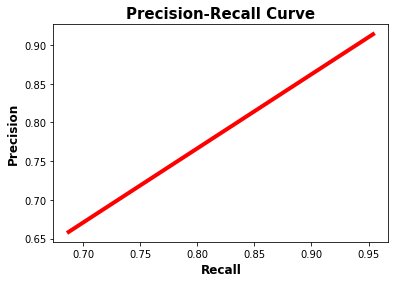

train loss epoch 41/500:   0%|          | 0/86940 [00:00<?, ?img/s]

0.6710215160637742


validation loss: 100%|██████████| 9660/9660 [01:34<00:00, 102.70img/s, loss=0.00930]


Validation epoch loss: 0.00973328453525654


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.17img/s, loss=0.01825]


Validation epoch loss: 0.01568397523724283


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 103.94img/s, loss=0.01400]


Validation epoch loss: 0.013465007566631038


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.24img/s, loss=0.01502]


Validation epoch loss: 0.011803363804514242


validation loss: 100%|██████████| 9660/9660 [01:33<00:00, 103.11img/s, loss=0.01321]


Validation epoch loss: 0.01067135520803662


Validation round:   0%|          | 0/302 [00:00<?, ?samples/s]

truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(88, 91, 76, 

Validation round:  11%|█         | 32/302 [00:14<01:59,  2.27samples/s]

truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(161, 149, 84, 92)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxe

Validation round:  21%|██        | 64/302 [00:31<01:51,  2.13samples/s]

truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes: 

Validation round:  32%|███▏      | 96/302 [00:44<01:33,  2.20samples/s]

truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(0, 12, 184, 88)]
tr

Validation round:  42%|████▏     | 128/302 [00:59<01:19,  2.18samples/s]

truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bb

Validation round:  53%|█████▎    | 160/302 [01:13<01:04,  2.20samples/s]

truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
tru

Validation round:  64%|██████▎   | 192/302 [01:27<00:48,  2.25samples/s]

truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxe

Validation round:  74%|███████▍  | 224/302 [01:40<00:33,  2.30samples/s]

truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  

Validation round:  85%|████████▍ | 256/302 [01:55<00:20,  2.27samples/s]

truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bb

Validation round:  95%|█████████▌| 288/302 [02:08<00:06,  2.29samples/s]

truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]

Validation round: 320samples [02:26,  2.11samples/s]                    

truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35,

Validation round: 352samples [03:56,  1.18s/samples]

truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(184, 177, 61, 49)]

Validation round: 384samples [04:18,  1.03s/samples]

truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17,

Validation round: 416samples [04:32,  1.17samples/s]

truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(87, 90, 85, 

Validation round: 448samples [04:46,  1.38samples/s]

truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [

Validation round: 480samples [05:01,  1.55samples/s]

truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(91, 51, 29

Validation round: 512samples [05:17,  1.65samples/s]

truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(33, 

Validation round: 544samples [05:35,  1.69samples/s]

truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 1

Validation round: 576samples [05:51,  1.78samples/s]

truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(42, 0, 59, 120)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_

Validation round: 608samples [06:04,  1.93samples/s]

truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(65, 1

Validation round: 640samples [06:20,  1.94samples/s]

truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(78, 133, 99, 34)]
truth_bboxes

Validation round: 672samples [06:45,  1.69samples/s]

truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (162, 93, 17, 12), (196, 93, 11, 3), (221, 95, 6, 9)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40,

Validation round: 704samples [08:15,  1.26s/samples]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(55, 36, 25, 16)]


Validation round: 736samples [08:32,  1.04s/samples]

truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_

Validation round: 768samples [09:01,  1.00samples/s]

truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(10

Validation round: 800samples [09:16,  1.19samples/s]

truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bbox

Validation round: 832samples [09:34,  1.32samples/s]

truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes: 

Validation round: 864samples [09:51,  1.46samples/s]

truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_

Validation round: 896samples [10:17,  1.38samples/s]

truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(123

Validation round: 928samples [10:36,  1.45samples/s]

truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(114, 106, 26, 3

Validation round: 960samples [10:51,  1.61samples/s]

truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(51, 172,

Validation round: 992samples [11:04,  1.81samples/s]

truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(23, 41, 207, 205)]
trut

Validation round: 1024samples [11:27,  1.64samples/s]

truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bb

Validation round: 1056samples [11:40,  1.84samples/s]

truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes: 

Validation round: 1088samples [12:06,  1.61samples/s]

truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(97,

Validation round: 1120samples [12:20,  1.76samples/s]

truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
t

Validation round: 1152samples [12:37,  1.77samples/s]

truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(42, 98, 167, 59)]
tr

Validation round: 1184samples [12:54,  1.81samples/s]

truth_bboxes:  [(67, 27, 104, 45)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25)

Validation round: 1216samples [13:16,  1.69samples/s]

truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bb

Validation round: 1248samples [13:33,  1.74samples/s]

truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  

Validation round: 1280samples [13:48,  1.86samples/s]

truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(21, 146, 68, 88)]
truth_bboxes:  [(132, 90, 74, 109)]
tru

Validation round: 1312samples [14:03,  1.92samples/s]

truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143

Validation round: 1344samples [15:32,  1.20s/samples]

truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_

Validation round: 1376samples [15:50,  1.01s/samples]

truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bbox

Validation round: 1408samples [16:13,  1.09samples/s]

truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 13

Validation round: 1440samples [16:32,  1.21samples/s]

truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217,

Validation round: 1472samples [16:47,  1.39samples/s]

truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bb

Validation round: 1504samples [17:00,  1.60samples/s]

truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxe

Validation round: 1536samples [17:23,  1.53samples/s]

truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_b

Validation round: 1568samples [17:40,  1.64samples/s]

truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(40, 79, 96, 74)]
tr

Validation round: 1600samples [17:54,  1.77samples/s]

truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_

Validation round: 1632samples [18:07,  1.95samples/s]

truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(100, 

Validation round: 1664samples [18:22,  2.01samples/s]

truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(87, 130, 79, 85)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(56, 146, 84, 28

Validation round: 1696samples [18:35,  2.10samples/s]

truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(2

Validation round: 1728samples [18:56,  1.89samples/s]

truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(72, 26, 48, 26), (230

Validation round: 1760samples [19:11,  1.95samples/s]

truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(143, 89, 86, 23), (182

Validation round: 1792samples [19:26,  2.01samples/s]

truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 

Validation round: 1824samples [19:41,  2.04samples/s]

truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bb

Validation round: 1856samples [19:57,  2.05samples/s]

truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(15, 40, 229, 96)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(116, 114, 26, 24), (138, 5, 76, 46)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(

Validation round: 1888samples [20:17,  1.89samples/s]

truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108,

Validation round: 1920samples [20:41,  1.68samples/s]

truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(16, 59, 60, 134), (165, 24, 63, 124)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(33, 14, 15

Validation round: 1952samples [20:54,  1.84samples/s]

truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(103, 169, 21, 32

Validation round: 1984samples [21:06,  2.04samples/s]

truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  

Validation round: 2016samples [21:27,  1.86samples/s]

truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(16, 23, 194, 96)]
trut

Validation round: 2048samples [22:56,  1.21s/samples]

truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(7, 125, 15, 24), (26,

Validation round: 2080samples [23:32,  1.19s/samples]

truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(0, 159, 148, 97), (45, 139, 10, 15), (77, 110, 32, 35), (125, 95, 40, 76), (169, 98, 80, 50)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_

Validation round: 2112samples [23:48,  1.02samples/s]

truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3

Validation round: 2144samples [24:00,  1.24samples/s]

truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(23, 132, 

Validation round: 2176samples [24:19,  1.35samples/s]

truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(75, 182, 49, 59), (130, 16, 106, 79), (132, 118, 101, 81)]
truth_bboxes:  [(32, 5, 190, 223)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(70, 88, 118, 67)

Validation round: 2208samples [24:36,  1.48samples/s]

truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(103, 17

Validation round: 2240samples [24:50,  1.65samples/s]

truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(20, 161, 29, 64), (51, 111, 79, 134)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(110, 58, 51, 26)]
tr

Validation round: 2272samples [25:06,  1.76samples/s]

truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxe

Validation round: 2304samples [25:23,  1.79samples/s]

truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(8

Validation round: 2336samples [25:39,  1.85samples/s]

truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(0, 142, 17, 59

Validation round: 2368samples [25:57,  1.83samples/s]

truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(76, 62, 111, 32)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(106, 1

Validation round: 2400samples [26:11,  1.93samples/s]

truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(41, 109, 161, 81)]
truth

Validation round: 2432samples [26:27,  1.95samples/s]

truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes:  [(67, 52, 124, 160)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxe

Validation round: 2464samples [26:40,  2.08samples/s]

truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bbo

Validation round: 2496samples [26:56,  2.07samples/s]

truth_bboxes:  [(121, 107, 123, 149)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(65, 74, 69, 22), (151, 79, 36, 40)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(21

Validation round: 2528samples [27:14,  1.98samples/s]

truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(45, 10, 118, 153)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(118, 113, 22, 35)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(79, 129

Validation round: 2560samples [27:31,  1.92samples/s]

truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(64, 99, 142, 115)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(186, 80, 50, 38)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(146, 75, 45, 32)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bbox

Validation round: 2592samples [27:44,  2.07samples/s]

truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_b

Validation round: 2624samples [27:59,  2.09samples/s]

truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(92, 117, 68, 66)

Validation round: 2656samples [28:21,  1.83samples/s]

truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(35, 98, 179, 68), (127, 55, 57, 57)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(84, 45, 37, 31), (137,

Validation round: 2688samples [28:36,  1.93samples/s]

truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(86, 100, 80, 92)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(20, 55, 28, 52), (51

Validation round: 2720samples [28:53,  1.90samples/s]

truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(47, 196, 44, 55), (164, 0, 51, 65)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (

Validation round: 2752samples [29:16,  1.72samples/s]

truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(10

Validation round: 2784samples [29:33,  1.78samples/s]

truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(48, 109, 27, 30)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 1

Validation round: 2816samples [29:51,  1.77samples/s]

truth_bboxes:  [(203, 108, 18, 19)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(55, 36, 25, 16)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bb

Validation round: 2848samples [30:07,  1.84samples/s]

truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(27, 83, 120, 139)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(95, 53, 46, 19), (149,

Validation round: 2880samples [30:27,  1.74samples/s]

truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  

Validation round: 2912samples [30:48,  1.68samples/s]

truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(13, 52, 218, 121)]

Validation round: 2944samples [31:04,  1.75samples/s]

truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 

Validation round: 2976samples [31:19,  1.87samples/s]

truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(93, 139, 61, 57)]
truth_bboxes:  [(58, 79, 158, 79)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(12, 73, 71

Validation round: 3008samples [31:33,  1.96samples/s]

truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxe

Validation round: 3040samples [31:46,  2.10samples/s]

truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(105, 57, 28, 44)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(5, 169, 49, 76)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(48, 111

Validation round: 3072samples [32:10,  1.78samples/s]

truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(21

Validation round: 3104samples [32:29,  1.77samples/s]

truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(0, 142, 17, 59), (7, 52, 40, 53), (49, 115, 45, 116), (76, 29, 35, 47), (135, 16, 37, 55), (139, 88, 50, 81), (201, 47, 49, 171)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(

Validation round: 3136samples [32:48,  1.75samples/s]

truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(68, 

Validation round: 3168samples [33:02,  1.87samples/s]

truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(165, 94, 49, 60)]
truth_bboxes:  [(40,

Validation round: 3200samples [33:15,  1.99samples/s]

truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(90, 103, 59, 24), (111, 68, 19, 33)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(27, 68, 127

Validation round: 3232samples [33:32,  1.98samples/s]

truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(6, 34, 250, 162)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 

Validation round: 3264samples [33:57,  1.68samples/s]

truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(116, 29, 54, 92)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(13, 0, 243, 138)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(6,

Validation round: 3296samples [34:16,  1.69samples/s]

truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(65, 92, 112, 75)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(83, 174, 78, 49)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(60, 149, 133, 58)]


Validation round: 3328samples [34:33,  1.74samples/s]

truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_

Validation round: 3360samples [34:47,  1.88samples/s]

truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(56, 142, 69, 48), (60, 81, 20, 61)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106

Validation round: 3392samples [35:05,  1.85samples/s]

truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(68, 28, 145, 192)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(7, 85

Validation round: 3424samples [35:25,  1.77samples/s]

truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bbox

Validation round: 3456samples [35:37,  1.97samples/s]

truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_b

Validation round: 3488samples [35:52,  2.03samples/s]

truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(0, 1, 256, 202)]
trut

Validation round: 3520samples [36:10,  1.94samples/s]

truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(88, 65, 85, 151)]
truth

Validation round: 3552samples [36:31,  1.80samples/s]

truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(52, 116, 43, 55)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(95, 75, 78, 121)]
trut

Validation round: 3584samples [36:48,  1.80samples/s]

truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(25, 44, 152, 166)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(23, 12, 84, 131)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (1

Validation round: 3616samples [37:09,  1.73samples/s]

truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 

Validation round: 3648samples [37:30,  1.65samples/s]

truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(137, 139, 74, 89), (163, 69, 25, 19)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bbox

Validation round: 3680samples [37:46,  1.75samples/s]

truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(122, 129, 106, 116)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(67, 64, 42, 100)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), 

Validation round: 3712samples [38:04,  1.75samples/s]

truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(10

Validation round: 3744samples [38:17,  1.93samples/s]

truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(65, 156, 112, 70)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(1

Validation round: 3776samples [38:30,  2.03samples/s]

truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(20, 107, 226, 126)]
truth_bboxes:  [(90, 132, 100, 76)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(17, 11, 221, 239)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(117, 204, 35, 31)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(9, 69, 48, 103), (109, 1

Validation round: 3808samples [38:47,  2.00samples/s]

truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(125, 45, 131, 100)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxe

Validation round: 3840samples [39:02,  2.04samples/s]

truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(17, 3, 207, 185)]
t

Validation round: 3872samples [39:18,  2.01samples/s]

truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(39, 47, 177, 172)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(48, 60, 162, 171)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(116, 114,

Validation round: 3904samples [39:33,  2.08samples/s]

truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(4, 66, 250, 120)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(171, 81, 26, 31)]
tr

Validation round: 3936samples [39:48,  2.09samples/s]

truth_bboxes:  [(145, 69, 52, 119)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(0, 63, 49, 79), (55, 0, 33, 40), (73, 148, 117, 89), (188, 41, 68, 83)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(76, 109, 14

Validation round: 3968samples [40:01,  2.16samples/s]

truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(68, 109, 29, 47)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(20, 158, 141, 66), (88, 136, 34, 49)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes

Validation round: 4000samples [40:17,  2.11samples/s]

truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [

Validation round: 4032samples [40:32,  2.14samples/s]

truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 1

Validation round: 4064samples [40:54,  1.88samples/s]

truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_b

Validation round: 4096samples [41:11,  1.87samples/s]

truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95

Validation round: 4128samples [41:29,  1.83samples/s]

truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bbo

Validation round: 4160samples [41:46,  1.86samples/s]

truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(62, 42, 137, 136)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(119, 96, 29, 65)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(138, 

Validation round: 4192samples [42:00,  1.97samples/s]

truth_bboxes:  [(32, 48, 69, 78)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35

Validation round: 4224samples [42:28,  1.62samples/s]

truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(53, 70, 43, 32), (182, 212, 20, 15)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 3

Validation round: 4256samples [44:04,  1.33s/samples]

truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(31, 151, 7, 6), (80, 152, 14, 4), (138, 108, 39, 21)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(80,

Validation round: 4288samples [44:18,  1.07s/samples]

truth_bboxes:  [(108, 131, 15, 12), (166, 101, 14, 6)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(89, 172, 64, 43)]
trut

Validation round: 4320samples [44:32,  1.14samples/s]

truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(108, 71, 61, 73)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(96, 22, 135, 90)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(138, 92, 78, 86

Validation round: 4352samples [44:47,  1.33samples/s]

truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(10, 64, 233, 119)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(213, 116

Validation round: 4384samples [45:00,  1.53samples/s]

truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_b

Validation round: 4416samples [45:15,  1.67samples/s]

truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(61, 157, 31, 44), (154, 70, 26, 45)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(144, 114, 31, 43), (196, 121, 23, 43)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(71, 155, 58,

Validation round: 4448samples [45:31,  1.77samples/s]

truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(44, 53, 163, 114)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(72, 95, 109, 58)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(59, 118, 72, 56)]
trut

Validation round: 4480samples [45:46,  1.85samples/s]

truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(121, 128, 38, 45)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(61, 82, 92, 52)]
truth_bboxes:  [(40, 176

Validation round: 4512samples [46:02,  1.92samples/s]

truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(37, 67, 127, 141)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(70, 49, 53, 145)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(85, 66, 91, 58)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(53, 77, 142

Validation round: 4544samples [46:15,  2.03samples/s]

truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(23, 161, 72, 93)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(25, 142, 39, 87)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(39, 1

Validation round: 4576samples [46:29,  2.10samples/s]

truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(142, 126, 92, 76)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(33, 54, 31, 62)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(114, 77, 31

Validation round: 4608samples [46:46,  2.03samples/s]

truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(107, 94, 38, 58)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(52, 44, 149, 130)]
truth_bboxes:  [(197, 154, 14, 71)]
trut

Validation round: 4640samples [47:25,  1.42samples/s]

truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (

Validation round: 4672samples [47:40,  1.57samples/s]

truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(64, 64, 118, 55)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(38, 165, 89, 58)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(23, 134, 39, 30),

Validation round: 4704samples [47:55,  1.71samples/s]

truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(0, 40, 23, 20), (0, 185, 24, 18), (152, 187, 27, 22), (181, 36, 70, 67)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(97, 182, 23, 17), (144, 189, 22, 9), (154, 197, 4, 7)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes: 

Validation round: 4736samples [48:15,  1.67samples/s]

truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(22, 61, 107, 124), (1

Validation round: 4768samples [48:30,  1.80samples/s]

truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(26, 1

Validation round: 4800samples [48:45,  1.87samples/s]

truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(31, 76, 163, 179)]
truth_bboxes:  [(33, 74, 180, 114)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(103, 86, 66, 62)]
truth_bboxes:  [(53, 81, 16, 23), (164, 76, 5, 15)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(31, 92, 28, 11), (53, 52, 107, 25), (66, 92, 10, 3), (101, 93, 9, 3), (139, 93, 12, 3), (1

Validation round: 4832samples [49:01,  1.90samples/s]

truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(61, 0, 98, 221)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(138, 100, 118, 156)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bbo

Validation round: 4864samples [49:15,  2.01samples/s]

truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(14, 161, 34, 45)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(165, 115, 57, 70)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(21, 60, 52

Validation round: 4896samples [49:39,  1.75samples/s]

truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_

Validation round: 4928samples [49:53,  1.88samples/s]

truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(59, 55, 33, 63)]
truth_bboxes:  [(88, 55, 97, 156)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(89, 89, 84, 68)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(151,

Validation round: 4960samples [50:09,  1.90samples/s]

truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(79, 88, 51, 33)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(97, 63, 128, 169)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(67, 135, 113, 94)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(12, 73, 71, 52), (92, 49, 93, 85)]
truth_bboxes:  [(185, 35, 36, 75)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(75, 91, 12, 16), (183, 3, 20, 26)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(34, 70, 189, 112)

Validation round: 4992samples [50:27,  1.87samples/s]

truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(0, 0, 86, 246), (71, 0, 158, 244), (216, 84, 16, 137), (235, 0, 21, 233)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(0, 96, 106

Validation round: 5024samples [50:44,  1.89samples/s]

truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(74, 81, 46, 74)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(54, 41, 115, 96), (197, 45, 58, 64)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(58, 22, 92, 210)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(136, 120, 120, 136)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(29, 37, 52, 48), (161, 32, 81, 49)]
truth_bboxes:  [(169, 86, 1

Validation round: 5056samples [50:57,  2.01samples/s]

truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(60, 31, 116, 175)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(162, 58, 31, 47)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(47, 86, 100, 26)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:  [(114, 103, 23, 35)]
truth_bboxes:  [(216, 30, 26, 40)]
truth_bboxes:  [(6, 88, 250, 61), (103, 17, 67, 65)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(52, 151, 109, 91)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bbox

Validation round: 5088samples [51:12,  2.04samples/s]

truth_bboxes:  [(32, 69, 151, 44)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(123, 68, 133, 161)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(154, 139, 78, 89)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(40, 15, 183, 241)]
truth

Validation round: 5120samples [51:29,  2.01samples/s]

truth_bboxes:  [(78, 116, 22, 24)]
truth_bboxes:  [(106, 194, 105, 57)]
truth_bboxes:  [(86, 67, 84, 122)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(47, 23, 181, 221)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(35, 48, 174, 83)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(19, 102, 129, 45), (58, 55, 41, 44)]
truth_bboxes:  [(42, 58, 172, 145)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bbo

Validation round: 5152samples [51:43,  2.07samples/s]

truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 4

Validation round: 5184samples [52:06,  1.80samples/s]

truth_bboxes:  [(79, 76, 113, 96)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(88, 68, 24, 37)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(85, 197, 78, 49)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(73, 186, 59, 55), (140, 188, 60, 54)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(56, 10, 152, 236)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bb

Validation round: 5216samples [52:20,  1.95samples/s]

truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(103, 91, 51, 75)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(107, 68, 51, 68)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(143, 100, 23, 16)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29,

Validation round: 5248samples [52:34,  2.01samples/s]

truth_bboxes:  [(27, 68, 127, 131), (170, 67, 82, 120)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(8, 47, 236, 100)]
tru

Validation round: 5280samples [52:48,  2.09samples/s]

truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(96, 100, 41, 66)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(110, 111, 117, 90)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(109, 66, 60, 30

Validation round: 5312samples [53:03,  2.13samples/s]

truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(42, 12, 172, 70), (142, 134, 46, 17)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(50, 0, 154, 104)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(114, 65, 39, 63)]
truth_

Validation round: 5344samples [53:19,  2.09samples/s]

truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(8, 145, 77, 111)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 18, 17), (100, 145, 72, 18), (127, 122, 22, 22), (178, 182, 55, 15), (199, 164, 17, 18)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bbo

Validation round: 5376samples [53:46,  1.68samples/s]

truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(57, 112, 54, 72), (139, 55, 58, 22)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(69, 160, 50, 60), (159, 169, 64, 71)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(0, 49

Validation round: 5408samples [54:02,  1.78samples/s]

truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(150, 187, 59, 60)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(60, 92, 135, 31), (112, 66, 32, 31)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(49, 95, 60, 10

Validation round: 5440samples [54:20,  1.78samples/s]

truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(47, 12, 6, 9), (80, 96, 5, 9), (155, 0, 13, 17), (161, 24, 30, 58)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
trut

Validation round: 5472samples [54:37,  1.79samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(97, 8, 33, 55), (142, 26, 24, 42)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(66, 48, 122, 173)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(133, 130, 67, 5

Validation round: 5504samples [54:50,  1.97samples/s]

truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(0, 1, 162, 239)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(182, 52, 64, 51)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14

Validation round: 5536samples [55:08,  1.92samples/s]

truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(5, 31, 167, 159)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(130, 50, 29, 27)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(42, 98, 167, 59)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(45, 149, 18, 22), (129, 97, 15, 21), (169, 50, 39, 45)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(24, 109, 27, 12), (15

Validation round: 5568samples [55:26,  1.85samples/s]

truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(144, 101, 74, 86)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(33, 112, 63, 79)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(82, 75, 44, 38)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(162, 93, 77, 145)]


Validation round: 5600samples [55:45,  1.82samples/s]

truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(142, 130, 96, 39)]
truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(153, 127, 77, 44), (192, 95, 25, 44)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(54, 26, 122, 170)]
truth_bboxes:  [(108, 120, 77, 102)]
truth

Validation round: 5632samples [56:01,  1.87samples/s]

truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(38, 159, 25, 29), (163, 30, 64, 68)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(54, 175

Validation round: 5664samples [56:25,  1.66samples/s]

truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(11, 54, 115, 126)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(0, 131, 256, 125)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(7, 125, 15, 24), (26, 99, 25, 25), (35, 140, 25, 27), (55, 80, 25, 18), (65, 114, 25, 26), (94, 87, 28, 27), (107, 130, 28, 29), (126, 72, 26, 13), (139, 103, 28, 27), (171, 75, 28, 27), (186, 120, 29, 29), (218, 91, 23, 30)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]

Validation round: 5696samples [56:52,  1.48samples/s]

truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(22, 32, 30, 57), (111, 143, 7, 15), (135, 142, 15, 16)]
truth_bboxes:  [(99, 4, 96, 186)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(47, 64, 66, 52), (139, 125, 83, 61), (157, 53, 26, 14)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(53, 84, 165, 128)]
truth

Validation round: 5728samples [57:09,  1.59samples/s]

truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(51, 85, 153, 95)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(64, 155, 144, 92)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(80, 93, 30, 47), (168, 102, 45, 23)]
truth_

Validation round: 5760samples [57:22,  1.78samples/s]

truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), 

Validation round: 5792samples [57:38,  1.84samples/s]

truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(81, 84, 100, 79)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(0, 0, 256, 231)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(78, 35, 78, 90)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(126, 99, 43, 39)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(64, 116, 110, 70)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  

Validation round: 5824samples [57:55,  1.84samples/s]

truth_bboxes:  [(56, 146, 84, 28)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(93, 92, 79, 38)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(25, 89, 63, 76)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(179, 137, 13, 8)]
truth_bboxes: 

Validation round: 5856samples [58:13,  1.82samples/s]

truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(45, 19, 140, 35)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(105, 98, 42, 63)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(47, 27, 145, 76)]
truth_bboxes:  [(0, 91, 256, 165)]
truth_bboxes:  [(39, 84, 50, 41)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(132, 90, 74, 109)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 12

Validation round: 5888samples [58:28,  1.90samples/s]

truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(76, 45, 122, 176)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11),

Validation round: 5920samples [58:44,  1.94samples/s]

truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(55, 163, 52, 53),

Validation round: 5952samples [59:01,  1.93samples/s]

truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(77, 96, 14, 21)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(101, 130, 45, 34)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(94, 69, 65, 117)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(33, 27, 182, 124)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(82

Validation round: 5984samples [59:16,  1.99samples/s]

truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(141, 15, 26, 27), (165, 159, 37, 31)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(3, 15, 246, 225)]
truth_bboxes:  [(103, 97, 62, 43)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(20, 70, 202, 102)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(21, 112, 15, 19)]


Validation round: 6016samples [59:31,  2.00samples/s]

truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30, 27)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(79, 6, 146, 218)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bboxes:  [(147, 143, 33, 65)]
truth_bboxes:  [(38, 97, 29, 33)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(19, 71, 93, 34), (221, 111, 16, 12)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(177, 116, 34, 67), (

Validation round: 6048samples [59:45,  2.08samples/s]

truth_bboxes:  [(53, 109, 30, 25), (54, 59, 29, 26), (87, 171, 30, 16), (106, 105, 34, 29), (128, 50, 33, 21), (171, 136, 33, 15), (189, 99, 26, 17)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), (51, 34, 14, 7), (70, 125, 41, 63), (123, 67, 56, 22), (190, 133, 49, 63)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(100, 169, 41, 47)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxe

Validation round: 6080samples [1:01:21,  1.23s/samples]

truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(62, 4, 132, 204)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(100, 68, 32, 47), (109, 123, 46, 62)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(76, 58, 127, 150)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(133, 55, 67, 18)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(96, 22, 135, 90)]
trut

Validation round: 6112samples [1:01:37,  1.01s/samples]

truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(37, 14, 105, 171)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(55, 14, 148, 201)]
truth_bboxes:  [(129, 78, 17, 28)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(112, 79, 57, 122

Validation round: 6144samples [1:01:54,  1.16samples/s]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(91, 99, 77, 62)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(7, 61, 246, 83)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(79, 62, 98, 58)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(15, 189,

Validation round: 6176samples [1:02:07,  1.36samples/s]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(25, 

Validation round: 6208samples [1:02:26,  1.44samples/s]

truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(8, 97, 165, 116)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(72, 85, 114, 112)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(95, 75, 78, 121)]
tru

Validation round: 6240samples [1:02:40,  1.62samples/s]

truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(94, 92, 85, 77)

Validation round: 6272samples [1:03:02,  1.57samples/s]

truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(110, 125, 56, 72)]
truth_bboxes:  [(107, 62, 45, 45)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(89, 69, 31, 19)]
truth_bboxes:  [(94, 116, 52, 31)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(46, 34, 162, 158)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(31, 68, 32, 12), (136, 53, 19, 7)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(48, 144, 41, 41), (129, 125, 117, 107)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(104, 9

Validation round: 6304samples [1:03:16,  1.73samples/s]

truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(36, 25, 118, 180)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(40, 79, 96, 74)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(138, 51, 40, 43)]
truth_bboxes:  [(57, 113, 9, 12), (157, 7, 34, 38), (205, 9, 17, 38), (230, 75, 11, 27)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(100, 89, 59, 87)]
truth_bboxes:  [(97, 89, 40, 37)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(85, 47, 87, 38)]

Validation round: 6336samples [1:03:31,  1.83samples/s]

truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(7, 67, 244, 132)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(60, 133, 49, 35), (138, 103, 27, 19)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(123, 100, 11, 21)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(117, 52, 27, 35)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(96, 126, 69

Validation round: 6368samples [1:03:47,  1.91samples/s]

truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(50, 155, 45, 69)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(2, 35, 254, 113)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(50, 77, 40, 71), (144, 102, 8, 15)]
truth_bboxes:  [(145, 98, 46, 82)]
truth_b

Validation round: 6400samples [1:04:03,  1.93samples/s]

truth_bboxes:  [(37, 130, 46, 78), (38, 22, 26, 14)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(21, 181, 59, 15), (42, 164, 1

Validation round: 6432samples [1:04:32,  1.57samples/s]

truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(108, 57, 30, 24), (114, 185, 37, 25)]
truth_bboxes:  [(129, 164, 62, 57)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(84, 90, 20, 29)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(53, 138, 49, 56)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(9

Validation round: 6464samples [1:04:48,  1.68samples/s]

truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(61, 40, 130, 193)]
truth_bboxes:  [(113, 54, 113, 118)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(147, 81, 48, 22)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(74, 152, 39, 54)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(87, 158, 56, 63)]
truth_bboxes:  [(141, 161, 30, 46)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(8

Validation round: 6496samples [1:05:05,  1.74samples/s]

truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(78, 119, 89, 35), (104, 53, 42, 17)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(41, 154, 107, 49), (91, 130, 23, 37)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226,

Validation round: 6528samples [1:05:22,  1.78samples/s]

truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(109, 29, 50, 39)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(105, 161, 76, 95)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(135, 163, 28, 33), (142, 107, 13, 16), (179, 109, 27, 30)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(50, 67, 122, 131)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 

Validation round: 6560samples [1:05:38,  1.83samples/s]

truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(0, 19, 250, 214)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(25, 0, 55, 23), (207, 0, 48, 24)]
truth_bboxes:  [(108, 51, 42, 47)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(49, 95, 60, 100)]
truth_bboxes:  [(43, 52, 68, 162)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(15, 68, 228, 99)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(54, 132, 132, 82)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(53, 81, 16, 23), (164,

Validation round: 6592samples [1:05:57,  1.80samples/s]

truth_bboxes:  [(87, 10, 80, 36)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(104, 148, 42, 34), (113, 47, 23, 19)]
truth_bboxes:  [(85, 83, 30, 19), (141, 85, 76, 34)]
truth_bboxes:  [(105, 191, 30, 10), (123, 179, 10, 12), (141, 97, 108, 44)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(79, 138, 16, 14), (173, 143, 16, 14), (219, 141, 17, 14)]
truth_bboxes:  [(119, 96, 29, 65)

Validation round: 6624samples [1:06:11,  1.92samples/s]

truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(33, 31, 18, 28)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(66, 161, 71, 68)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(12, 102, 20, 21), (82, 99, 37, 26), (157, 100, 29, 25), (217, 104, 33, 23)]
truth_bboxes:  [(26, 2, 129, 249)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(82, 53, 96, 91)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(57, 74, 65, 48), (143

Validation round: 6656samples [1:06:32,  1.78samples/s]

truth_bboxes:  [(95, 75, 78, 121)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(69, 42, 103, 211)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(44, 62, 67, 50), (137, 153, 56, 39), (149, 74, 31, 18)]
trut

Validation round: 6688samples [1:06:45,  1.95samples/s]

truth_bboxes:  [(184, 5, 33, 52)]
truth_bboxes:  [(41, 45, 192, 102)]
truth_bboxes:  [(108, 105, 31, 35)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(113, 133, 76, 45)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(75, 138, 19, 20), (153, 136, 19, 19)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(61, 66, 85, 23), (100, 52, 19, 16)]
truth_bboxes:  [(104, 60, 21, 7), (163, 84, 71, 25)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(143, 106, 88, 89)]
trut

Validation round: 6720samples [1:07:09,  1.70samples/s]

truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(103, 22, 55, 45)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(0, 40, 256, 216)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(70, 136, 125, 42)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(23, 74, 42, 68), (66, 78, 20, 63), (113, 77, 29, 64), (144, 76, 40, 65)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(20, 119, 10

Validation round: 6752samples [1:07:25,  1.77samples/s]

truth_bboxes:  [(79, 95, 80, 44)]
truth_bboxes:  [(93, 89, 73, 99)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(103, 31, 46, 88)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(144, 49, 36, 67)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(147, 139, 82, 117)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(104, 76, 65, 27)]
truth_bboxes:

Validation round: 6784samples [1:07:43,  1.79samples/s]

truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(110, 25, 45, 59)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(28, 78, 198, 93)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(19, 81, 36, 50), (131, 37, 16, 13), (173, 37, 23, 22)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(129, 81, 32, 45)]
truth_bboxes:  [(42, 58,

Validation round: 6816samples [1:08:02,  1.74samples/s]

truth_bboxes:  [(195, 17, 31, 37), (197, 187, 28, 26)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(100, 142, 56, 58)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(44, 81, 89, 152), (137, 63, 87, 146)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(51, 75, 158, 89)]
truth_bb

Validation round: 6848samples [1:08:18,  1.81samples/s]

truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(14, 2, 152, 185)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(88, 90, 52, 47)]
truth_bboxes:  [(68, 121, 179, 80)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(10, 58, 16, 16)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(67, 101, 33, 20), (195, 90, 17, 12)]
truth_bboxes:  [(85, 97, 55, 71)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [

Validation round: 6880samples [1:08:33,  1.92samples/s]

truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(97, 17, 81, 59)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(49, 34, 54, 88)]
truth_bboxes:  [(73, 91, 105, 56)]
truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(66, 122, 45, 

Validation round: 6912samples [1:08:48,  1.98samples/s]

truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(131, 57, 22, 37)]
truth_bboxes:  [(61, 81, 137, 53)]
truth_bboxes:  [(94, 57, 21, 20)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(37, 47, 41, 64), (188, 71, 55, 93)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(139, 172, 68, 84)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(62, 146, 42, 15), (112, 154, 44, 17)]
truth_bboxes:  [(131, 135, 41, 85)]
truth_bboxes:  [(133, 130, 67, 52), (175, 52, 22, 18)]
truth_bboxes:  [(143, 106, 88, 89)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(184, 5,

Validation round: 6944samples [1:09:01,  2.10samples/s]

truth_bboxes:  [(106, 131, 57, 53)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(59, 70, 19, 12), (147, 94, 49, 23)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(7, 0, 140, 155)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(0, 131, 256, 125)

Validation round: 6976samples [1:09:18,  2.03samples/s]

truth_bboxes:  [(124, 53, 44, 73)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(125, 72, 38, 36)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(109, 89, 100, 133)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(157, 121, 99, 119)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(74, 137, 24, 57)]
truth_bboxes:  [(64, 144, 109, 54)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(60, 92

Validation round: 7008samples [1:09:33,  2.05samples/s]

truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(96, 124, 61, 50)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(80, 56, 96, 82)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(0, 16, 100, 143)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(106, 7, 22, 38)]
truth_bboxes:  [(201, 74, 24, 43)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(109, 126, 60, 38)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes

Validation round: 7040samples [1:09:47,  2.13samples/s]

truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(54, 136, 72, 72), (127, 138, 72, 70)]
truth_bboxes:  [(65, 90, 94, 30)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(144, 84, 46, 30), (214, 92, 29, 20)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(153, 21, 30, 59), (215, 127, 5, 8)]
truth_bboxes:  [(0, 114, 206, 142)]
truth_bboxes:  [(139, 140, 53, 63)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(120, 17, 130, 212)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(19, 29, 216, 122)]
truth_bboxes:  [(96, 77, 57, 142)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(9

Validation round: 7072samples [1:10:07,  1.93samples/s]

truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(47, 99, 58, 76), (117, 98, 62, 77)]
truth_bboxes:  [(37, 154, 169, 64), (48, 8, 153, 145)]
truth_bboxes:  [(96, 53, 61, 148)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(34, 80, 44, 23)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(30, 83, 50, 45)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(96, 111, 159, 55)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(18, 64, 220, 1

Validation round: 7104samples [1:11:36,  1.20s/samples]

truth_bboxes:  [(224, 135, 23, 48)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(106, 94, 35, 53)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18, 32, 38)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(113, 74, 51, 83)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(45, 28, 168, 109)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(1

Validation round: 7136samples [1:12:04,  1.10s/samples]

truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(154, 180, 70, 13)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(113, 74, 60, 15)]
truth_bboxes:  [(115, 133, 130, 76)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(95, 20, 59, 103)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(104, 81, 77, 81)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_b

Validation round: 7168samples [1:12:19,  1.09samples/s]

truth_bboxes:  [(51, 0, 200, 252)]
truth_bboxes:  [(55, 163, 52, 53), (155, 143, 13, 36)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(107, 196, 61, 31)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(122, 108, 31, 25), (130, 51, 16, 14)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(81, 81, 28, 46)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(17, 202, 50, 41)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(115, 110, 67, 60)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bb

Validation round: 7200samples [1:12:36,  1.25samples/s]

truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(23, 102, 124, 67)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(47, 88, 129, 38), (88, 73, 30, 28)]
truth_bboxes:  [(23, 7, 29, 19), (25, 159, 21, 18), (83, 8, 29, 21), (89, 160, 22, 21), (144, 168, 31, 29), (148, 5, 24, 20), (201, 166, 32, 31), (207, 2, 26, 24)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes: 

Validation round: 7232samples [1:12:57,  1.33samples/s]

truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(72, 105, 37, 43)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(87, 47, 84, 139)]
truth_bboxes:  [(93, 100, 69, 42)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(37, 21, 177, 215)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(168, 114, 35, 33)]
truth_bboxes:  [(89, 0, 167, 191)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(48, 47, 140, 104)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(62, 146,

Validation round: 7264samples [1:13:12,  1.51samples/s]

truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(6, 54, 249, 92)]
truth_bboxes:  [(183, 148, 41, 89)]
truth_bboxes:  [(87, 192, 41, 47), (129, 194, 40, 46)]
truth_bboxes:  [(141, 97, 51, 87)]
truth_bboxes:  [(151, 160, 32, 69)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
trut

Validation round: 7296samples [1:13:26,  1.66samples/s]

truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(84, 132, 53, 61)]
truth_bboxes:  [(67, 2, 107, 240)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(65, 94, 56, 32), (198, 122, 16, 14)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(42, 56, 171, 121)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(4, 12, 122, 239), (159, 30, 59, 59), (183, 181, 18, 64)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bb

Validation round: 7328samples [1:13:49,  1.57samples/s]

truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(77, 46, 17, 29), (97, 0, 38, 41), (152, 164, 22, 36), (174, 129, 19, 29)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(75, 40, 180, 208)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(88, 160, 80, 52)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(214, 120, 30, 54)]
truth_bboxes:  [(135, 55, 31, 56)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(110, 93, 26, 46)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(31, 88, 98, 101)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes: 

Validation round: 7360samples [1:14:06,  1.65samples/s]

truth_bboxes:  [(31, 24, 79, 87), (108, 94, 96, 53)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45, 39, 19), (175, 93, 38, 19), (175, 140, 40, 19), (177, 185, 39, 21), (183, 236, 17, 20), (213, 242, 43, 14), (216, 43, 40, 19), (217, 0, 38, 15), (217, 91, 38, 19), (218, 184, 38, 19), (219, 136, 37, 20)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(22, 18, 69, 40)]
truth_bboxes:  [(203, 27, 30, 34)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(40, 176, 95, 80)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(63, 67, 133, 29), (112, 44, 30,

Validation round: 7392samples [1:15:34,  1.24s/samples]

truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(113, 92, 33, 52)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(51, 52, 62, 120)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(48, 30, 151, 194)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(55, 70, 61, 49), (139, 92, 47, 39)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(50, 36, 137, 115)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(12, 122, 43, 62), (14, 57, 87, 35), 

Validation round: 7424samples [1:15:53,  1.05s/samples]

truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(61, 66, 118, 38)]
truth_bboxes:  [(5, 0, 237, 183)]
truth_bboxes:  [(126, 142, 60, 81)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(68, 68, 121, 80)]
truth_bboxes:  [(41, 32, 130, 37)]
truth_bboxes:  [(94, 86, 71, 50)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(222, 136, 18, 33)]
truth_bboxes:  [(61, 143, 65, 72)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(70, 44, 100, 85)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(109, 111, 38, 20), (174, 94, 23, 10)]
truth_bboxes:  [(80, 74, 95, 110)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(187, 94, 17, 21)]
truth_bboxes:  [(94, 92, 85, 77)]
tr

Validation round: 7456samples [1:16:07,  1.15samples/s]

truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(69, 146, 111, 79)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(76, 36, 96, 160)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(48, 111, 33, 39), (99, 70, 36, 18)]
truth_bboxes:  [(108, 34, 67, 22)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(161, 29, 37, 52)]
truth_bboxes:  [(125, 0, 131, 256)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(149, 155, 39, 47), (206, 157, 38, 44)]
truth_bboxes:  [(100, 101, 52, 48)]
truth_bboxes:  [(52, 39, 49, 10), (149, 53, 84, 43)]
truth_bboxes:  [(96, 34, 77, 98)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(113, 1

Validation round: 7488samples [1:16:21,  1.35samples/s]

truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(68, 134, 76, 34)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bboxes:  [(0, 12, 184, 88)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(93, 90, 92, 19), (124, 45, 30, 43)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(98, 153, 45, 80)]
truth_bboxes:  [(46, 0, 146, 112)]
truth_bboxes:  [(90, 142, 76, 73), (95, 66, 17, 22), (138, 64, 16, 22)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(35, 45, 141, 172)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bbox

Validation round: 7520samples [1:16:35,  1.54samples/s]

truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(47, 13, 117, 34)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(84, 76, 46, 32)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(19, 105, 9, 8), (80, 99, 16, 15), (201, 90, 18, 14)]
truth_bboxes:  [(124, 37, 54, 54)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(66, 98, 42, 34), (66, 140, 41, 33), (68, 59, 39, 34), (68, 180, 79, 34), (108, 60, 40, 33), (108, 140, 40, 34), (109, 99, 40, 34), (151, 59, 41, 36), (151, 140, 41, 37), (151, 181, 41, 34), (152, 100, 39, 32)]
truth_bboxes:  [(49, 146, 205, 110)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(32, 66, 79, 120)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(81, 131, 87, 8

Validation round: 7552samples [1:16:59,  1.48samples/s]

truth_bboxes:  [(11, 24, 57, 45)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(48, 25, 171, 219)]
truth_bboxes:  [(9, 69, 48, 103), (109, 115, 52, 100)]
truth_bboxes:  [(53, 101, 140, 33), (109, 88, 32, 26)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(58, 79, 59, 78)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(36, 73, 66, 104), (159, 135, 18, 23)]
truth_bboxes:  [(164, 155, 67, 71)]
truth_bboxes:  [(83, 134, 94, 105)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(35, 38, 23, 17)]
truth_bboxes:  [(136, 56, 52, 44

Validation round: 7584samples [1:17:15,  1.60samples/s]

truth_bboxes:  [(27, 12, 81, 79)]
truth_bboxes:  [(45, 37, 49, 42)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(32, 50, 187, 121)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(86, 49, 80, 137)]
truth_bboxes:  [(143, 51, 20, 32)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(145, 96, 50, 110)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(46, 146, 80, 20), (152, 140, 74, 62)]
truth_bboxes:  [(14, 0, 207, 256)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(44, 16, 64, 98)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxe

Validation round: 7616samples [1:17:29,  1.75samples/s]

truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(60, 149, 133, 58)]
truth_bboxes:  [(5, 3, 185, 157)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(77, 138, 92, 58), (104, 57, 37, 18)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(44, 89, 10, 30), (196, 95, 5, 22)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(24, 109, 27, 12), (154, 142, 62, 18)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(5, 118, 102, 73)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(33, 38, 170, 207)]
truth_bboxes:  [(36, 147, 42

Validation round: 7648samples [1:17:43,  1.88samples/s]

truth_bboxes:  [(91, 32, 70, 111)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(104, 62, 90, 134)]
truth_bboxes:  [(105, 158, 36, 48)]
truth_bboxes:  [(170, 123, 40, 90)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(88, 113, 36, 33)]
truth_bboxes:  [(36, 17, 24, 34)]
truth_bboxes:  [(47, 126, 52, 83)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(112, 79, 57, 122)]
truth_bboxes:  [(71, 87, 132, 116)]
truth_bboxes:  [(143, 126, 44, 36)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(89, 54, 29, 35)]
truth_bboxes:  [(94, 92, 85, 77)]
truth_bboxes:  [(64, 42, 146, 169)]
truth_bboxes:  [(30, 122, 179, 89)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(96, 117, 75, 51)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(58, 126, 

Validation round: 7680samples [1:17:55,  2.06samples/s]

truth_bboxes:  [(90, 98, 73, 40)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(148, 167, 68, 60), (161, 80, 36, 23)]
truth_bboxes:  [(22, 18, 211, 103)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(80, 121, 18, 23)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(105, 161, 37, 22)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(45, 70, 158, 89)]
truth_bboxes:  [(0, 24, 248, 216)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(36, 81, 199, 132)]
truth_bboxes:  [(86, 94, 78, 106)]
truth_bboxes:  [(19, 18, 218, 217)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(61, 29, 63, 94)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(147, 96, 90, 25)]
truth_bboxes:  [(10, 183, 31, 10)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17)

Validation round: 7712samples [1:18:12,  2.04samples/s]

truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(8, 46, 135, 33), (150, 34, 104, 86)]
truth_bboxes:  [(169, 86, 18, 21)]
truth_bboxes:  [(0, 96, 58, 64)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(97, 121, 29, 67)]
truth_bboxes:  [(157, 123, 26, 20), (191, 114, 48, 13)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(70, 25, 94, 116)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(90, 55, 70, 125)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(114, 84, 34, 64)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(101, 69, 28, 37)]
truth_bboxes:  [(15, 29, 220, 112)]
truth_bboxes:  [(53, 107, 36, 23), (185, 81, 20, 16)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 

Validation round: 7744samples [1:18:26,  2.08samples/s]

truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(64, 115, 68, 21)]
truth_bboxes:  [(71, 152, 94, 59), (176, 86, 16, 8)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(46, 98, 31, 13), (91, 90, 12, 11), (113, 140, 19, 52), (177, 133, 16, 46)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(23, 132, 76, 97)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(0, 25, 115, 160), (161, 46, 95, 126)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(15, 28, 49, 92), (25, 148, 88, 86), (64, 0, 51, 44), (128, 21, 57, 90), (139, 217, 66, 39), (178, 68, 78, 94), (191, 0, 43, 40), (194, 177, 21, 22)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (16

Validation round: 7776samples [1:19:02,  1.49samples/s]

truth_bboxes:  [(97, 192, 61, 45)]
truth_bboxes:  [(39, 155, 70, 72)]
truth_bboxes:  [(42, 0, 79, 158)]
truth_bboxes:  [(105, 144, 112, 26)]
truth_bboxes:  [(57, 203, 30, 27)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(131, 88, 105, 17)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(99, 90, 104, 53)]
truth_bboxes:  [(56, 136, 54, 52), (81, 58, 30, 17), (116, 138, 85, 55), (142, 56, 30, 18)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(103, 135, 59, 39)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(162, 93, 77, 145)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(57, 45, 41, 76)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(16, 176, 14, 30), (147, 153, 16, 37)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(27, 70, 202, 86)]
tr

Validation round: 7808samples [1:19:17,  1.64samples/s]

truth_bboxes:  [(144, 125, 68, 83)]
truth_bboxes:  [(86, 73, 72, 49)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(7, 57, 119, 100)]
truth_bboxes:  [(10, 143, 11, 11), (90, 23, 98, 90), (136, 135, 16, 14)]
truth_bboxes:  [(64, 99, 7, 9), (144, 74, 30, 56)]
truth_bboxes:  [(20, 156, 27, 43)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(125, 94, 34, 116)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(60, 4, 106, 55)]
truth_bboxes:  [(72, 85, 82, 43)]
truth_bboxes:  [(21, 21, 24, 31), (206, 208, 4, 7), (218, 208, 4, 7)]
truth_bboxes:  [(142, 44, 29, 31)]
truth_bboxes:  [(13, 89, 103, 80), (139, 72, 102, 90)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(39, 59, 126, 178)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(44, 41, 169,

Validation round: 7840samples [1:19:33,  1.72samples/s]

truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(88, 55, 77, 120)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(80, 76, 67, 35)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(36, 147, 42, 18), (72, 171, 13, 14), (238, 108, 18, 14)]
truth_bboxes:  [(83, 130, 46, 29)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(17, 3, 207, 185)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(18, 76, 237, 109)]
truth_bboxes:  [(0, 0, 179, 256)]
truth_bboxes:  [(66, 122, 45, 11), (110, 120, 11, 5), (182, 103, 17, 7)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(52, 43, 191, 158)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(109, 102, 37, 35)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(64, 42, 146, 169

Validation round: 7872samples [1:19:50,  1.77samples/s]

truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(70, 105, 105, 57)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(185, 92, 18, 41)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(6, 72, 237, 92), (217, 226, 31, 13)]
truth_bboxes:  [(1, 84, 73, 172)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(71, 119, 120, 58)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(127, 21, 53, 88)]
truth_bboxes:  [(82, 52, 119, 149)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(103, 51, 43, 25)]
truth_bboxes:  [(55, 149, 29, 23)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(103, 60, 66, 55)]
truth_bboxes:  [(58, 126, 74, 37)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(26, 42, 73, 51), (156, 10, 31, 20)]
truth_bboxes:  [(117, 72, 113, 116)]
truth_bboxes:  [(54,

Validation round: 7904samples [1:20:03,  1.95samples/s]

truth_bboxes:  [(18, 107, 99, 101)]
truth_bboxes:  [(123, 89, 18, 29)]
truth_bboxes:  [(57, 106, 70, 17)]
truth_bboxes:  [(82, 129, 73, 89)]
truth_bboxes:  [(138, 18, 57, 168)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(132, 24, 85, 92)]
truth_bboxes:  [(167, 95, 57, 26)]
truth_bboxes:  [(29, 109, 37, 18), (158, 56, 70, 57)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(0, 32, 206, 162)]
truth_bboxes:  [(54, 175, 27, 43), (60, 101, 25, 35), (88, 181, 17, 37), (90, 101, 6, 27), (115, 98, 14, 35), (122, 182, 21, 41), (131, 108, 9, 22), (150, 100, 35, 33), (156, 187, 7, 35), (184, 184, 9, 35), (193, 181, 14, 37), (194, 97, 16, 36)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(125, 0, 131, 115)]
truth_bboxes:  [(179, 66, 37, 54)]
trut

Validation round: 7936samples [1:20:27,  1.72samples/s]

truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(3, 83, 141, 85), (73, 14, 33, 79)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(46, 29, 154, 134)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(43, 93, 128, 46)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(138, 80, 74, 47)]
truth_bboxes:  [(52, 179, 108, 62)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:

Validation round: 7968samples [1:20:43,  1.77samples/s]

truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(90, 69, 67, 17)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(3, 112, 58, 132), (62, 115, 52, 120), (116, 120, 42, 108), (160, 122, 66, 99), (226, 127, 26, 83)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(98, 113, 29, 67)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(106, 136, 52, 104)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(92, 111, 70, 83), (112, 32, 26, 19)]
truth_bbo

Validation round: 8000samples [1:21:05,  1.68samples/s]

truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(60, 86, 123, 111)]
truth_bboxes:  [(175, 103, 31, 63)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(36, 32, 136, 110)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(27, 2, 229, 254)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(4, 57, 246, 132)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(170, 118, 69, 106)]
truth_bboxes:  [(80, 53, 95, 155)]
truth_bboxes:  [(0, 67, 115, 75), (124, 75, 16, 11), (131, 26, 122, 28), (175, 77, 14, 2), (224, 76, 14, 3)]
truth_bboxes:  [(149, 0, 82, 109)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(82, 174, 63, 69)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(9, 62, 123, 68)]
truth_b

Validation round: 8032samples [1:21:20,  1.78samples/s]

truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(40, 69, 183, 80)]
truth_bboxes:  [(5, 84, 30, 11), (86, 96, 52, 30)]
truth_bboxes:  [(136, 68, 64, 30)]
truth_bboxes:  [(163, 114, 15, 32)]
truth_bboxes:  [(6, 49, 43, 34), (95, 50, 44, 34), (199, 45, 45, 36)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(0, 25, 251, 182)]
truth_bboxes:  [(20, 77, 56, 31)]
truth_bboxes:  [(44, 33, 25, 17), (48, 148, 19, 16), (94, 33, 25, 18), (97, 150, 23, 15), (145, 154, 28, 22), (146, 31, 20, 16), (190, 152, 29, 24), (195, 28, 22, 17)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(89, 119, 80, 26)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bbox

Validation round: 8064samples [1:21:42,  1.67samples/s]

truth_bboxes:  [(17, 27, 213, 117)]
truth_bboxes:  [(60, 116, 150, 118)]
truth_bboxes:  [(123, 12, 13, 53), (151, 2, 44, 48)]
truth_bboxes:  [(17, 83, 21, 22), (222, 76, 34, 28)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(58, 155, 106, 63), (166, 158, 52, 64)]
truth_bboxes:  [(181, 115, 47, 61)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(18, 8, 146, 165)]
truth_bboxes:  [(22, 54, 24, 33), (191, 224, 4, 6), (202, 225, 3, 5)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(131, 135, 

Validation round: 8096samples [1:21:59,  1.72samples/s]

truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(200, 73, 42, 57)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(20, 3, 205, 253)]
truth_bboxes:  [(68, 105, 113, 24), (111, 83, 25, 23)]
truth_bboxes:  [(81, 36, 95, 50)]
truth_bboxes:  [(28, 16, 23, 24)]
truth_bboxes:  [(112, 50, 58, 108), (209, 188, 9, 15)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(61, 33, 140, 163)]
truth_bboxes:  [(126, 129, 38, 92)]
truth_bboxes:  [(77, 224, 11, 9), (129, 118, 41, 67)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(166, 120, 41, 85)]
truth_bboxes:  [(97, 128, 20, 36)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(16, 141, 88,

Validation round: 8128samples [1:23:33,  1.28s/samples]

truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(0, 144, 8, 13), (181, 101, 13, 24)]
truth_bboxes:  [(103, 121, 59, 98)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(26, 150, 119, 41)]
truth_bboxes:  [(97, 50, 89, 89)]
truth_bboxes:  [(172, 84, 45, 24)]
truth_bboxes:  [(19, 62, 208, 121)]
truth_bboxes:  [(33, 14, 152, 213)]
truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(120, 37, 85, 74)]
truth_bboxes:  [(95, 61, 62, 114)]
truth_bboxes:  [(63, 105, 29, 33), (171, 131, 31, 22)]
truth_bboxes:  [(18, 124, 8, 17), (59, 102, 8, 16), (198, 92, 19, 28)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(96, 73, 72, 131)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(97, 192, 61, 45)]
trut

Validation round: 8160samples [1:23:47,  1.03s/samples]

truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(111, 59, 48, 25)]
truth_bboxes:  [(0, 73, 256, 104)]
truth_bboxes:  [(97, 115, 97, 111)]
truth_bboxes:  [(103, 31, 65, 55)]
truth_bboxes:  [(104, 201, 19, 22)]
truth_bboxes:  [(134, 55, 45, 135)]
truth_bboxes:  [(34, 101, 84, 52)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(27, 20, 217, 219)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(100, 37, 50, 24)]
truth_bboxes:  [(50, 88, 30, 60)]
truth_bboxes:  [(200, 85, 25, 35)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(115, 104, 44, 51)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(91, 160, 114, 50)]
truth_bboxes:  [(53, 77, 142, 64)]
truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(98, 76, 22, 15), (169, 88, 63, 34)]
truth_bboxes:  [(0, 96, 106, 60)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bbox

Validation round: 8192samples [1:23:58,  1.20samples/s]

truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(77, 69, 119, 57)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(28, 68, 120, 45), (76, 25, 21, 44)]
truth_bboxes:  [(111, 32, 89, 189)]
truth_bboxes:  [(120, 82, 17, 23)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(88, 78, 158, 137)]
truth_bboxes:  [(22, 68, 110, 36), (138, 152, 91, 79)]
truth_bboxes:  [(50, 25, 169, 146)]
truth_bboxes:  [(141, 25, 57, 67)]
truth_bboxes:  [(88, 28, 90, 68), (93, 186, 96, 25)]
truth_bboxes:  [(21, 92, 44, 43), (70, 94, 140, 52), (114, 26, 41, 70)]
truth_bboxes:  [(47, 0, 171, 256)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(19, 

Validation round: 8224samples [1:24:16,  1.35samples/s]

truth_bboxes:  [(212, 128, 35, 43)]
truth_bboxes:  [(78, 44, 126, 154)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(0, 140, 184, 68), (186, 160, 70, 63)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(88, 139, 83, 82)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(54, 107, 33, 19)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(154, 43, 39, 42)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(63, 132, 32, 21)]
truth_bboxes:  [(0, 31, 256, 195)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(0, 14, 69, 103)]
truth_bboxes:  [(85, 108, 84, 105)]
truth_bboxes:  [(67, 142, 56, 68)]
truth_bboxes:  [(5

Validation round: 8256samples [1:24:30,  1.53samples/s]

truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(57, 5, 120, 65), (88, 150, 33, 18)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(44, 74, 165, 121)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(41, 109, 161, 81)]
truth_bboxes:  [(122, 39, 98, 92)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(133, 91, 15, 28)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(68, 177, 34, 30), (150, 70, 10, 13)]
truth_bboxes:  [(16, 15, 43, 78)]
truth_bboxes:  [(51, 48, 146, 165)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(75, 22, 17, 19), (87, 46, 20, 28), (97, 231, 23, 25), (120, 33, 16, 28), (138, 35, 31, 23)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(103, 169, 21, 32), (153, 146, 12, 17)]
truth_bboxes:  [(70, 24, 99, 48)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(33, 54, 31, 62)]
tru

Validation round: 8288samples [1:24:46,  1.65samples/s]

truth_bboxes:  [(87, 108, 86, 122)]
truth_bboxes:  [(108, 43, 22, 29)]
truth_bboxes:  [(79, 130, 55, 40)]
truth_bboxes:  [(99, 16, 149, 240)]
truth_bboxes:  [(15, 189, 105, 64), (120, 188, 136, 61), (233, 32, 23, 36)]
truth_bboxes:  [(172, 55, 31, 46)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(16, 129, 110, 104), (145, 102, 75, 78)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(90, 43, 55, 53)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(191, 111, 64, 104)]
truth_bboxes:  [(2, 75, 138, 73)]
truth_bboxes:  [(38, 20, 178, 219)]
truth_bboxes:  [(99, 135, 72, 71)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(59, 124, 139, 53), (102, 54, 43, 73)]
truth_bboxes:  [(14, 140, 99, 37)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(6, 0, 176, 256)]


Validation round: 8320samples [1:25:01,  1.75samples/s]

truth_bboxes:  [(59, 119, 149, 114)]
truth_bboxes:  [(48, 55, 103, 171)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(143, 89, 86, 23), (182, 76, 29, 21)]
truth_bboxes:  [(45, 139, 149, 88), (82, 40, 71, 31)]
truth_bboxes:  [(50, 142, 42, 22)]
truth_bboxes:  [(123, 138, 72, 58)]
truth_bboxes:  [(116, 155, 21, 22)]
truth_bboxes:  [(31, 156, 56, 58), (32, 102, 14, 17), (59, 102, 15, 17), (166, 83, 66, 75)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes:  [(178, 41, 34, 42)]
truth_bboxes:  [(78, 119, 31, 73)]
truth_bboxes:  [(67, 89, 123, 65)]
truth_bboxes:  [(81, 180, 25, 15)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(82, 87, 96, 126)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(140, 134, 71, 40)]
truth_bboxes:  [(15, 158, 239, 98), (28, 0, 221, 171)]
truth_bboxes:  [(84, 135, 6, 7), (92, 100, 34, 23), (176, 94, 31, 14)]
truth_bboxes:  [(8, 47, 236, 100)]
truth_bboxes:  [(90, 43, 55, 53

Validation round: 8352samples [1:25:18,  1.81samples/s]

truth_bboxes:  [(55, 97, 152, 37)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(189, 45, 21, 30)]
truth_bboxes:  [(82, 96, 88, 29)]
truth_bboxes:  [(133, 142, 53, 70), (157, 69, 21, 18)]
truth_bboxes:  [(90, 35, 75, 77)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(79, 122, 24, 23), (165, 133, 20, 14)]
truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(136, 120, 77, 61)]
truth_bboxes:  [(67, 103, 109, 28)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(124, 0, 132, 234)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(110, 58, 51, 26)]
truth

Validation round: 8384samples [1:25:32,  1.93samples/s]

truth_bboxes:  [(96, 104, 55, 50)]
truth_bboxes:  [(62, 156, 74, 37), (148, 162, 51, 45), (194, 70, 13, 22)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(86, 59, 109, 103)]
truth_bboxes:  [(165, 78, 56, 55)]
truth_bboxes:  [(84, 45, 37, 31), (137, 110, 99, 23), (179, 94, 24, 20)]
truth_bboxes:  [(80, 73, 75, 148)]
truth_bboxes:  [(132, 96, 64, 83)]
truth_bboxes:  [(86, 152, 85, 91)]
truth_bboxes:  [(139, 28, 102, 120)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(28, 153, 46, 33)]
truth_bboxes:  [(88, 104, 67, 37)]
truth_bboxes:  [(103, 97, 33, 30)]
truth_bboxes:  [(75, 37, 103, 62)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(49, 29, 41, 18)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes:  [(69, 4, 43, 38), (158, 19, 43, 37), (236, 34, 20, 29)]
truth_bboxes:  [(128, 201, 89, 26)]
truth_bboxes:  [(22, 18

Validation round: 8416samples [1:25:46,  2.03samples/s]

truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(33, 125, 16, 9), (119, 94, 64, 38), (183, 111, 9, 10), (247, 62, 9, 8)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(50, 38, 56, 83)]
truth_bboxes:  [(78, 96, 101, 47), (107, 40, 32, 59)]
truth_bboxes:  [(45, 29, 97, 189)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(71, 81, 84, 72)]
truth_bboxes:  [(46, 21, 164, 220)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(79, 28, 108, 228)]
truth_bboxes:  [(71, 75, 118, 37), (75, 170, 96, 30)]
truth_bboxes:  [(70, 89, 150, 54)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(104, 134, 79, 62)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(83, 107, 72, 54)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(135, 120, 50, 30)]
truth_bboxes:  [(108, 0, 148, 256)]
truth_bboxes:  [(109, 66, 60, 30)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(171,

Validation round: 8448samples [1:26:00,  2.08samples/s]

truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(19, 171, 76, 58)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(0, 77, 236, 84)]
truth_bboxes:  [(21, 112, 15, 19)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(24, 86, 94, 19), (145, 127, 78, 49)]
truth_bboxes:  [(26, 65, 81, 86)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(19, 69, 99, 52)]
truth_bboxes:  [(88, 91, 76, 54)]
truth_bboxes:  [(41, 166, 8, 21), (102, 166, 13, 28), (158, 17, 64, 120)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(92, 120, 34, 43)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(85, 121, 65, 61), (96, 35, 36, 30)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(109, 111, 38

Validation round: 8480samples [1:26:14,  2.13samples/s]

truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(87, 104, 85, 57)]
truth_bboxes:  [(48, 162, 121, 79)]
truth_bboxes:  [(54, 52, 140, 74)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(89, 119, 116, 14)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(164, 0, 85, 63)]
truth_bboxes:  [(98, 170, 80, 68)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(130, 88, 112, 63)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(26, 121, 70, 39)]
truth_bboxes:  [(70, 52, 113, 131)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(113, 114, 29, 45)]
truth_bboxes:  [(13, 66, 223, 114)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(53, 77, 142, 64)]
truth

Validation round: 8512samples [1:26:29,  2.15samples/s]

truth_bboxes:  [(75, 87, 103, 46)]
truth_bboxes:  [(31, 82, 71, 31), (186, 126, 37, 7)]
truth_bboxes:  [(33, 30, 121, 96)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(68, 54, 105, 158)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(61, 175, 46, 32), (161, 174, 46, 32)]
truth_bboxes:  [(29, 166, 83, 86), (119, 152, 66, 73)]
truth_bboxes:  [(73, 49, 115, 140)]
truth_bboxes:  [(79, 129, 82, 88)]
truth_bboxes:  [(104, 41, 128, 87)]
truth_bboxes:  [(106, 133, 32, 70)]
truth_bboxes:  [(61, 120, 60, 70)]
truth_bboxes:  [(165, 109, 57, 60), (211, 38, 35, 56)]
truth_bboxes:  [(59, 82, 8, 30), (142, 80, 10, 30)]
truth_bboxes:  [(124, 59, 99, 45)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(68, 41, 106, 39)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(90, 100, 71, 1

Validation round: 8544samples [1:26:48,  1.97samples/s]

truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(108, 64, 73, 65)]
truth_bboxes:  [(89, 136, 75, 79)]
truth_bboxes:  [(50, 57, 196, 115)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(17, 24, 95, 70)]
truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(50, 83, 165, 116)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(112, 8, 117, 127)]
truth_bboxes:  [(82, 29, 79, 193)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(109, 103, 41, 37)]
truth_bboxes:  [(35, 125, 55, 16)]
truth_bboxes:  [(8, 39, 65, 46), (9, 116, 62, 81), (74, 124, 78, 96), (79, 35, 74, 55), (160, 92, 94, 65), (160, 159, 94, 63)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(13, 52, 218, 121)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(133, 32, 47, 55)]
truth_bboxes:  [(0, 15, 52, 95)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(106, 194, 105, 57)]
tr

Validation round: 8576samples [1:27:05,  1.96samples/s]

truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(48, 23, 142, 197)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(57, 57, 141, 106)]
truth_bboxes:  [(118, 16, 36, 58)]
truth_bboxes:  [(69, 28, 141, 199)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(113, 40, 72, 116), (199, 47, 57, 32)]
truth_bboxes:  [(71, 41, 140, 37)]
truth_bboxes:  [(78, 31, 119, 100)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(79, 76, 107, 53)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(66, 27, 42, 22)]
truth_bboxes:  [(37, 139, 80, 88)]
truth_bboxes:  [(53, 84, 165, 128)]
truth_bboxes:  [(102, 111, 24, 42)]
truth_bboxes:  [(19, 69, 217, 118)]
truth_bboxes:  [(141, 148, 84, 81)]
truth_bboxes:  [(86, 100, 

Validation round: 8608samples [1:27:20,  2.01samples/s]

truth_bboxes:  [(76, 74, 103, 102)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(0, 88, 49, 97), (99, 62, 48, 94), (190, 58, 55, 97)]
truth_bboxes:  [(8, 112, 8, 21), (56, 156, 8, 21), (216, 149, 23, 37)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(88, 96, 90, 73)]
truth_bboxes:  [(69, 125, 14, 4), (162, 79, 61, 28)]
truth_bboxes:  [(62, 67, 129, 30), (110, 43, 31, 29)]
truth_bboxes:  [(40, 91, 132, 93)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(87, 123, 63, 24)]
truth_bboxes:  [(59, 94, 136, 80)]
truth_bboxes:  [(40, 105, 69, 30), (71, 77, 15, 30), (153, 105, 61, 29), (183, 83, 13, 25)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(133, 134, 56, 19)]
truth_bboxes:  [(22, 37, 194, 202)]
truth_bboxes:  [(50, 12, 154, 233)]
truth_bboxes:  [(16

Validation round: 8640samples [1:27:39,  1.90samples/s]

truth_bboxes:  [(121, 150, 39, 25)]
truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(140, 86, 61, 42)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(71, 123, 46, 30), (159, 101, 14, 26), (199, 101, 27, 28)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(89, 47, 67, 124)]
truth_bboxes:  [(18, 64, 220, 118)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(48, 31, 208, 140)]
truth_bboxes:  [(128, 0, 104, 73)]
truth_bboxes:  [(22, 64, 84, 60), (133, 173, 69, 45), (162, 80, 29, 21)]
truth_bboxes:  [(57, 108, 17, 19)]
truth_bboxes:  [(16, 152, 96, 60)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(22, 36, 48, 15), (75, 37, 27, 20)]
truth_bboxes:  [(88, 65, 85, 151)]
truth_bboxes:  [(51, 44, 154, 192)]
truth_bboxes:  [(61, 197, 58, 26), (87, 175, 15, 25)]
truth_bboxes:  [(1

Validation round: 8672samples [1:27:56,  1.89samples/s]

truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(62, 87, 45, 30), (174, 92, 17, 14)]
truth_bboxes:  [(150, 94, 100, 123)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(87, 142, 50, 59)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(80, 57, 109, 145)]
truth_bboxes:  [(137, 138, 70, 89)]
truth_bboxes:  [(40, 78, 80, 99)]
truth_bboxes:  [(70, 59, 12, 25)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(26, 43, 66, 92), (137, 127, 27, 35), (157, 7, 44, 66)]
truth_bboxes:  [(74, 128, 72, 34), (86, 54, 42, 18)]
truth_bboxes:  [(37, 76, 175, 48)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(54, 67, 55, 37), (189, 110, 22, 19)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(26, 83, 15, 21), (57, 71, 18, 34), (107, 5, 108, 138)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_b

Validation round: 8704samples [1:28:09,  2.01samples/s]

truth_bboxes:  [(47, 152, 31, 76)]
truth_bboxes:  [(99, 128, 33, 16), (136, 119, 49, 27)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(14, 86, 164, 108)]
truth_bboxes:  [(179, 66, 37, 54)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(16, 23, 194, 96)]
truth_bboxes:  [(156, 84, 48, 93)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(123, 107, 18, 39)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(23, 113, 43, 39)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(17, 0, 214, 89)]
truth_bboxes:  [(79, 80, 44, 41), (79, 129, 44, 37), (126, 82, 43, 40), (126, 129, 43, 36)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(108, 62, 55, 17)]
truth_bboxes:  [(122, 76, 101, 54)]
truth_bboxes:  [(49, 81, 126, 93)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139

Validation round: 8736samples [1:28:26,  2.00samples/s]

truth_bboxes:  [(158, 38, 37, 53)]
truth_bboxes:  [(63, 100, 70, 34)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(100, 114, 52, 49)]
truth_bboxes:  [(77, 76, 106, 102)]
truth_bboxes:  [(90, 67, 77, 49)]
truth_bboxes:  [(104, 41, 100, 111)]
truth_bboxes:  [(8, 144, 106, 112), (135, 111, 95, 48)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(121, 190, 35, 52)]
truth_bboxes:  [(78, 66, 100, 149)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(31, 24, 31, 7), (36, 77, 76, 34), (116, 131, 108, 14), (151, 66, 71, 31), (167, 4, 29, 9)]
truth_bboxes:  [(55, 62, 176, 132)]
truth_bboxes:  [(85, 47, 87, 38)]
truth_bboxes:  [(88, 82, 82, 174)]
truth_bboxes:  [(74, 84, 48, 32)]
truth_bboxes:  [(86, 158, 101, 76), (191, 164, 30, 24)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(39, 61, 74, 52)]
truth_bboxes:  [(57, 132, 39, 97), (100, 139, 27, 72)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(94

Validation round: 8768samples [1:28:51,  1.70samples/s]

truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(73, 67, 111, 91)]
truth_bboxes:  [(40, 91, 182, 108)]
truth_bboxes:  [(35, 23, 152, 185)]
truth_bboxes:  [(20, 119, 101, 83)]
truth_bboxes:  [(9, 100, 97, 119)]
truth_bboxes:  [(27, 21, 27, 91)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(37, 138, 65, 65)]
truth_bboxes:  [(27, 126, 12, 16), (63, 67, 25, 13), (73, 52, 6, 15), (98, 99, 23, 13), (107, 84, 8, 16), (122, 100, 34, 15), (134, 82, 10, 19), (156, 115, 23, 14), (163, 100, 9, 17), (165, 53, 11, 12)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(82, 103, 70, 40)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(77, 93, 75, 84)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(156, 51, 67, 60)]
truth_bboxes:  [(9, 0, 233, 256)]
truth_bboxes:  [(24, 0, 26, 28)]
truth_bboxes:  [(45, 69, 91, 49)]
truth_bboxes:  [(0, 16, 256, 233)]
truth_bboxes:  [(10, 73, 232, 80)]
truth_bboxes:  [(3, 11

Validation round: 8800samples [1:29:12,  1.64samples/s]

truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(21, 81, 63, 162), (181, 77, 63, 164)]
truth_bboxes:  [(183, 152, 38, 70)]
truth_bboxes:  [(91, 36, 30, 39)]
truth_bboxes:  [(147, 14, 81, 102)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(171, 198, 63, 58)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(140, 88, 89, 78)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(99, 38, 39, 76)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(66, 126, 89, 65), (156, 126, 45, 62)]
truth_bboxes:  [(85, 9, 53, 41)]
truth_bboxes:  [(0, 67, 98, 155), (105, 0, 44, 59)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(20, 96, 38, 41), (152, 147, 47, 20)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(40, 15, 183, 241)]
truth_bboxes:  [(28, 21, 200, 86)]
truth_bboxes:  [(35, 97, 48, 28), (92, 101, 84, 47)]
truth_bboxes

Validation round: 8832samples [1:29:30,  1.67samples/s]

truth_bboxes:  [(34, 20, 195, 87)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(103, 85, 98, 49)]
truth_bboxes:  [(69, 44, 81, 122)]
truth_bboxes:  [(22, 20, 110, 131)]
truth_bboxes:  [(107, 55, 35, 48)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(83, 40, 84, 124)]
truth_bboxes:  [(110, 50, 42, 48)]
truth_bboxes:  [(103, 122, 88, 36)]
truth_bboxes:  [(76, 122, 113, 95)]
truth_bboxes:  [(98, 87, 46, 97)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(0, 104, 211, 58)]
truth_bboxes:  [(181, 31, 75, 225)]
truth_bboxes:  [(95, 53, 46, 19), (149, 84, 37, 44)]
truth_bboxes:  [(87, 136, 109, 81), (195, 124, 35, 84)]
truth_bboxes:  [(60, 46, 77, 171)]
truth_bboxes:  [(0, 0, 226, 256)]
truth_bboxes:  [(100, 141, 57, 61)]
truth_bboxes:  [(46, 125, 57, 73)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(0, 77, 23

Validation round: 8864samples [1:29:43,  1.85samples/s]

truth_bboxes:  [(109, 135, 57, 41)]
truth_bboxes:  [(116, 60, 68, 61)]
truth_bboxes:  [(108, 120, 77, 102)]
truth_bboxes:  [(126, 28, 59, 54)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(0, 154, 255, 64), (81, 91, 86, 77)]
truth_bboxes:  [(0, 30, 89, 136)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(89, 172, 64, 43)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(53, 64, 105, 65), (217, 165, 39, 49)]
truth_bboxes:  [(96, 46, 28, 45)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(50, 53, 77, 72), (150, 142, 90, 75)]
truth_bboxes:  [(73, 64, 106, 75)]
truth_bboxes:  [(43, 54, 166, 122)]
truth_bboxes:  [(19, 51, 47, 45), (129, 67, 53, 41)]
truth_bboxes:  [(149, 87, 70, 39)]
truth_bboxes:  [(47, 100, 45, 79), (244, 13, 11, 16)]
truth_bboxes:  [(158, 123, 38, 78)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(56, 132, 74, 79)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(101, 61, 74, 50)]
truth_bbo

Validation round: 8896samples [1:30:00,  1.87samples/s]

truth_bboxes:  [(100, 101, 59, 53)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(11, 39, 241, 84)]
truth_bboxes:  [(38, 144, 75, 88)]
truth_bboxes:  [(55, 67, 151, 145)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(64, 137, 59, 25)]
truth_bboxes:  [(115, 124, 115, 88)]
truth_bboxes:  [(7, 85, 230, 99)]
truth_bboxes:  [(26, 130, 34, 81), (66, 130, 35, 81), (149, 132, 33, 79), (190, 130, 31, 79)]
truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(86, 105, 60, 19), (181, 53, 25, 56)]
truth_bboxes:  [(17, 70, 11, 12)]
truth_bboxes:  [(153, 123, 9, 10), (154, 60, 32, 33)]
truth_bboxes:  [(103, 132, 53, 18)]
truth_bboxes:  [(7, 0, 70, 68), (53, 164, 3, 12), (121, 179, 5, 11), (214, 183, 18, 31)]
truth_bboxes:  [(97, 136, 43, 89)]
truth_bboxes:  [(0, 91, 10, 17), (111, 68, 12, 13), (224, 83, 15, 15)]
truth_bboxes:  [(132, 85, 49, 151)]
truth_bboxes:  [(50, 12, 154, 233)]
tr

Validation round: 8928samples [1:30:17,  1.89samples/s]

truth_bboxes:  [(147, 83, 20, 23)]
truth_bboxes:  [(64, 148, 31, 50), (78, 43, 16, 21)]
truth_bboxes:  [(65, 48, 61, 22), (154, 58, 94, 47)]
truth_bboxes:  [(55, 47, 131, 115)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(63, 122, 23, 52)]
truth_bboxes:  [(45, 5, 146, 243)]
truth_bboxes:  [(109, 0, 138, 134)]
truth_bboxes:  [(107, 143, 72, 85)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(7, 95, 68, 49), (101, 90, 155, 79)]
truth_bboxes:  [(84, 105, 25, 16), (159, 142, 26, 11)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(0, 28, 256, 168)]
truth_bboxes:  [(44, 173, 33, 17)]
truth_bboxes:  [(27, 70, 202, 86)]
truth_bboxes:  [(23, 42, 199, 144)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(74, 98, 85, 37)]
truth_bboxes:  [(98, 49, 101, 129)]
truth_bboxes:  [(20, 23, 202, 211)]
truth_bboxes:  [(114, 31, 53, 30)]
truth_bboxes:  [(149, 114, 97, 98)]
truth_bboxes

Validation round: 8960samples [1:30:30,  2.00samples/s]

truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(51, 172, 153, 56)]
truth_bboxes:  [(215, 124, 26, 31), (225, 81, 7, 9)]
truth_bboxes:  [(154, 106, 34, 35)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(10, 13, 230, 232)]
truth_bboxes:  [(97, 35, 78, 169)]
truth_bboxes:  [(114, 73, 109, 81)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(39, 105, 21, 32), (136, 28, 82, 119)]
truth_bboxes:  [(79, 155, 100, 64)]
truth_bboxes:  [(19, 153, 12, 20), (45, 142, 13, 23), (91, 138, 15, 24), (101, 52, 18, 13), (154, 69, 36, 33), (162, 121, 94, 61)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(31, 55, 193, 137)]
truth_bboxes:  [(98, 80, 99, 85)]
truth_bboxes:  [(108, 114, 38, 31)]
truth_bboxes:  [(51, 51, 88, 91)]
truth_bboxes:  [(94, 17, 66, 119)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(46, 92, 9, 20), (65

Validation round: 8992samples [1:30:49,  1.90samples/s]

truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(126, 139, 26, 30)]
truth_bboxes:  [(0, 42, 225, 135)]
truth_bboxes:  [(55, 121, 85, 94), (156, 183, 42, 44)]
truth_bboxes:  [(29, 87, 128, 91)]
truth_bboxes:  [(91, 51, 29, 51)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(66, 160, 132, 71)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(9, 0, 247, 192)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(114, 77, 31, 47)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(116, 34, 60, 20)]
truth_bboxes:  [(96, 126, 69, 14), (126, 114, 18, 14)]
truth_bboxes:  [(45, 43, 149, 75)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(79, 85, 97, 46)]
truth_bboxes:  [(151, 41, 59, 45)]
truth_bboxes:  [(0, 45, 41, 39), (7, 166, 15, 15), (53, 140, 18, 16), (57, 27, 37, 31), (111, 100, 28, 25), (222, 18,

Validation round: 9024samples [1:31:08,  1.84samples/s]

truth_bboxes:  [(92, 21, 92, 79)]
truth_bboxes:  [(46, 92, 9, 20), (65, 88, 8, 20), (91, 81, 11, 23), (115, 73, 10, 24), (153, 56, 21, 32), (204, 32, 27, 44)]
truth_bboxes:  [(6, 0, 176, 256)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(125, 86, 16, 17)]
truth_bboxes:  [(0, 110, 38, 43), (60, 156, 16, 12), (141, 19, 44, 20)]
truth_bboxes:  [(26, 82, 39, 47), (88, 157, 35, 41), (92, 84, 17, 21), (131, 157, 37, 42), (144, 84, 18, 19), (190, 79, 42, 47)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(213, 116, 28, 26)]
truth_bboxes:  [(47, 13, 21, 20), (53, 96, 9, 11), (65, 96, 16, 25)]
truth_bboxes:  [(153, 94, 32, 65)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(124, 131, 21, 44)]
truth_bboxes:  [(75, 68, 103, 113)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(8, 34, 246, 47)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(11, 0, 121, 106)]
truth_bboxes:  [(24, 94, 185, 59), (100, 92, 41, 33)]
truth

Validation round: 9056samples [1:31:29,  1.72samples/s]

truth_bboxes:  [(205, 81, 45, 37)]
truth_bboxes:  [(191, 70, 33, 29)]
truth_bboxes:  [(117, 115, 31, 47)]
truth_bboxes:  [(102, 157, 90, 53)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(79, 88, 99, 93)]
truth_bboxes:  [(73, 53, 38, 49), (155, 52, 60, 61), (191, 148, 17, 17)]
truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(51, 136, 45, 21), (113, 128, 34, 54), (215, 104, 15, 7), (215, 116, 31, 24)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(10, 61, 30, 20), (93, 81, 52, 35)]
truth_bboxes:  [(98, 69, 72, 66)]
truth_bboxes:  [(10, 13, 106, 76), (94, 121, 117, 83)]
truth_bboxes:  [(58, 59, 128, 137)]
truth_bboxes:  [(23, 41, 207, 205)]
truth_bboxes:  [(46, 72, 38, 57), (121, 49, 44, 24)]
truth_bboxes:  [(99, 231, 57, 24)]
truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(170, 116, 68, 72)]
truth_bboxes:  [(74, 127, 11, 29)]
truth_bboxes:  [(20, 50, 210, 125)]
truth_bboxes:  [(0, 49, 209, 189)]
truth_bboxes:  [(111, 78, 39, 89)]
truth_bboxes:  [(35,

Validation round: 9088samples [1:31:44,  1.82samples/s]

truth_bboxes:  [(43, 87, 38, 129), (85, 69, 84, 182)]
truth_bboxes:  [(59, 118, 72, 56)]
truth_bboxes:  [(26, 163, 55, 53)]
truth_bboxes:  [(15, 56, 224, 138)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(70, 88, 118, 67)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(85, 135, 78, 95)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(92, 88, 78, 38)]
truth_bboxes:  [(68, 109, 103, 78)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(1, 63, 86, 74), (149, 61, 33, 26)]
truth_bboxes:  [(88, 142, 49, 81), (152, 159, 43, 67)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(41, 54, 152, 192)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(163, 49, 85, 54)]
truth_bboxes:  [(20, 52, 31, 12), (160, 84, 71, 23)]
truth_bboxes:  [(28, 92, 121, 50)]
truth_bboxes:  [(59, 58, 91, 144)]
truth

Validation round: 9120samples [1:32:00,  1.87samples/s]

truth_bboxes:  [(44, 103, 19, 41)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(38, 106, 46, 63)]
truth_bboxes:  [(21, 15, 235, 226)]
truth_bboxes:  [(0, 1, 256, 202)]
truth_bboxes:  [(91, 38, 38, 38)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(13, 149, 65, 75)]
truth_bboxes:  [(158, 113, 61, 126)]
truth_bboxes:  [(67, 41, 128, 111)]
truth_bboxes:  [(38, 98, 180, 89)]
truth_bboxes:  [(124, 134, 77, 108)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(46, 154, 102, 97), (60, 54, 87, 74), (165, 0, 84, 59), (165, 81, 91, 84), (173, 190, 83, 66)]
truth_bboxes:  [(53, 43, 157, 209)]
truth_bboxes:  [(16, 120, 231, 63)]
truth_bboxes:  [(66, 28, 32, 28)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(79, 137, 98, 71)]
truth_bboxes:  [(101, 51, 58, 95)]
truth_bboxes:  [(99, 135, 45, 31)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(81, 106, 32, 38), (186, 102, 44, 48)]
truth_bboxes:  [(21, 60, 52, 77), (128, 76, 11, 23), (164, 74, 9, 23)]


Validation round: 9152samples [1:32:19,  1.83samples/s]

truth_bboxes:  [(47, 71, 109, 64)]
truth_bboxes:  [(31, 75, 102, 100)]
truth_bboxes:  [(109, 93, 23, 42)]
truth_bboxes:  [(97, 47, 51, 124)]
truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(184, 99, 60, 103)]
truth_bboxes:  [(78, 0, 121, 256)]
truth_bboxes:  [(85, 117, 12, 12), (128, 120, 35, 28)]
truth_bboxes:  [(72, 26, 48, 26), (230, 28, 26, 25)]
truth_bboxes:  [(95, 125, 103, 73)]
truth_bboxes:  [(44, 119, 13, 33), (71, 69, 37, 70), (175, 0, 81, 51)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_bboxes:  [(197, 154, 14, 71)]
truth_bboxes:  [(158, 145, 25, 41)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(10, 80, 80, 77)]
truth_bboxes:  [(182, 50, 42, 41)]
truth_bbo

Validation round: 9184samples [1:32:41,  1.70samples/s]

truth_bboxes:  [(73, 62, 70, 25), (143, 127, 61, 77)]
truth_bboxes:  [(68, 119, 32, 56), (74, 29, 15, 25)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(10, 63, 234, 99)]
truth_bboxes:  [(84, 61, 91, 100)]
truth_bboxes:  [(213, 65, 41, 40)]
truth_bboxes:  [(137, 76, 117, 155)]
truth_bboxes:  [(57, 97, 28, 24), (172, 103, 40, 27)]
truth_bboxes:  [(93, 37, 48, 28), (146, 80, 43, 26), (162, 39, 15, 10)]
truth_bboxes:  [(20, 55, 28, 52), (51, 54, 27, 16), (66, 26, 44, 55)]
truth_bboxes:  [(96, 66, 59, 161)]
truth_bboxes:  [(111, 103, 32, 42)]
truth_bboxes:  [(104, 98, 16, 19), (158, 82, 11, 20)]
truth_bboxes:  [(101, 59, 51, 123)]
truth_bboxes:  [(44, 39, 171, 154)]
truth_bboxes:  [(0, 3, 256, 253)]
truth_bboxes:  [(77, 87, 102, 67)]
truth_bboxes:  [(34, 70, 189, 112)]
truth_bboxes:  [(72, 82, 82, 136)]
truth_bboxes:  [(50, 18, 184, 238)]
truth_bboxes:  [(69, 43, 129, 32), (96, 178, 38, 17)]
truth_bboxes:  [(18, 18, 213, 214)]
truth_bboxes:  [(28, 1

Validation round: 9216samples [1:32:56,  1.79samples/s]

truth_bboxes:  [(14, 161, 151, 87)]
truth_bboxes:  [(153, 96, 8, 15), (179, 97, 6, 15), (182, 115, 11, 19)]
truth_bboxes:  [(160, 89, 56, 95)]
truth_bboxes:  [(9, 67, 146, 23), (70, 38, 33, 29)]
truth_bboxes:  [(0, 151, 85, 59), (0, 179, 29, 22), (83, 104, 67, 57), (154, 112, 102, 108)]
truth_bboxes:  [(15, 148, 126, 63), (62, 28, 175, 86)]
truth_bboxes:  [(66, 122, 37, 44)]
truth_bboxes:  [(57, 146, 18, 35), (189, 154, 17, 34)]
truth_bboxes:  [(24, 43, 50, 86)]
truth_bboxes:  [(30, 30, 48, 78), (34, 120, 8, 10), (67, 111, 8, 11)]
truth_bboxes:  [(10, 57, 40, 46), (126, 21, 49, 13)]
truth_bboxes:  [(88, 198, 16, 6), (90, 169, 14, 24), (158, 140, 65, 52)]
truth_bboxes:  [(133, 83, 78, 49)]
truth_bboxes:  [(77, 136, 86, 107)]
truth_bboxes:  [(90, 57, 75, 134)]
truth_bboxes:  [(0, 110, 18, 23), (21, 11, 23, 27), (81, 102, 20, 32), (92, 133, 20, 35), (124, 236, 26, 20), (151, 3, 24, 32), (179, 224, 23, 24), (186, 51, 23, 32), (222, 98, 24, 33), (228, 22, 24, 35), (230, 207, 22, 30)]
truth_

Validation round: 9248samples [1:33:24,  1.54samples/s]

truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(146, 151, 64, 62)]
truth_bboxes:  [(42, 0, 116, 238)]
truth_bboxes:  [(67, 139, 118, 88)]
truth_bboxes:  [(71, 61, 61, 117)]
truth_bboxes:  [(48, 133, 74, 59), (128, 145, 66, 63)]
truth_bboxes:  [(0, 0, 256, 256)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(163, 151, 84, 50), (187, 73, 31, 20)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(90, 38, 63, 98)]
truth_bboxes:  [(87, 90, 85, 63)]
truth_bboxes:  [(86, 90, 42, 100), (132, 100, 48, 108)]
truth_bboxes:  [(86, 108, 32, 66), (139, 133, 47, 103)]
truth_bboxes:  [(93, 96, 93, 112)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(111, 68, 101, 122)]
truth_bboxes:  [(58, 70, 140, 94)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(110, 58, 51, 26)]
truth_bboxes:  [(90, 13, 109, 61)]
truth_bboxes:  [(171, 81, 26, 31)]
truth_bboxes:  [(22, 32, 208, 157)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]


Validation round: 9280samples [1:33:39,  1.67samples/s]

truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(92, 104, 110, 101)]
truth_bboxes:  [(90, 100, 71, 100)]
truth_bboxes:  [(89, 98, 98, 81)]
truth_bboxes:  [(0, 0, 159, 256)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(56, 91, 142, 109)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(92, 117, 68, 66)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(74, 28, 173, 142)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(76, 14, 41, 60)]
truth_bboxes:  [(60, 149, 61, 38), (65, 79, 30, 21), (125, 71, 75, 48)]
truth_bboxes:  [(0, 20, 256, 54)]
truth_bboxes:  [(111, 81, 76, 68)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(114, 141, 34, 58)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(136, 119, 30, 49)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(77, 75, 80, 66)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(30, 55, 129, 107)]
truth_bboxes:  [(76, 70, 78, 97)]
truth_bboxes:  [(81, 139, 62, 77)]
truth_bboxes

Validation round: 9312samples [1:33:53,  1.84samples/s]

truth_bboxes:  [(22, 175, 47, 42)]
truth_bboxes:  [(141, 45, 68, 94)]
truth_bboxes:  [(78, 99, 20, 22)]
truth_bboxes:  [(16, 141, 88, 49), (120, 94, 120, 25)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(117, 122, 40, 37)]
truth_bboxes:  [(149, 100, 28, 49)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(112, 92, 38, 70)]
truth_bboxes:  [(193, 20, 50, 54)]
truth_bboxes:  [(68, 55, 122, 98)]
truth_bboxes:  [(37, 105, 11, 19)]
truth_bboxes:  [(54, 21, 125, 209)]
truth_bboxes:  [(84, 100, 110, 43)]
truth_bboxes:  [(87, 31, 130, 87)]
truth_bboxes:  [(12, 83, 71, 26), (32, 48, 25, 38), (97, 83, 70, 25), (120, 47, 22, 35)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(211, 65, 14, 29)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(104, 31, 82, 53)]
truth_bboxes:  [(149, 167, 22, 12), (177, 198, 62, 29)]
truth_bboxes:  [(142, 126, 92, 76)]
tr

Validation round: 9344samples [1:34:09,  1.86samples/s]

truth_bboxes:  [(43, 118, 141, 53)]
truth_bboxes:  [(51, 126, 76, 77), (138, 131, 73, 95)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(13, 139, 103, 86)]
truth_bboxes:  [(164, 46, 22, 38)]
truth_bboxes:  [(13, 28, 227, 142)]
truth_bboxes:  [(63, 40, 126, 163)]
truth_bboxes:  [(208, 173, 28, 75)]
truth_bboxes:  [(172, 64, 57, 144)]
truth_bboxes:  [(83, 65, 108, 83)]
truth_bboxes:  [(56, 115, 18, 21), (84, 115, 14, 20), (114, 115, 14, 19), (138, 113, 17, 21), (177, 102, 12, 13), (192, 112, 20, 20)]
truth_bboxes:  [(45, 46, 88, 65)]
truth_bboxes:  [(105, 61, 42, 67)]
truth_bboxes:  [(60, 86, 116, 26), (98, 66, 29, 24)]
truth_bboxes:  [(64, 168, 50, 69), (122, 114, 42, 67)]
truth_bboxes:  [(74, 112, 118, 63)]
truth_bboxes:  [(73, 50, 85, 62)]
truth_bboxes:  [(80, 151, 65, 51)]
truth_bboxes:  [(70, 80, 108, 39)]
truth_bboxes:  [(62, 169, 25, 31), (218, 2, 10, 14)]
truth_bboxes:  [(132, 82, 22, 49)]
truth_bboxes:  [(100, 141,

Validation round: 9376samples [1:34:26,  1.87samples/s]

truth_bboxes:  [(184, 177, 61, 49)]
truth_bboxes:  [(98, 109, 10, 34), (111, 97, 14, 37), (142, 108, 22, 37)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(63, 27, 52, 72)]
truth_bboxes:  [(160, 103, 33, 93)]
truth_bboxes:  [(105, 76, 63, 66)]
truth_bboxes:  [(150, 26, 54, 47)]
truth_bboxes:  [(75, 68, 159, 146)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(65, 56, 41, 88)]
truth_bboxes:  [(135, 57, 65, 145)]
truth_bboxes:  [(85, 152, 97, 101)]
truth_bboxes:  [(30, 113, 197, 91)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(104, 58, 39, 82)]
truth_bboxes:  [(24, 150, 81, 22), (218, 120, 29, 12)]
truth_bboxes:  [(3, 91, 29, 50)]
truth_bboxes:  [(77, 77, 116, 133)]
truth_bboxes:  [(75, 106, 105, 88)]
truth_bboxes:  [(27, 14, 27, 15)]
truth_bboxes:  [(115, 118, 41, 48)]
truth_bboxes:  [(40, 49, 130, 160)]
truth_bboxes:  [(28, 37, 124, 194)]
truth_bboxes:  [(79, 6, 168, 227)]
truth_bboxes:  [(94, 54, 139, 164)]
truth_bboxes:  [(72, 82, 82, 136)]
tru

Validation round: 9408samples [1:34:41,  1.96samples/s]

truth_bboxes:  [(10, 99, 66, 38)]
truth_bboxes:  [(90, 0, 86, 256)]
truth_bboxes:  [(203, 8, 35, 22)]
truth_bboxes:  [(160, 115, 57, 33)]
truth_bboxes:  [(76, 109, 14, 20)]
truth_bboxes:  [(94, 81, 44, 105)]
truth_bboxes:  [(157, 128, 20, 41)]
truth_bboxes:  [(34, 97, 25, 6), (129, 115, 17, 8), (164, 119, 63, 14)]
truth_bboxes:  [(173, 170, 36, 29)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(81, 137, 49, 11), (123, 172, 64, 17), (199, 137, 48, 32)]
truth_bboxes:  [(47, 35, 158, 148), (81, 186, 82, 35)]
truth_bboxes:  [(76, 62, 119, 32)]
truth_bboxes:  [(0, 2, 38, 19), (0, 98, 39, 20), (0, 147, 39, 18), (0, 195, 35, 20), (3, 51, 38, 19), (39, 192, 40, 21), (40, 3, 41, 17), (41, 143, 42, 21), (44, 97, 39, 19), (46, 51, 38, 18), (87, 191, 40, 18), (88, 115, 38, 18), (88, 143, 40, 19), (89, 0, 40, 19), (89, 49, 41, 19), (105, 240, 29, 16), (131, 112, 39, 18), (131, 188, 40, 20), (132, 0, 39, 19), (132, 46, 38, 20), (132, 143, 38, 16), (138, 237, 40, 19), (175, 0, 39, 16), (175, 45,

Validation round: 9440samples [1:36:17,  1.26s/samples]

truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(62, 69, 120, 100)]
truth_bboxes:  [(22, 61, 107, 124), (130, 62, 106, 120)]
truth_bboxes:  [(49, 191, 28, 25), (165, 175, 27, 22)]
truth_bboxes:  [(183, 151, 62, 68)]
truth_bboxes:  [(0, 16, 251, 229)]
truth_bboxes:  [(44, 134, 164, 42), (113, 93, 63, 49)]
truth_bboxes:  [(0, 0, 106, 256)]
truth_bboxes:  [(187, 151, 27, 52)]
truth_bboxes:  [(100, 78, 49, 43)]
truth_bboxes:  [(130, 89, 56, 85)]
truth_bboxes:  [(45, 0, 130, 256)]
truth_bboxes:  [(11, 80, 67, 29), (28, 61, 14, 27), (99, 60, 54, 25), (126, 43, 14, 22), (176, 115, 72, 32), (216, 92, 20, 29)]
truth_bboxes:  [(63, 61, 29, 40)]
truth_bboxes:  [(72, 136, 37, 92)]
truth_bboxes:  [(23, 134, 39, 30), (76, 123, 38, 29), (148, 101, 23, 22), (209, 126, 23, 22)]
truth_bboxes:  [(59, 58, 91, 144)]
truth_bboxes:  [(103, 0, 79, 91)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(17, 62, 16, 22), (113, 52, 18, 24), (140, 59, 21, 29)]
truth_bboxes:  [(24, 36, 204, 170)]
truth_bboxe

Validation round: 9472samples [1:36:36,  1.06s/samples]

truth_bboxes:  [(105, 116, 36, 58)]
truth_bboxes:  [(67, 13, 14, 19), (107, 2, 28, 37), (165, 26, 9, 13)]
truth_bboxes:  [(141, 151, 97, 87)]
truth_bboxes:  [(88, 117, 14, 9)]
truth_bboxes:  [(62, 70, 146, 117)]
truth_bboxes:  [(56, 93, 150, 35), (111, 65, 35, 35)]
truth_bboxes:  [(72, 23, 138, 201)]
truth_bboxes:  [(161, 144, 70, 103)]
truth_bboxes:  [(106, 57, 150, 172)]
truth_bboxes:  [(0, 32, 256, 194)]
truth_bboxes:  [(34, 170, 56, 44)]
truth_bboxes:  [(54, 109, 38, 85), (141, 108, 41, 90)]
truth_bboxes:  [(88, 81, 51, 94)]
truth_bboxes:  [(113, 132, 37, 60)]
truth_bboxes:  [(0, 82, 77, 42), (84, 114, 172, 51)]
truth_bboxes:  [(0, 70, 190, 95)]
truth_bboxes:  [(125, 85, 28, 86)]
truth_bboxes:  [(32, 8, 67, 75)]
truth_bboxes:  [(35, 76, 116, 24), (118, 152, 113, 68)]
truth_bboxes:  [(74, 100, 119, 75)]
truth_bboxes:  [(68, 47, 130, 166)]
truth_bboxes:  [(112, 69, 49, 119)]
truth_bboxes:  [(0, 0, 38, 104), (54, 148, 9, 16), (120, 129, 4, 13), (242, 155, 5, 9)]
truth_bboxes:  [(76, 7

Validation round: 9504samples [1:36:56,  1.07samples/s]

truth_bboxes:  [(113, 84, 61, 38)]
truth_bboxes:  [(68, 108, 68, 36)]
truth_bboxes:  [(48, 190, 132, 51)]
truth_bboxes:  [(48, 93, 29, 39)]
truth_bboxes:  [(58, 99, 135, 122)]
truth_bboxes:  [(44, 41, 169, 156)]
truth_bboxes:  [(58, 70, 84, 52), (192, 55, 49, 42)]
truth_bboxes:  [(146, 196, 29, 27)]
truth_bboxes:  [(85, 83, 123, 25), (126, 57, 36, 31)]
truth_bboxes:  [(22, 12, 215, 161)]
truth_bboxes:  [(0, 0, 48, 27), (60, 0, 90, 75), (156, 43, 26, 45)]
truth_bboxes:  [(106, 96, 38, 57)]
truth_bboxes:  [(71, 155, 58, 43), (85, 78, 28, 19), (139, 155, 55, 41), (160, 77, 23, 19)]
truth_bboxes:  [(0, 63, 125, 193)]
truth_bboxes:  [(41, 64, 157, 167)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(85, 54, 16, 24)]
truth_bboxes:  [(2, 69, 245, 96)]
truth_bboxes:  [(17, 77, 220, 101)]
truth_bboxes:  [(81, 73, 92, 70)]
truth_bboxes:  [(71, 19, 90, 37)]
truth_bboxes:  [(103, 96, 64, 110)]
truth_bboxes:  [(150, 91, 56, 74)]
truth_bboxes:  [(0, 82, 77, 

Validation round: 9536samples [1:37:11,  1.27samples/s]

truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(101, 23, 88, 143)]
truth_bboxes:  [(72, 146, 41, 90)]
truth_bboxes:  [(136, 56, 52, 44)]
truth_bboxes:  [(32, 9, 191, 115)]
truth_bboxes:  [(148, 149, 36, 26)]
truth_bboxes:  [(99, 129, 57, 127)]
truth_bboxes:  [(162, 54, 67, 41)]
truth_bboxes:  [(122, 139, 50, 83)]
truth_bboxes:  [(9, 98, 90, 62)]
truth_bboxes:  [(82, 83, 97, 121)]
truth_bboxes:  [(114, 106, 26, 39)]
truth_bboxes:  [(140, 166, 101, 90)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(81, 0, 156, 253)]
truth_bboxes:  [(10, 47, 19, 32)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(32, 140, 26, 25), (110, 6, 53, 32)]
truth_bboxes:  [(40, 49, 6, 10), (82, 132, 5, 9), (163, 43, 39, 61)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(85, 119, 102, 72)]
truth_bboxes:  [(81, 102, 63, 34)]
truth_bboxes:  [(101, 102, 56, 55)]
truth_bboxes:  [(72, 180, 45, 58)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(92, 23, 36, 71)]
truth_bboxes:  

Validation round: 9568samples [1:37:24,  1.49samples/s]

truth_bboxes:  [(167, 79, 59, 92)]
truth_bboxes:  [(73, 27, 91, 75)]
truth_bboxes:  [(95, 67, 75, 52)]
truth_bboxes:  [(0, 29, 114, 157)]
truth_bboxes:  [(110, 98, 40, 36)]
truth_bboxes:  [(54, 148, 112, 92)]
truth_bboxes:  [(43, 144, 168, 24)]
truth_bboxes:  [(177, 116, 34, 67), (186, 33, 17, 23), (212, 115, 36, 65), (225, 37, 16, 21)]
truth_bboxes:  [(112, 173, 13, 18)]
truth_bboxes:  [(136, 22, 119, 68), (145, 227, 24, 27)]
truth_bboxes:  [(75, 178, 44, 57)]
truth_bboxes:  [(26, 75, 206, 33), (94, 36, 69, 44)]
truth_bboxes:  [(0, 124, 44, 43), (55, 170, 9, 9), (98, 31, 24, 22), (172, 33, 22, 20)]
truth_bboxes:  [(19, 92, 203, 29)]
truth_bboxes:  [(67, 158, 95, 61), (86, 18, 49, 35)]
truth_bboxes:  [(0, 135, 101, 121)]
truth_bboxes:  [(66, 56, 48, 19)]
truth_bboxes:  [(6, 29, 250, 208)]
truth_bboxes:  [(37, 0, 189, 256)]
truth_bboxes:  [(41, 156, 173, 45), (42, 202, 170, 43)]
truth_bboxes:  [(210, 46, 32, 28)]
truth_bboxes:  [(44, 58, 161, 147)]
truth_bboxes:  [(123, 107, 18, 39)]
tr

Validation round: 9600samples [1:37:39,  1.62samples/s]

truth_bboxes:  [(187, 49, 59, 73)]
truth_bboxes:  [(3, 69, 248, 100)]
truth_bboxes:  [(28, 13, 190, 230)]
truth_bboxes:  [(152, 149, 79, 45), (178, 72, 31, 17)]
truth_bboxes:  [(34, 29, 204, 204)]
truth_bboxes:  [(44, 107, 49, 20)]
truth_bboxes:  [(52, 150, 39, 62)]
truth_bboxes:  [(25, 84, 42, 80)]
truth_bboxes:  [(170, 98, 48, 61)]
truth_bboxes:  [(153, 141, 32, 64)]
truth_bboxes:  [(42, 52, 150, 136)]
truth_bboxes:  [(103, 177, 119, 35)]
truth_bboxes:  [(83, 142, 87, 69)]
truth_bboxes:  [(39, 65, 189, 165)]
truth_bboxes:  [(134, 108, 113, 132)]
truth_bboxes:  [(109, 152, 40, 48)]
truth_bboxes:  [(0, 3, 256, 242)]
truth_bboxes:  [(55, 8, 165, 212)]
truth_bboxes:  [(125, 30, 51, 74)]
truth_bboxes:  [(95, 102, 73, 69)]
truth_bboxes:  [(42, 102, 63, 28), (190, 103, 18, 10)]
truth_bboxes:  [(89, 110, 23, 53), (174, 20, 64, 114)]
truth_bboxes:  [(113, 90, 17, 52), (172, 90, 21, 52)]
truth_bboxes:  [(65, 52, 133, 89)]
truth_bboxes:  [(65, 150, 45, 49)]
truth_bboxes:  [(128, 201, 89, 26)]
t

Validation round: 9632samples [1:37:54,  1.77samples/s]

truth_bboxes:  [(38, 24, 88, 131)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(103, 101, 48, 48)]
truth_bboxes:  [(41, 152, 37, 76), (119, 152, 11, 57), (175, 144, 28, 72), (229, 142, 12, 60)]
truth_bboxes:  [(57, 74, 65, 48), (143, 131, 76, 58), (161, 63, 22, 14)]
truth_bboxes:  [(115, 11, 37, 35)]
truth_bboxes:  [(8, 17, 232, 229)]
truth_bboxes:  [(71, 54, 138, 131)]
truth_bboxes:  [(102, 70, 47, 78)]
truth_bboxes:  [(47, 45, 160, 150)]
truth_bboxes:  [(174, 0, 82, 105)]
truth_bboxes:  [(19, 73, 150, 82)]
truth_bboxes:  [(89, 82, 71, 95)]
truth_bboxes:  [(42, 98, 155, 88)]
truth_bboxes:  [(96, 91, 20, 14)]
truth_bboxes:  [(143, 119, 62, 31), (158, 59, 30, 8), (168, 51, 10, 8)]
truth_bboxes:  [(93, 0, 90, 163)]
truth_bboxes:  [(133, 124, 34, 47)]
truth_bboxes:  [(137, 59, 65, 53)]
truth_bboxes:  [(23, 75, 203, 146)]
truth_bboxes:  [(138, 92, 78, 86)]
truth_bboxes:  [(81, 131, 87, 83)]
truth_bboxes:  [(51, 121, 112, 65)]
truth_bboxes:  [(71, 67, 100, 48), (104, 17, 33, 50)]
tru

Validation round: 9660samples [1:38:09,  1.64samples/s]


Precisions: [0.9635199523525908, 0.9564472900536033, 0.949746873138773, 0.941408576533651, 0.9302412150089339, 0.9154258487194759, 0.8879541393686718, 0.8417212626563431, 0.7480643240023823]    Recalls: [0.9355888093689004, 0.9287211740041929, 0.9222149931323647, 0.9141184124918673, 0.9032747777054869, 0.8888888888888888, 0.8622135473143931, 0.8173208992987783, 0.7263789488903347]    Accuracies: [0.9035816518885709, 0.8910389790539603, 0.8793079680176454, 0.8649110807113544, 0.8459715639810427, 0.8214309573117776, 0.7776111618203155, 0.708440378469829, 0.5836092234419469]


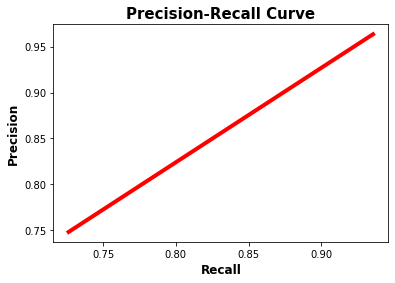

train loss epoch 46/500:   0%|          | 0/86940 [00:00<?, ?img/s]

0.7283281229205334


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.88img/s, loss=0.00982]


Validation epoch loss: 0.011157414228316174


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 104.65img/s, loss=0.04700]


Validation epoch loss: 0.044057316368828155


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 103.99img/s, loss=0.01016]


Validation epoch loss: 0.010115684028591542


validation loss: 100%|██████████| 9660/9660 [01:32<00:00, 103.92img/s, loss=0.01112]


Validation epoch loss: 0.012021844417152816


train loss epoch 50/500:  86%|████████▌ | 74752/86940 [25:44<04:10, 48.70img/s, loss=0.00946]

In [ ]:
train_main(dataset='FlickrLogos-20',
     model='LogoDetection',
     optimizer='Adam',
     vgg_cfg='B',
     max_epochs=500, 
     batch_size=32, 
     weight_decay=5e-4,
     learning_rate=4e-4,
     decay1=0.9, 
     decay2=0.999,
     verbose=True,
     batch_norm=True,
     load=None,
     val_split=0.1,
     step_eval=5,
     save_cp=True,
     )

In [ ]:
# !pip install nvgpu

In [ ]:
# import nvgpu

# avail_gpus = nvgpu.available_gpus()
# print(avail_gpus)